This Jupyter Notebook builds upon the referenced [Google Colab](https://colab.research.google.com/drive/1QzQYQxH052Rs088rxMQDveRjoVdkdl74?usp=sharing), integrating customized modifications to address the specific requirements of our testing.

# 1. Load Multimodal Data

## 1.1. Extract and Partition Text, Tables, and Images

In [1]:
# Remove existing figures
!rm -rf ./figures

In [2]:
import os
from langchain_community.document_loaders import UnstructuredPDFLoader

# Directory containing the PDFs
pdf_dir = './references'

# Collect all PDF files from the directory and subdirectories, excluding hidden ones
pdf_files = []
for root, dirs, files in os.walk(pdf_dir):
    # Exclude hidden directories
    dirs[:] = [d for d in dirs if not d.startswith('.')]
    for file in files:
        # Exclude hidden files
        if file.lower().endswith('.pdf') and not file.startswith('.'):
            pdf_files.append(os.path.join(root, file))

# Initialize an empty list to hold data from all PDFs
data = []

# Loop through each PDF file and load it
for pdf_file in pdf_files:
    print(f'Loading {pdf_file}')
    loader = UnstructuredPDFLoader(
        file_path=pdf_file,
        strategy='hi_res',
        extract_images_in_pdf=True,
        infer_table_structure=True,
        chunking_strategy="by_title",     # section-based chunking
        max_characters=4000,              # max size of chunks
        new_after_n_chars=4000,           # preferred size of chunks
        combine_text_under_n_chars=2000,  # combine smaller chunks
        mode='elements',
        image_output_dir_path='./figures'
    )
    data.extend(loader.load())

Loading ./references/Sample 2.pdf


/home/shihchi_liu/RAG/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading ./references/Sample 1.pdf


In [3]:
docs = []
tables = []

for doc in data:
    if doc.metadata['category'] == 'Table':
        tables.append(doc)
    elif doc.metadata['category'] == 'CompositeElement':
        docs.append(doc)

len(docs), len(tables)

(10, 5)

In [4]:
import htmltabletomd

for table in tables:
    table.page_content = htmltabletomd.convert_table(table.metadata['text_as_html'])

## 1.2. Examine Loaded Data (Optional)

In [5]:
from IPython.display import HTML, display, Markdown, Image

In [6]:
docs[0]

Document(metadata={'source': './references/Sample 2.pdf', 'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2024-11-17T16:34:32', 'page_number': 1, 'orig_elements': 'eJy9WUuP4zYS/iuETz2AqeVTJCenPQw2ATbZRqaxe5gMGnyUbGFkyyvJ3RkE+e8pUvKkkfGhx4jdB7erzJIoflVfPfThtxV0sIP99Nim1VuyktaCVtFRL52jKnFOg20YftikhW2STXK1JqsdTD75yaPNb6vY90Nq936Cscid/9wfp8cttJvthBohGEObRf3cpmmLWm6K9tC3+ynbffhgpazsmnAmKvVxTb7Iwswy18xV+pyiWKBmNX4eJ9jlJ7lvf4Xu/cFHWP2OPySYIE5tv3+MnR/Hx8PQB1zGKsesdLigaTuYPh+g2N7/uCob3m+OflOe6sMK9pvVx6Idp8ddn9qmhXJmgglF8aC4eeD1W6neSpGtD2j5uD/uAgz5afMmJvg1n8fq3R6Gfx3bBORnP7X7DXlftv3LUTCuHiBu9230Hbkf+gjpOMA4//JfGEZ8AsJ1xcstTvv9HnzCu+At/oqn9UlLxzitDVOIJ6tpqAOnWmkXNTeJ1/5qeArpCn5GVjLDtciCqVnm0tmqPqOYLS7D01qh9Y3xzCdHYt9185bIDo9uaH33D/j/sT1kOMgdVJuKTD7grtYkdu0h9H5Ia7IZ/GFLDv4Aw5ocYB/bjvh9IjD4EYY3373E+d/tOP2Qz+MM0r5popHaUjASqAJbU9/UjvKonPHeNYHr6yGtTMURSC4rU5BeZKVmWXFbqTNyWX8ZzsZxaW6Mc+x3B9zEqzFJ0sTQBEOhzpi4RlDnVEO9siI1LnF/zehTosIDEnoJrkWWQs8YcGVNJc8oZosL2RTvwm8dfe2mnZAuo99h0JC7X

In [7]:
print(tables[0].page_content)

| | |
| :--- | :--- |
| Component | Requirement |
| Processor | Intel Core i5 or equivalent CPU |
| Operating system | Windows 7 SP 1, Windows 10 (32/64-bit) |
| Memory | 4 GB RAM (32-bit) |
| Hard disk space | 8 GB available disk space |
| Display | Graphics card must support at least 1024x768 resolution |



In [8]:
tables[0].metadata['text_as_html']

'<table><tr><td>Component</td><td>Requirement</td></tr><tr><td>Processor</td><td>Intel Core i5 or equivalent CPU</td></tr><tr><td>Operating system</td><td>Windows 7 SP 1, Windows 10 (32/64-bit)</td></tr><tr><td>Memory</td><td>4 GB RAM (32-bit)</td></tr><tr><td>Hard disk space</td><td>8 GB available disk space</td></tr><tr><td>Display</td><td>Graphics card must support at least 1024x768 resolution</td></tr></table>'

In [9]:
display(Markdown(tables[0].metadata['text_as_html']))

<table><tr><td>Component</td><td>Requirement</td></tr><tr><td>Processor</td><td>Intel Core i5 or equivalent CPU</td></tr><tr><td>Operating system</td><td>Windows 7 SP 1, Windows 10 (32/64-bit)</td></tr><tr><td>Memory</td><td>4 GB RAM (32-bit)</td></tr><tr><td>Hard disk space</td><td>8 GB available disk space</td></tr><tr><td>Display</td><td>Graphics card must support at least 1024x768 resolution</td></tr></table>

In [10]:
for table in tables:
    print(table.page_content)
    print()

| | |
| :--- | :--- |
| Component | Requirement |
| Processor | Intel Core i5 or equivalent CPU |
| Operating system | Windows 7 SP 1, Windows 10 (32/64-bit) |
| Memory | 4 GB RAM (32-bit) |
| Hard disk space | 8 GB available disk space |
| Display | Graphics card must support at least 1024x768 resolution |


| | | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| Component | &lt;9.5 mm (&lt;3/8 in.) | 9.5-13mm (3/8 - 1/2 in.) | &#124; &gt;13-20mm &#124; &#124; (&gt;1/2-3/4in.) | &gt;20-40mm &#124; (&gt;3/4-1.5in.) &#124; | &gt;40 - 90 mm (&gt;1.5-3.5in.) &#124; | &gt;90 mm (&gt;3.5 in.) |
| Walls | 0 | 0.15 | 0.16 | 0.18 | 0.18 | 0 |
| Floors | 0 | 0.15 | 0.16 | 0.18 | 0.20 | 0 |
| Ceilings | 0 | 0.15 | 0.15 | 0.15 | 0.16 | 0 |
| Open joint cladding | 0 | 0 | 0 | 0 | 0 | 0 |


| | |
| :--- | :--- |
| Load | Thresholds and Resulting Values |
| Lighting | &lt; 25% of fixtures | with CFLs or LEDs | = 2.6 kWhiday (standard value) |
| &#124; 25%-75% of fixtures | with CFLs or 

In [11]:
! ls -l ./figures

total 452
-rw-r--r-- 1 shihchi_liu shihchi_liu  27929 Nov 18 14:20 figure-1-1.jpg
-rw-r--r-- 1 shihchi_liu shihchi_liu  27182 Nov 18 14:20 figure-1-2.jpg
-rw-r--r-- 1 shihchi_liu shihchi_liu  26589 Nov 18 14:20 figure-1-3.jpg
-rw-r--r-- 1 shihchi_liu shihchi_liu  26448 Nov 18 14:20 figure-2-4.jpg
-rw-r--r-- 1 shihchi_liu shihchi_liu  29260 Nov 18 14:20 figure-2-5.jpg
-rw-r--r-- 1 shihchi_liu shihchi_liu 102442 Nov 18 14:20 figure-3-1.jpg
-rw-r--r-- 1 shihchi_liu shihchi_liu 101680 Nov 18 14:20 figure-4-2.jpg
-rw-r--r-- 1 shihchi_liu shihchi_liu  40062 Nov 18 14:20 figure-4-3.jpg
-rw-r--r-- 1 shihchi_liu shihchi_liu  50949 Nov 18 14:20 figure-5-4.jpg
-rw-r--r-- 1 shihchi_liu shihchi_liu   9820 Nov 18 14:20 figure-5-5.jpg


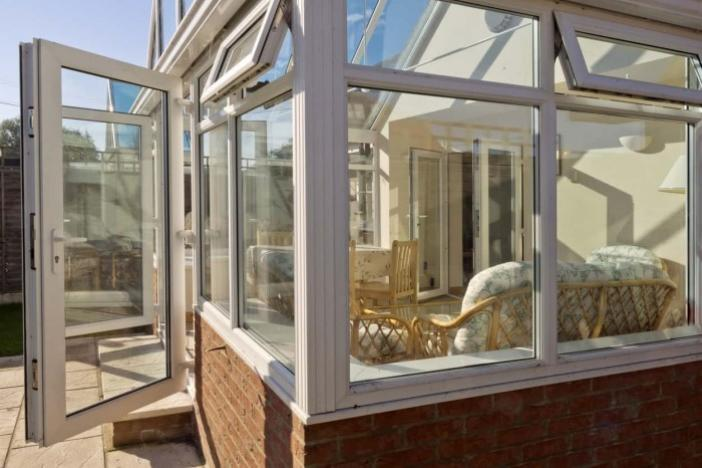

In [12]:
Image('./figures/figure-5-4.jpg')

# 2. Connect to LLM through API

In [13]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key:  ········


In [14]:
os.environ['OPENAI_API_KEY'] = OPENAI_KEY

In [15]:
from langchain_openai import ChatOpenAI

chatgpt = ChatOpenAI(model_name='gpt-4o', temperature=0)

# 3. Generate Text-Based Summaries for Multimodal Data

## 3.1. Create Text and Table Summaries

In [16]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text particularly for semantic retrieval.
These summaries will be embedded and used to retrieve the raw text or table elements.
Give a detailed summary of the table or text below that is well optimized for retrieval.
For any tables also add in a one line description of what the table is about besides the summary.
Do not add additional words like Summary: etc.

Table or text chunk:
{element}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
summarize_chain = (
                    {"element": RunnablePassthrough()}
                      |
                    prompt
                      |
                    chatgpt
                      |
                    StrOutputParser() # Extracts the response as text and returns it as a string
)

# Initialize empty summaries
text_summaries = []
table_summaries = []

text_docs = [doc.page_content for doc in docs]
table_docs = [table.page_content for table in tables]

text_summaries = summarize_chain.batch(text_docs, {"max_concurrency": 5})
table_summaries = summarize_chain.batch(table_docs, {"max_concurrency": 5})

len(text_summaries), len(table_summaries)

(10, 5)

## 3.2. Examine Text and Table Summaries (Optional)

In [17]:
text_summaries[0]

'The table outlines the necessary equipment and materials required for conducting assessments under the EnerGuide Rating System—Technical Procedures Version 15.12. It includes data collection tools like tablets and graph paper, a compass, a digital camera with specific capabilities, and safety gear such as disposable face masks or respirators, hard hats, safety glasses, and protective footwear. Additional tools include ladders, lights, a tape measure, a thermometer, and an air movement indicator. Specialized equipment like a low-emissivity window coating detector and blower door testing equipment is also required. A computer with specific operating systems and capabilities, including a .pdf viewer and Internet access, is necessary, as detailed in Table 1.'

In [18]:
table_summaries[0]

'This table outlines the minimum system requirements for a software application. It specifies that the processor should be an Intel Core i5 or equivalent CPU. The operating system must be either Windows 7 SP 1 or Windows 10, supporting both 32-bit and 64-bit versions. A minimum of 4 GB RAM is required for 32-bit systems. The system should have at least 8 GB of available hard disk space. Additionally, the graphics card must support a display resolution of at least 1024x768.'

## 3.3. Create Image Summaries

In [19]:
import base64
from langchain_core.messages import HumanMessage

# Create a function to encode images
def encode_image(image_path):
    # Get the base64 string
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

# Create image summaries
def image_summarize(img_base64, prompt):
    chat = ChatOpenAI(model="gpt-4o", temperature=0)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval.
                Remember these images could potentially contain graphs, charts or tables also.
                These summaries will be embedded and used to retrieve the raw image for question answering.
                Give a detailed summary of the image that is well optimized for retrieval.
                Do not add additional words like Summary: etc.
             """

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries

# Image summaries
IMG_PATH = './figures'
imgs_base64, image_summaries = generate_img_summaries(IMG_PATH)

len(imgs_base64), len(image_summaries)

(10, 10)

## 3.4. Examine Image Summaries (Optional)

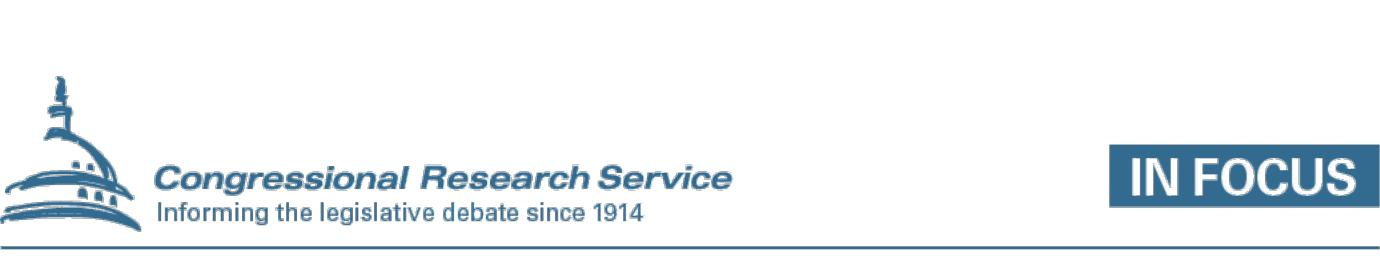

In [20]:
display(Image('./figures/figure-1-1.jpg'))

In [21]:
image_summaries[0]

'The image features the header of a document from the Congressional Research Service. It includes a stylized illustration of the U.S. Capitol dome on the left, followed by the text "Congressional Research Service" and the tagline "Informing the legislative debate since 1914" in blue. On the right side, there is a blue box with the text "IN FOCUS" in white. The overall design is clean and professional, indicating an official and informative document.'

# 4. Build Multi-Vetor Retrievers: Multimodal and Single-Modal

## 4.1. Access Embedding Model

In [22]:
from langchain_openai import OpenAIEmbeddings

openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-large')

## 4.2. Create Utility Functions

In [23]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_community.storage import RedisStore
from langchain_community.utilities.redis import get_client
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

# Create retriever that indexes summaries, but returns raw images or texts
def create_multi_vector_retriever(
    docstore, vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):

    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=docstore,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever

## 4.3. Initiate Vectorstores: Chroma

In [24]:
# The vectorstore to use to index the summaries and their embeddings
chroma_db_multimodal = Chroma(
    collection_name="mm_rag",
    embedding_function=openai_embed_model,
    collection_metadata={"hnsw:space": "cosine"},
)

# The vectorstore for single-modal RAG
chroma_db_single_modal = Chroma(
    collection_name="text_rag",
    embedding_function=openai_embed_model,
    collection_metadata={"hnsw:space": "cosine"},
)

## 4.4. Initiate Docstores: Redis and InMemoryStore

In JupyterLab's terminal (File > New > Terminal), run the following commands:

```bash
# 1. Import the GPG key for the Redis repository
curl -fsSL https://packages.redis.io/gpg | sudo gpg --dearmor -o /usr/share/keyrings/redis-archive-keyring.gpg

# 2. Add the Redis repository to your sources list
echo "deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] \
https://packages.redis.io/deb $(lsb_release -cs) main" | \
sudo tee /etc/apt/sources.list.d/redis.list

# 3. Update package lists
sudo apt-get update

# 4. Install Redis Stack Server
sudo apt-get install redis-stack-server

# 5. Start Redis Stack Server in the background
redis-stack-server --daemonize yes
```

In [25]:
# Initialize the storage layer - to store raw images, text and tables
client = get_client('redis://localhost:6379')
redis_store = RedisStore(client=client) # Can use filestore, memorystory, any other DB store also

from langchain.storage import InMemoryStore

# Initialize the storage layer for the single-modal retriever
docstore_single_modal = InMemoryStore()

## 4.5. Create Retrievers

In [26]:
retriever_multimodal = create_multi_vector_retriever(
    redis_store,
    chroma_db_multimodal,
    text_summaries,
    text_docs,
    table_summaries,
    table_docs,
    image_summaries,
    imgs_base64,
)

retriever_multimodal

MultiVectorRetriever(vectorstore=<langchain_chroma.vectorstores.Chroma object at 0xffd11f6f0b50>, docstore=<langchain_community.storage.redis.RedisStore object at 0xffd11f6f1450>, search_kwargs={})

In [27]:
retriever_single_modal = create_multi_vector_retriever(
    docstore_single_modal,
    chroma_db_single_modal,
    text_summaries,
    text_docs,
    table_summaries=[],  # Empty lists since we're only using text
    tables=[],
    image_summaries=[],  # No images
    images=[],
)

# Verify the single-modal retriever
retriever_single_modal

MultiVectorRetriever(vectorstore=<langchain_chroma.vectorstores.Chroma object at 0xffd11f6f1150>, docstore=<langchain_core.stores.InMemoryStore object at 0xffd11ef22fb0>, search_kwargs={})

# 5. Prepare for Retrieval

## 5.1. Setup Retrieval Display

In [28]:
from IPython.display import HTML, display, Markdown, Image
from PIL import Image
import base64
from io import BytesIO

# Disply base64 encoded string as image
def plt_img_base64(img_base64):
    # Decode the base64 string
    img_data = base64.b64decode(img_base64)
    # Create a BytesIO object
    img_buffer = BytesIO(img_data)
    # Open the image using PIL
    img = Image.open(img_buffer)
    display(img)

In [29]:
import re
import base64

def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Get the content
        if isinstance(doc, Document):
            doc_content = doc.page_content
        else:
            doc_content = doc
        # Ensure doc_content is a string
        if isinstance(doc_content, bytes):
            doc_str = doc_content.decode('utf-8')
        else:
            doc_str = doc_content  # already a string
        if looks_like_base64(doc_str) and is_image_data(doc_str):
            b64_images.append(doc_str)
        else:
            texts.append(doc_str)
    return {"images": b64_images, "texts": texts}

## 5.2. Examine Retrievals (Optional)

In [30]:
# Check retrieval
query = "Tell me detailed statistics of the top 5 years with largest wildfire acres burned"
docs = retriever_multimodal.invoke(query, limit=5)

# We get 4 docs
len(docs)

4

In [31]:
docs

[b'Figure 2. Top Five Years with Largest Wildfire Acreage Burned Since 1960\n\nTable 1. Annual Wildfires and Acres Burned',
 b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFLAqsDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0Dwx4Y07WdHF7eiVp2kYEiTGcVs/8IHon9yf/AL+mj

In [32]:
is_image_data(docs[1].decode('utf-8'))

True

In [33]:
r = split_image_text_types(docs)
r

{'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFLAqsDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0Dwx4Y07WdHF7eiVp2kYEiTGcVs/8IHon9yf/AL+mjwH/AMiyn/XV/wCddNQBzP8Awgeif3J/+/po/wCED0T+5P8A9/TXTUUAcz/wgeif3J/+/po/4QPRP7k//f010rMqKWdgqjqScAUKysoZWBU8gg8UAc1

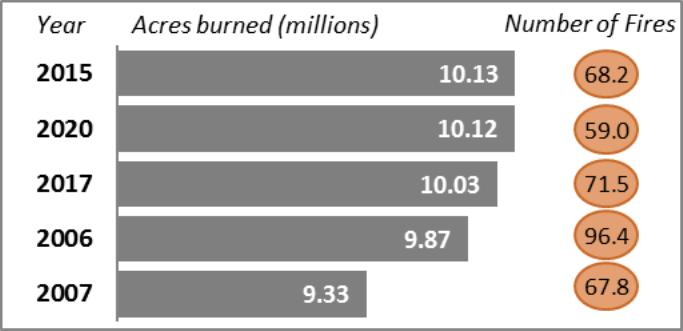

In [34]:
plt_img_base64(docs[1].decode('utf-8'))

# 6. Construct End-to-End RAG Pipeline

## 6.1. Chain RAG Components Altogether

In [35]:
from operator import itemgetter
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.messages import HumanMessage

def multimodal_prompt_function(data_dict):
    """
    Create a multimodal prompt with both text and image context.

    This function formats the provided context from `data_dict`, which contains
    text, tables, and base64-encoded images. It joins the text (with table) portions
    and prepares the image(s) in a base64-encoded format to be included in a message.

    The formatted text and images (context) along with the user question are used to
    construct a prompt for GPT-4o
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            f"""You are an analyst tasked with understanding detailed information and trends from text documents,
                data tables, and charts and graphs in images.
                You will be given context information below which will be a mix of text, tables, and images usually of charts or graphs.
                Use this information to provide answers related to the user question.
                Do not make up answers, use the provided context documents below and answer the question to the best of your ability.

                User question:
                {data_dict['question']}

                Context documents:
                {formatted_texts}

                Answer:
            """
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]

## 6.2. Implement RAG for QA

In [36]:
# Create RAG chain
rag = (
        {
            "context": itemgetter('context'),
            "question": itemgetter('input'),
        }
            |
        RunnableLambda(multimodal_prompt_function)
            |
        chatgpt
            |
        StrOutputParser()
)

In [37]:
def rag_qa(query, retriever):

    # Pass input query to retriever and get context document elements
    retrieve_docs = (itemgetter('input')
                        |
                    retriever
                        |
                    RunnableLambda(split_image_text_types))
    
    # Below, we chain `.assign` calls. This takes a dict and successively
    # adds keys-- "context" and "answer"-- where the value for each key
    # is determined by a Runnable (function or chain executing at runtime).
    # This helps in also having the retrieved context along with the answer generated by GPT-4o
    rag_w_sources = (RunnablePassthrough.assign(context=retrieve_docs)
                                        .assign(answer=rag)
    )

    response = rag_w_sources.invoke({'input': query})
    print('=='*50)
    print('Answer:')
    display(Markdown(response['answer']))
    print('--'*50)
    print('Sources:')
    text_sources = response['context']['texts']
    img_sources = response['context']['images']
    for text in text_sources:
        display(Markdown(text))
        print()
    for img in img_sources:
        plt_img_base64(img)
        print()
    print('=='*50)

In [38]:
def no_rag_qa(query):
    # Create a prompt that only includes the user's question
    messages = [
        HumanMessage(content=f"You are an assistant that answers questions based solely on the input provided.\n\nUser question:\n{query}\n\nAnswer:")
    ]
    
    response = chatgpt.invoke(messages)
    print('=='*50)
    print('Answer:')
    display(Markdown(response.content))
    print('=='*50)

## 6.3. Examine Multimodal RAG (Optional)

Answer:


The trend in annual wildfires and acres burned from 1993 to 2022 shows some key patterns:

1. **Number of Wildfires**: 
   - The number of wildfires has been variable but shows a slight decrease over the last 30 years. 
   - In the 1990s, there was an average of 78,600 wildfires annually.
   - From 2013 to 2022, the average was 61,410 wildfires annually.

2. **Acres Burned**:
   - The number of acres burned annually has generally increased over the same period.
   - In the 1990s, an average of 3.3 million acres burned annually.
   - Since 2000, the average has increased to 7.0 million acres annually.
   - From 2013 to 2022, the average was 7.2 million acres annually.
   - In 2022, 7.6 million acres were burned, with over 40% of those acres in Alaska.

Overall, while the number of wildfires has slightly decreased, the area affected by these fires has increased significantly, indicating that wildfires are becoming larger and potentially more severe.

----------------------------------------------------------------------------------------------------
Sources:


aa —= Informing the legislative debate since 1914 Congressional Research Service

Updated June 1, 2023

Wildfire Statistics

Wildfires are unplanned fires, including lightning-caused fires, unauthorized human-caused fires, and escaped fires from prescribed burn projects. States are responsible for responding to wildfires that begin on nonfederal (state, local, and private) lands, except for lands protected by federal agencies under cooperative agreements. The federal government is responsible for responding to wildfires that begin on federal lands. The Forest Service (FS)—within the U.S. Department of Agriculture—carries out wildfire management and response across the 193 million acres of the National Forest System (NFS). The Department of the Interior (DOI) manages wildfire response for more than 400 million acres of national parks, wildlife refuges and preserves, other public lands, and Indian reservations.

Figure 1. Annual Wildfires and Acres Burned, 1993-2022

Fires, thousands Acres burned, millions 120 Fires

Wildfire statistics help illustrate past U.S. wildfire activity. Nationwide data compiled by the National Interagency Coordination Center (NICC) indicate that the number of annual wildfires is variable but has decreased slightly over the last 30 years. The number of acres affected annually, while also variable, generally has increased (see Figure 1). Since 2000, an annual average of 70,025 wildfires have burned an annual average of 7.0 million acres. The acreage figure is more than double the average annual acreage burned in the 1990s (3.3 million acres), although a greater number of fires occurred annually in the 1990s on average (78,600).

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: Data reflect wildland fires and acres burned nationwide, including wildland fires on federal and nonfederal lands.

From 2013 to 2022, there were an average of 61,410 wildfires annually and an average of 7.2 million acres impacted annually. In 2022, 68,988 wildfires burned 7.6 million acres. Over 40% of those acres were in Alaska (3.1 million acres).

As of June 1, 2023, around 18,300 wildfires have impacted over 511,000 acres this year.

Figure 2. Top Five Years with Largest Wildfire Acreage Burned Since 1960

Table 1. Annual Wildfires and Acres Burned

| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
|  | 2018 | 2019 | 2020 | 2021 | 2022 |
| Number of Fires (thousands) |
| Federal | 12.5 | 10.9 | 14.4 | 14.0 | 11.7 |
| FS | 5.6 | 5.3 | 6.7 | 6.2 | 59 |
| Dol | 7.0 | 5.3 | 7.6 | 7.6 | 5.8 |
| Other | 0.1 | 0.2 | &lt;0.1 | 0.2 | 0.1 |
| Nonfederal | 45.6 | 39.6 | 44.6 | 45.0 | $7.2 |
| Total | 58.1 | 50.5 | 59.0 | 59.0 | 69.0 |
| Acres Burned (millions) |
| Federal | 4.6 | 3.1 | 7.1 | 5.2 | 40 |
| FS | 2.3 | 0.6 | 48 | 41 | 19 |
| Dol | 2.3 | 2.3 | 2.3 | 1.0 | 2.1 |
| Other | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 |
| Nonfederal | 4.1 | 1.6 | 3.1 | Lg | 3.6 |
| Total | 8.8 | 4.7 | 10.1 | 7.1 | 7.6 |


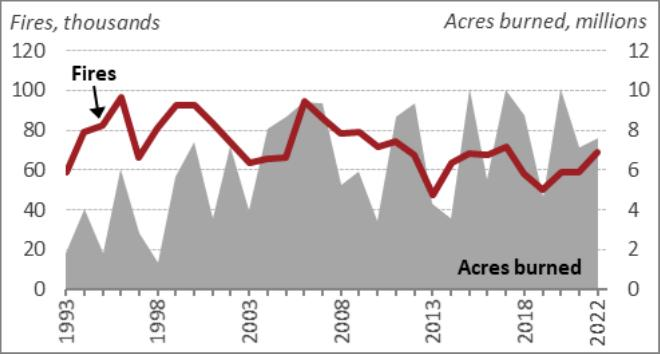

In [39]:
query = "Tell me about the annual wildfires trend with acres burned"
rag_qa(query, retriever_multimodal)

In [40]:
query = "Tell me about the number of acres burned by wildfires for the forest service in 2021"
rag_qa(query, retriever_multimodal)

Answer:


In 2021, the Forest Service (FS) was responsible for managing wildfires on federal lands. According to the data provided, the number of acres burned by wildfires on Forest Service land in 2021 was 4.1 million acres.

----------------------------------------------------------------------------------------------------
Sources:


aa —= Informing the legislative debate since 1914 Congressional Research Service

Updated June 1, 2023

Wildfire Statistics

Wildfires are unplanned fires, including lightning-caused fires, unauthorized human-caused fires, and escaped fires from prescribed burn projects. States are responsible for responding to wildfires that begin on nonfederal (state, local, and private) lands, except for lands protected by federal agencies under cooperative agreements. The federal government is responsible for responding to wildfires that begin on federal lands. The Forest Service (FS)—within the U.S. Department of Agriculture—carries out wildfire management and response across the 193 million acres of the National Forest System (NFS). The Department of the Interior (DOI) manages wildfire response for more than 400 million acres of national parks, wildlife refuges and preserves, other public lands, and Indian reservations.

Figure 1. Annual Wildfires and Acres Burned, 1993-2022

Fires, thousands Acres burned, millions 120 Fires

Wildfire statistics help illustrate past U.S. wildfire activity. Nationwide data compiled by the National Interagency Coordination Center (NICC) indicate that the number of annual wildfires is variable but has decreased slightly over the last 30 years. The number of acres affected annually, while also variable, generally has increased (see Figure 1). Since 2000, an annual average of 70,025 wildfires have burned an annual average of 7.0 million acres. The acreage figure is more than double the average annual acreage burned in the 1990s (3.3 million acres), although a greater number of fires occurred annually in the 1990s on average (78,600).

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: Data reflect wildland fires and acres burned nationwide, including wildland fires on federal and nonfederal lands.

From 2013 to 2022, there were an average of 61,410 wildfires annually and an average of 7.2 million acres impacted annually. In 2022, 68,988 wildfires burned 7.6 million acres. Over 40% of those acres were in Alaska (3.1 million acres).

As of June 1, 2023, around 18,300 wildfires have impacted over 511,000 acres this year.

Source: National Interagency Coordination Center (NICC)

2022

Year Number of Fires Acres burned (millions) 2015 2020 2017 2006 2007

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: Number of fires in thousands.

The number of fires and acreage burned are indicators of the annual level of wildfire activity. These numbers may not be indicative of fire’s impact on human development or communities, since many fires occur in large, relatively undeveloped areas. Acreage burned also does not indicate the severity of a wildfire, the degree of impact upon forests or soils, or other ecological effects.

Most wildfires are human-caused (89% of the average number of wildfires from 2018 to 2022). Wildfires caused by lightning tend to be slightly larger and to burn more acreage (53% of the average acreage burned from 2018 to 2022) than human-caused fires.

Wildland Fire Summary and Statistics annual reports.

Notes: FS = Forest Service; DOI = Department of the Interior. Column totals may not sum precisely due to rounding.

https://crsreports.congress.gov

Wildfire Statistics

In 2022, 52% of the nationwide acreage burned by wildfires was on federal lands (4.0 million acres; see Table 1), lower than the 10-year average (64%) of impacted federal land acreage. The other 48% of the acreage burned in 2022 was on state, local, or privately owned lands, though the fires on these lands accounted for 83% of total fires. Of the federal acreage burned nationwide in 2022, 52% (2.1 million acres) burned on DOI land and 47% (1.9 million acres) burned on FS land (see Figure 3). The 2022 figures are driven largely by Alaska, where just over half of the acreage impacted occurred on nonfederal lands (1.6 million acres) and just under half was on DOI lands (1.5 million acres).

Resources

Another metric useful for assessing wildfire activity is the extent to which nationwide resources—including personnel and equipment—are engaged in wildfire suppression. A proxy for resource commitments is the nationwide Preparedness Level (PL) scale, which ranges from 1 (lowest) to 5 (highest). The higher PLs indicate significant commitment of shared resources. In 2022, the nationwide level was 4 for 10 days and never reached the highest level (5). In contrast, the highest level was reached for 68 days in 2021, the longest since at least 2000.

| | | | | | |
| :--- | :--- | :--- | :--- | :--- | :--- |
|  | 2018 | 2019 | 2020 | 2021 | 2022 |
| Number of Fires (thousands) |
| Federal | 12.5 | 10.9 | 14.4 | 14.0 | 11.7 |
| FS | 5.6 | 5.3 | 6.7 | 6.2 | 59 |
| Dol | 7.0 | 5.3 | 7.6 | 7.6 | 5.8 |
| Other | 0.1 | 0.2 | &lt;0.1 | 0.2 | 0.1 |
| Nonfederal | 45.6 | 39.6 | 44.6 | 45.0 | $7.2 |
| Total | 58.1 | 50.5 | 59.0 | 59.0 | 69.0 |
| Acres Burned (millions) |
| Federal | 4.6 | 3.1 | 7.1 | 5.2 | 40 |
| FS | 2.3 | 0.6 | 48 | 41 | 19 |
| Dol | 2.3 | 2.3 | 2.3 | 1.0 | 2.1 |
| Other | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 |
| Nonfederal | 4.1 | 1.6 | 3.1 | Lg | 3.6 |
| Total | 8.8 | 4.7 | 10.1 | 7.1 | 7.6 |


Source: NICC Wildland Fire Summary and Statistics annual reports.

Conflagrations

Of the 1.6 million wildfires that have occurred since 2000, 254 exceeded 100,000 acres burned and 16 exceeded 500,000 acres burned. A small fraction of wildfires become catastrophic, and a small percentage of fires accounts for the vast majority of acres burned. For example, about 1% of wildfires become conflagrations—raging, destructive fires—but predicting which fires will “blow up” into conflagrations is challenging and depends on a multitude of factors, such as weather and geography. There have been 1,041 large or significant fires annually on average from 2018 through 2022. In 2022, 2% of wildfires were classified as large or significant (1,289); 45 exceeded 40,000 acres in size, and 17 exceeded 100,000 acres. For context, there were fewer large or significant wildfires in 2021 (943) but more in 2017 (1,409).

Issues for Congress

Issues Congress may consider include the strategies and resources used for wildfire prevention, mitigation, and management, as well as wildfires’ impact on both the quality of life and the economies of communities affected by wildfire activity. Other issues relate to post-wildfire recovery and site restoration. Congress also considers the total federal cost of wildfire management, including the cost of suppression operations; these costs vary annually and are difficult to predict.

Source: NICC Wildland Fire Summary and Statistics annual reports. Notes: West: AK, AZ, CA, CO, ID, HI, MT, NM, NV, OR, UT, WA, and WY. East: All other states and Puerto Rico.

Katie Hoover, Specialist in Natural Resources Policy Laura A. Hanson, Senior Research Librarian

IF10244

https://crsreports.congress.gov

Wildfire Statistics

Disclaimer

This document was prepared by the Congressional Research Service (CRS). CRS serves as nonpartisan shared staff to congressional committees and Members of Congress. It operates solely at the behest of and under the direction of Congress. Information in a CRS Report should not be relied upon for purposes other than public understanding of information that has been provided by CRS to Members of Congress in connection with CRS’s institutional role. CRS Reports, as a work of the United States Government, are not subject to copyright protection in the United States. Any CRS Report may be reproduced and distributed in its entirety without permission from CRS. However, as a CRS Report may include copyrighted images or material from a third party, you may need to obtain the permission of the copyright holder if you wish to copy or otherwise use copyrighted material.

https://crsreports.congress.gov | IF10244 · VERSION 68 · UPDATED

In [41]:
query = "Tell me about the percentage of residences burned by wildfires in 2022"
rag_qa(query, retriever_multimodal)

Answer:


In 2022, 46% of the structures burned by wildfires were residences. This information is sourced from the National Interagency Coordination Center (NICC).

----------------------------------------------------------------------------------------------------
Sources:


| | | | | |
| :--- | :--- | :--- | :--- | :--- |
|  | 2019 | 2020 | 2021 | 2022 |
| Structures Burned | 963 | 17,904 | 5,972 | 2,717 |
| % Residences | 46% | 54% | 60% | 46% |


Source: National Interagency Coordination Center (NICC)

2022

Year Number of Fires Acres burned (millions) 2015 2020 2017 2006 2007

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: Number of fires in thousands.

The number of fires and acreage burned are indicators of the annual level of wildfire activity. These numbers may not be indicative of fire’s impact on human development or communities, since many fires occur in large, relatively undeveloped areas. Acreage burned also does not indicate the severity of a wildfire, the degree of impact upon forests or soils, or other ecological effects.

Most wildfires are human-caused (89% of the average number of wildfires from 2018 to 2022). Wildfires caused by lightning tend to be slightly larger and to burn more acreage (53% of the average acreage burned from 2018 to 2022) than human-caused fires.

Wildland Fire Summary and Statistics annual reports.

Notes: FS = Forest Service; DOI = Department of the Interior. Column totals may not sum precisely due to rounding.

https://crsreports.congress.gov

Wildfire Statistics

In 2022, 52% of the nationwide acreage burned by wildfires was on federal lands (4.0 million acres; see Table 1), lower than the 10-year average (64%) of impacted federal land acreage. The other 48% of the acreage burned in 2022 was on state, local, or privately owned lands, though the fires on these lands accounted for 83% of total fires. Of the federal acreage burned nationwide in 2022, 52% (2.1 million acres) burned on DOI land and 47% (1.9 million acres) burned on FS land (see Figure 3). The 2022 figures are driven largely by Alaska, where just over half of the acreage impacted occurred on nonfederal lands (1.6 million acres) and just under half was on DOI lands (1.5 million acres).

Resources

Another metric useful for assessing wildfire activity is the extent to which nationwide resources—including personnel and equipment—are engaged in wildfire suppression. A proxy for resource commitments is the nationwide Preparedness Level (PL) scale, which ranges from 1 (lowest) to 5 (highest). The higher PLs indicate significant commitment of shared resources. In 2022, the nationwide level was 4 for 10 days and never reached the highest level (5). In contrast, the highest level was reached for 68 days in 2021, the longest since at least 2000.

Wildfire Damages

Figure 3. Percentage Acreage Burned by Ownership

100% ° Non- ! federal 75% Other [ federal 50% DOI 25% Forest 0% Service 2018 2019 2021 2022 2020

Wildfires may affect certain ecological resources beneficially, but wildfires also may have devastating impacts, especially for communities affected by wildfire activity. Statistics showing the level of destruction a wildfire caused can provide useful metrics to evaluate the fire’s effect. Such statistics may include acres burned or impacted, lives lost (firefighters and civilians), and structures (residential, commercial, and other) destroyed. For example, in 2022, over 2,700 structures were burned in wildfires; the majority of the damage occurred in California (see Table 2).

Table 2. Loss Statistics

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: DOI = Department of the Interior.

More wildfires occur in the East (including the central states), but the wildfires in the West (i.e., Alaska, Arizona, California, Colorado, Idaho, Montana, New Mexico, Nevada, Oregon, Utah, Washington, and Wyoming) are larger and burn more acreage. In 2022, just over 20,000 wildfires burned approximately 5.8 million acres in the West, compared with the over 48,000 fires that burned just over 1.8 million acres in the East. In the East (where there is less federal acreage), most of the fires occur on nonfederal lands; in the West, most of the fires occur on federal lands (see Figure 4). In 2022, 85% (1.5 million acres) of the acreage burned in the East was on nonfederal land, whereas 64% (3.7 million acres) of the acreage burned in the West was on federal land.

Figure 4. Acreage Burned by Region and Ownership

Acres burned, millions 12 East Nonfederal 10 East Federal West Nonfederal West Federal ON FD Ww 2018 2019 2020 2021 2022

Source: NICC Wildland Fire Summary and Statistics annual reports.

Conflagrations

Of the 1.6 million wildfires that have occurred since 2000, 254 exceeded 100,000 acres burned and 16 exceeded 500,000 acres burned. A small fraction of wildfires become catastrophic, and a small percentage of fires accounts for the vast majority of acres burned. For example, about 1% of wildfires become conflagrations—raging, destructive fires—but predicting which fires will “blow up” into conflagrations is challenging and depends on a multitude of factors, such as weather and geography. There have been 1,041 large or significant fires annually on average from 2018 through 2022. In 2022, 2% of wildfires were classified as large or significant (1,289); 45 exceeded 40,000 acres in size, and 17 exceeded 100,000 acres. For context, there were fewer large or significant wildfires in 2021 (943) but more in 2017 (1,409).

Issues for Congress

Issues Congress may consider include the strategies and resources used for wildfire prevention, mitigation, and management, as well as wildfires’ impact on both the quality of life and the economies of communities affected by wildfire activity. Other issues relate to post-wildfire recovery and site restoration. Congress also considers the total federal cost of wildfire management, including the cost of suppression operations; these costs vary annually and are difficult to predict.

Source: NICC Wildland Fire Summary and Statistics annual reports. Notes: West: AK, AZ, CA, CO, ID, HI, MT, NM, NV, OR, UT, WA, and WY. East: All other states and Puerto Rico.

Katie Hoover, Specialist in Natural Resources Policy Laura A. Hanson, Senior Research Librarian

IF10244

https://crsreports.congress.gov

Wildfire Statistics

Disclaimer

This document was prepared by the Congressional Research Service (CRS). CRS serves as nonpartisan shared staff to congressional committees and Members of Congress. It operates solely at the behest of and under the direction of Congress. Information in a CRS Report should not be relied upon for purposes other than public understanding of information that has been provided by CRS to Members of Congress in connection with CRS’s institutional role. CRS Reports, as a work of the United States Government, are not subject to copyright protection in the United States. Any CRS Report may be reproduced and distributed in its entirety without permission from CRS. However, as a CRS Report may include copyrighted images or material from a third party, you may need to obtain the permission of the copyright holder if you wish to copy or otherwise use copyrighted material.

https://crsreports.congress.gov | IF10244 · VERSION 68 · UPDATED

## 6.4. Examine Single-Modal RAG (Optional)

In [42]:
query = "Tell me about the annual wildfires trend with acres burned"
rag_qa(query, retriever_single_modal)

Answer:


The trend in annual wildfires and acres burned in the United States over the past few decades shows some notable patterns:

1. **Number of Wildfires**: The number of annual wildfires has been variable but has shown a slight decrease over the last 30 years. For instance, from 2000 to 2022, there was an average of 70,025 wildfires annually, which is lower than the average of 78,600 wildfires per year in the 1990s.

2. **Acres Burned**: In contrast to the number of wildfires, the number of acres burned annually has generally increased. From 2000 to 2022, an average of 7.0 million acres were burned annually, which is more than double the average annual acreage burned in the 1990s (3.3 million acres).

3. **Recent Data**: From 2013 to 2022, there was an average of 61,410 wildfires annually, with an average of 7.2 million acres impacted each year. In 2022 specifically, 68,988 wildfires burned 7.6 million acres, with over 40% of those acres in Alaska.

4. **Large Fires**: A small fraction of wildfires become large or significant, accounting for the majority of acres burned. For example, from 2018 to 2022, there were an average of 1,041 large or significant fires annually. In 2022, 2% of wildfires were classified as large or significant, with 45 fires exceeding 40,000 acres and 17 exceeding 100,000 acres.

Overall, while the number of wildfires has slightly decreased, the trend shows an increase in the total acreage burned, indicating that fires are becoming larger and potentially more destructive.

----------------------------------------------------------------------------------------------------
Sources:


aa —= Informing the legislative debate since 1914 Congressional Research Service

Updated June 1, 2023

Wildfire Statistics

Wildfires are unplanned fires, including lightning-caused fires, unauthorized human-caused fires, and escaped fires from prescribed burn projects. States are responsible for responding to wildfires that begin on nonfederal (state, local, and private) lands, except for lands protected by federal agencies under cooperative agreements. The federal government is responsible for responding to wildfires that begin on federal lands. The Forest Service (FS)—within the U.S. Department of Agriculture—carries out wildfire management and response across the 193 million acres of the National Forest System (NFS). The Department of the Interior (DOI) manages wildfire response for more than 400 million acres of national parks, wildlife refuges and preserves, other public lands, and Indian reservations.

Figure 1. Annual Wildfires and Acres Burned, 1993-2022

Fires, thousands Acres burned, millions 120 Fires

Wildfire statistics help illustrate past U.S. wildfire activity. Nationwide data compiled by the National Interagency Coordination Center (NICC) indicate that the number of annual wildfires is variable but has decreased slightly over the last 30 years. The number of acres affected annually, while also variable, generally has increased (see Figure 1). Since 2000, an annual average of 70,025 wildfires have burned an annual average of 7.0 million acres. The acreage figure is more than double the average annual acreage burned in the 1990s (3.3 million acres), although a greater number of fires occurred annually in the 1990s on average (78,600).

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: Data reflect wildland fires and acres burned nationwide, including wildland fires on federal and nonfederal lands.

From 2013 to 2022, there were an average of 61,410 wildfires annually and an average of 7.2 million acres impacted annually. In 2022, 68,988 wildfires burned 7.6 million acres. Over 40% of those acres were in Alaska (3.1 million acres).

As of June 1, 2023, around 18,300 wildfires have impacted over 511,000 acres this year.

Figure 2. Top Five Years with Largest Wildfire Acreage Burned Since 1960

Table 1. Annual Wildfires and Acres Burned

Source: NICC Wildland Fire Summary and Statistics annual reports.

Conflagrations

Of the 1.6 million wildfires that have occurred since 2000, 254 exceeded 100,000 acres burned and 16 exceeded 500,000 acres burned. A small fraction of wildfires become catastrophic, and a small percentage of fires accounts for the vast majority of acres burned. For example, about 1% of wildfires become conflagrations—raging, destructive fires—but predicting which fires will “blow up” into conflagrations is challenging and depends on a multitude of factors, such as weather and geography. There have been 1,041 large or significant fires annually on average from 2018 through 2022. In 2022, 2% of wildfires were classified as large or significant (1,289); 45 exceeded 40,000 acres in size, and 17 exceeded 100,000 acres. For context, there were fewer large or significant wildfires in 2021 (943) but more in 2017 (1,409).

Issues for Congress

Issues Congress may consider include the strategies and resources used for wildfire prevention, mitigation, and management, as well as wildfires’ impact on both the quality of life and the economies of communities affected by wildfire activity. Other issues relate to post-wildfire recovery and site restoration. Congress also considers the total federal cost of wildfire management, including the cost of suppression operations; these costs vary annually and are difficult to predict.

Source: NICC Wildland Fire Summary and Statistics annual reports. Notes: West: AK, AZ, CA, CO, ID, HI, MT, NM, NV, OR, UT, WA, and WY. East: All other states and Puerto Rico.

Katie Hoover, Specialist in Natural Resources Policy Laura A. Hanson, Senior Research Librarian

IF10244

https://crsreports.congress.gov

Wildfire Statistics

Disclaimer

This document was prepared by the Congressional Research Service (CRS). CRS serves as nonpartisan shared staff to congressional committees and Members of Congress. It operates solely at the behest of and under the direction of Congress. Information in a CRS Report should not be relied upon for purposes other than public understanding of information that has been provided by CRS to Members of Congress in connection with CRS’s institutional role. CRS Reports, as a work of the United States Government, are not subject to copyright protection in the United States. Any CRS Report may be reproduced and distributed in its entirety without permission from CRS. However, as a CRS Report may include copyrighted images or material from a third party, you may need to obtain the permission of the copyright holder if you wish to copy or otherwise use copyrighted material.

https://crsreports.congress.gov | IF10244 · VERSION 68 · UPDATED

Source: National Interagency Coordination Center (NICC)

2022

Year Number of Fires Acres burned (millions) 2015 2020 2017 2006 2007

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: Number of fires in thousands.

The number of fires and acreage burned are indicators of the annual level of wildfire activity. These numbers may not be indicative of fire’s impact on human development or communities, since many fires occur in large, relatively undeveloped areas. Acreage burned also does not indicate the severity of a wildfire, the degree of impact upon forests or soils, or other ecological effects.

Most wildfires are human-caused (89% of the average number of wildfires from 2018 to 2022). Wildfires caused by lightning tend to be slightly larger and to burn more acreage (53% of the average acreage burned from 2018 to 2022) than human-caused fires.

Wildland Fire Summary and Statistics annual reports.

Notes: FS = Forest Service; DOI = Department of the Interior. Column totals may not sum precisely due to rounding.

https://crsreports.congress.gov

Wildfire Statistics

In 2022, 52% of the nationwide acreage burned by wildfires was on federal lands (4.0 million acres; see Table 1), lower than the 10-year average (64%) of impacted federal land acreage. The other 48% of the acreage burned in 2022 was on state, local, or privately owned lands, though the fires on these lands accounted for 83% of total fires. Of the federal acreage burned nationwide in 2022, 52% (2.1 million acres) burned on DOI land and 47% (1.9 million acres) burned on FS land (see Figure 3). The 2022 figures are driven largely by Alaska, where just over half of the acreage impacted occurred on nonfederal lands (1.6 million acres) and just under half was on DOI lands (1.5 million acres).

Resources

Another metric useful for assessing wildfire activity is the extent to which nationwide resources—including personnel and equipment—are engaged in wildfire suppression. A proxy for resource commitments is the nationwide Preparedness Level (PL) scale, which ranges from 1 (lowest) to 5 (highest). The higher PLs indicate significant commitment of shared resources. In 2022, the nationwide level was 4 for 10 days and never reached the highest level (5). In contrast, the highest level was reached for 68 days in 2021, the longest since at least 2000.

In [43]:
query = "Tell me about the number of acres burned by wildfires for the forest service in 2021"
rag_qa(query, retriever_single_modal)

Answer:


The context provided does not include specific data on the number of acres burned by wildfires for the Forest Service in 2021. However, it does mention that in 2022, 47% of the federal acreage burned nationwide was on Forest Service land, which amounted to 1.9 million acres. For 2021, the document does not provide a breakdown of acres burned specifically for the Forest Service. If you need detailed statistics for 2021, you might need to refer to the National Interagency Coordination Center (NICC) Wildland Fire Summary and Statistics annual reports for that year.

----------------------------------------------------------------------------------------------------
Sources:


aa —= Informing the legislative debate since 1914 Congressional Research Service

Updated June 1, 2023

Wildfire Statistics

Wildfires are unplanned fires, including lightning-caused fires, unauthorized human-caused fires, and escaped fires from prescribed burn projects. States are responsible for responding to wildfires that begin on nonfederal (state, local, and private) lands, except for lands protected by federal agencies under cooperative agreements. The federal government is responsible for responding to wildfires that begin on federal lands. The Forest Service (FS)—within the U.S. Department of Agriculture—carries out wildfire management and response across the 193 million acres of the National Forest System (NFS). The Department of the Interior (DOI) manages wildfire response for more than 400 million acres of national parks, wildlife refuges and preserves, other public lands, and Indian reservations.

Figure 1. Annual Wildfires and Acres Burned, 1993-2022

Fires, thousands Acres burned, millions 120 Fires

Wildfire statistics help illustrate past U.S. wildfire activity. Nationwide data compiled by the National Interagency Coordination Center (NICC) indicate that the number of annual wildfires is variable but has decreased slightly over the last 30 years. The number of acres affected annually, while also variable, generally has increased (see Figure 1). Since 2000, an annual average of 70,025 wildfires have burned an annual average of 7.0 million acres. The acreage figure is more than double the average annual acreage burned in the 1990s (3.3 million acres), although a greater number of fires occurred annually in the 1990s on average (78,600).

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: Data reflect wildland fires and acres burned nationwide, including wildland fires on federal and nonfederal lands.

From 2013 to 2022, there were an average of 61,410 wildfires annually and an average of 7.2 million acres impacted annually. In 2022, 68,988 wildfires burned 7.6 million acres. Over 40% of those acres were in Alaska (3.1 million acres).

As of June 1, 2023, around 18,300 wildfires have impacted over 511,000 acres this year.

Source: National Interagency Coordination Center (NICC)

2022

Year Number of Fires Acres burned (millions) 2015 2020 2017 2006 2007

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: Number of fires in thousands.

The number of fires and acreage burned are indicators of the annual level of wildfire activity. These numbers may not be indicative of fire’s impact on human development or communities, since many fires occur in large, relatively undeveloped areas. Acreage burned also does not indicate the severity of a wildfire, the degree of impact upon forests or soils, or other ecological effects.

Most wildfires are human-caused (89% of the average number of wildfires from 2018 to 2022). Wildfires caused by lightning tend to be slightly larger and to burn more acreage (53% of the average acreage burned from 2018 to 2022) than human-caused fires.

Wildland Fire Summary and Statistics annual reports.

Notes: FS = Forest Service; DOI = Department of the Interior. Column totals may not sum precisely due to rounding.

https://crsreports.congress.gov

Wildfire Statistics

In 2022, 52% of the nationwide acreage burned by wildfires was on federal lands (4.0 million acres; see Table 1), lower than the 10-year average (64%) of impacted federal land acreage. The other 48% of the acreage burned in 2022 was on state, local, or privately owned lands, though the fires on these lands accounted for 83% of total fires. Of the federal acreage burned nationwide in 2022, 52% (2.1 million acres) burned on DOI land and 47% (1.9 million acres) burned on FS land (see Figure 3). The 2022 figures are driven largely by Alaska, where just over half of the acreage impacted occurred on nonfederal lands (1.6 million acres) and just under half was on DOI lands (1.5 million acres).

Resources

Another metric useful for assessing wildfire activity is the extent to which nationwide resources—including personnel and equipment—are engaged in wildfire suppression. A proxy for resource commitments is the nationwide Preparedness Level (PL) scale, which ranges from 1 (lowest) to 5 (highest). The higher PLs indicate significant commitment of shared resources. In 2022, the nationwide level was 4 for 10 days and never reached the highest level (5). In contrast, the highest level was reached for 68 days in 2021, the longest since at least 2000.

Source: NICC Wildland Fire Summary and Statistics annual reports.

Conflagrations

Of the 1.6 million wildfires that have occurred since 2000, 254 exceeded 100,000 acres burned and 16 exceeded 500,000 acres burned. A small fraction of wildfires become catastrophic, and a small percentage of fires accounts for the vast majority of acres burned. For example, about 1% of wildfires become conflagrations—raging, destructive fires—but predicting which fires will “blow up” into conflagrations is challenging and depends on a multitude of factors, such as weather and geography. There have been 1,041 large or significant fires annually on average from 2018 through 2022. In 2022, 2% of wildfires were classified as large or significant (1,289); 45 exceeded 40,000 acres in size, and 17 exceeded 100,000 acres. For context, there were fewer large or significant wildfires in 2021 (943) but more in 2017 (1,409).

Issues for Congress

Issues Congress may consider include the strategies and resources used for wildfire prevention, mitigation, and management, as well as wildfires’ impact on both the quality of life and the economies of communities affected by wildfire activity. Other issues relate to post-wildfire recovery and site restoration. Congress also considers the total federal cost of wildfire management, including the cost of suppression operations; these costs vary annually and are difficult to predict.

Source: NICC Wildland Fire Summary and Statistics annual reports. Notes: West: AK, AZ, CA, CO, ID, HI, MT, NM, NV, OR, UT, WA, and WY. East: All other states and Puerto Rico.

Katie Hoover, Specialist in Natural Resources Policy Laura A. Hanson, Senior Research Librarian

IF10244

https://crsreports.congress.gov

Wildfire Statistics

Disclaimer

This document was prepared by the Congressional Research Service (CRS). CRS serves as nonpartisan shared staff to congressional committees and Members of Congress. It operates solely at the behest of and under the direction of Congress. Information in a CRS Report should not be relied upon for purposes other than public understanding of information that has been provided by CRS to Members of Congress in connection with CRS’s institutional role. CRS Reports, as a work of the United States Government, are not subject to copyright protection in the United States. Any CRS Report may be reproduced and distributed in its entirety without permission from CRS. However, as a CRS Report may include copyrighted images or material from a third party, you may need to obtain the permission of the copyright holder if you wish to copy or otherwise use copyrighted material.

https://crsreports.congress.gov | IF10244 · VERSION 68 · UPDATED

Wildfire Damages

Figure 3. Percentage Acreage Burned by Ownership

100% ° Non- ! federal 75% Other [ federal 50% DOI 25% Forest 0% Service 2018 2019 2021 2022 2020

Wildfires may affect certain ecological resources beneficially, but wildfires also may have devastating impacts, especially for communities affected by wildfire activity. Statistics showing the level of destruction a wildfire caused can provide useful metrics to evaluate the fire’s effect. Such statistics may include acres burned or impacted, lives lost (firefighters and civilians), and structures (residential, commercial, and other) destroyed. For example, in 2022, over 2,700 structures were burned in wildfires; the majority of the damage occurred in California (see Table 2).

Table 2. Loss Statistics

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: DOI = Department of the Interior.

More wildfires occur in the East (including the central states), but the wildfires in the West (i.e., Alaska, Arizona, California, Colorado, Idaho, Montana, New Mexico, Nevada, Oregon, Utah, Washington, and Wyoming) are larger and burn more acreage. In 2022, just over 20,000 wildfires burned approximately 5.8 million acres in the West, compared with the over 48,000 fires that burned just over 1.8 million acres in the East. In the East (where there is less federal acreage), most of the fires occur on nonfederal lands; in the West, most of the fires occur on federal lands (see Figure 4). In 2022, 85% (1.5 million acres) of the acreage burned in the East was on nonfederal land, whereas 64% (3.7 million acres) of the acreage burned in the West was on federal land.

Figure 4. Acreage Burned by Region and Ownership

Acres burned, millions 12 East Nonfederal 10 East Federal West Nonfederal West Federal ON FD Ww 2018 2019 2020 2021 2022

In [44]:
query = "Tell me about the percentage of residences burned by wildfires in 2022"
rag_qa(query, retriever_single_modal)

Answer:


In 2022, over 2,700 structures were burned in wildfires, with the majority of the damage occurring in California. The context does not provide a specific percentage of residences burned by wildfires in 2022, but it does indicate the total number of structures affected.

----------------------------------------------------------------------------------------------------
Sources:


Source: National Interagency Coordination Center (NICC)

2022

Year Number of Fires Acres burned (millions) 2015 2020 2017 2006 2007

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: Number of fires in thousands.

The number of fires and acreage burned are indicators of the annual level of wildfire activity. These numbers may not be indicative of fire’s impact on human development or communities, since many fires occur in large, relatively undeveloped areas. Acreage burned also does not indicate the severity of a wildfire, the degree of impact upon forests or soils, or other ecological effects.

Most wildfires are human-caused (89% of the average number of wildfires from 2018 to 2022). Wildfires caused by lightning tend to be slightly larger and to burn more acreage (53% of the average acreage burned from 2018 to 2022) than human-caused fires.

Wildland Fire Summary and Statistics annual reports.

Notes: FS = Forest Service; DOI = Department of the Interior. Column totals may not sum precisely due to rounding.

https://crsreports.congress.gov

Wildfire Statistics

In 2022, 52% of the nationwide acreage burned by wildfires was on federal lands (4.0 million acres; see Table 1), lower than the 10-year average (64%) of impacted federal land acreage. The other 48% of the acreage burned in 2022 was on state, local, or privately owned lands, though the fires on these lands accounted for 83% of total fires. Of the federal acreage burned nationwide in 2022, 52% (2.1 million acres) burned on DOI land and 47% (1.9 million acres) burned on FS land (see Figure 3). The 2022 figures are driven largely by Alaska, where just over half of the acreage impacted occurred on nonfederal lands (1.6 million acres) and just under half was on DOI lands (1.5 million acres).

Resources

Another metric useful for assessing wildfire activity is the extent to which nationwide resources—including personnel and equipment—are engaged in wildfire suppression. A proxy for resource commitments is the nationwide Preparedness Level (PL) scale, which ranges from 1 (lowest) to 5 (highest). The higher PLs indicate significant commitment of shared resources. In 2022, the nationwide level was 4 for 10 days and never reached the highest level (5). In contrast, the highest level was reached for 68 days in 2021, the longest since at least 2000.

Wildfire Damages

Figure 3. Percentage Acreage Burned by Ownership

100% ° Non- ! federal 75% Other [ federal 50% DOI 25% Forest 0% Service 2018 2019 2021 2022 2020

Wildfires may affect certain ecological resources beneficially, but wildfires also may have devastating impacts, especially for communities affected by wildfire activity. Statistics showing the level of destruction a wildfire caused can provide useful metrics to evaluate the fire’s effect. Such statistics may include acres burned or impacted, lives lost (firefighters and civilians), and structures (residential, commercial, and other) destroyed. For example, in 2022, over 2,700 structures were burned in wildfires; the majority of the damage occurred in California (see Table 2).

Table 2. Loss Statistics

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: DOI = Department of the Interior.

More wildfires occur in the East (including the central states), but the wildfires in the West (i.e., Alaska, Arizona, California, Colorado, Idaho, Montana, New Mexico, Nevada, Oregon, Utah, Washington, and Wyoming) are larger and burn more acreage. In 2022, just over 20,000 wildfires burned approximately 5.8 million acres in the West, compared with the over 48,000 fires that burned just over 1.8 million acres in the East. In the East (where there is less federal acreage), most of the fires occur on nonfederal lands; in the West, most of the fires occur on federal lands (see Figure 4). In 2022, 85% (1.5 million acres) of the acreage burned in the East was on nonfederal land, whereas 64% (3.7 million acres) of the acreage burned in the West was on federal land.

Figure 4. Acreage Burned by Region and Ownership

Acres burned, millions 12 East Nonfederal 10 East Federal West Nonfederal West Federal ON FD Ww 2018 2019 2020 2021 2022

Source: NICC Wildland Fire Summary and Statistics annual reports.

Conflagrations

Of the 1.6 million wildfires that have occurred since 2000, 254 exceeded 100,000 acres burned and 16 exceeded 500,000 acres burned. A small fraction of wildfires become catastrophic, and a small percentage of fires accounts for the vast majority of acres burned. For example, about 1% of wildfires become conflagrations—raging, destructive fires—but predicting which fires will “blow up” into conflagrations is challenging and depends on a multitude of factors, such as weather and geography. There have been 1,041 large or significant fires annually on average from 2018 through 2022. In 2022, 2% of wildfires were classified as large or significant (1,289); 45 exceeded 40,000 acres in size, and 17 exceeded 100,000 acres. For context, there were fewer large or significant wildfires in 2021 (943) but more in 2017 (1,409).

Issues for Congress

Issues Congress may consider include the strategies and resources used for wildfire prevention, mitigation, and management, as well as wildfires’ impact on both the quality of life and the economies of communities affected by wildfire activity. Other issues relate to post-wildfire recovery and site restoration. Congress also considers the total federal cost of wildfire management, including the cost of suppression operations; these costs vary annually and are difficult to predict.

Source: NICC Wildland Fire Summary and Statistics annual reports. Notes: West: AK, AZ, CA, CO, ID, HI, MT, NM, NV, OR, UT, WA, and WY. East: All other states and Puerto Rico.

Katie Hoover, Specialist in Natural Resources Policy Laura A. Hanson, Senior Research Librarian

IF10244

https://crsreports.congress.gov

Wildfire Statistics

Disclaimer

This document was prepared by the Congressional Research Service (CRS). CRS serves as nonpartisan shared staff to congressional committees and Members of Congress. It operates solely at the behest of and under the direction of Congress. Information in a CRS Report should not be relied upon for purposes other than public understanding of information that has been provided by CRS to Members of Congress in connection with CRS’s institutional role. CRS Reports, as a work of the United States Government, are not subject to copyright protection in the United States. Any CRS Report may be reproduced and distributed in its entirety without permission from CRS. However, as a CRS Report may include copyrighted images or material from a third party, you may need to obtain the permission of the copyright holder if you wish to copy or otherwise use copyrighted material.

https://crsreports.congress.gov | IF10244 · VERSION 68 · UPDATED

aa —= Informing the legislative debate since 1914 Congressional Research Service

Updated June 1, 2023

Wildfire Statistics

Wildfires are unplanned fires, including lightning-caused fires, unauthorized human-caused fires, and escaped fires from prescribed burn projects. States are responsible for responding to wildfires that begin on nonfederal (state, local, and private) lands, except for lands protected by federal agencies under cooperative agreements. The federal government is responsible for responding to wildfires that begin on federal lands. The Forest Service (FS)—within the U.S. Department of Agriculture—carries out wildfire management and response across the 193 million acres of the National Forest System (NFS). The Department of the Interior (DOI) manages wildfire response for more than 400 million acres of national parks, wildlife refuges and preserves, other public lands, and Indian reservations.

Figure 1. Annual Wildfires and Acres Burned, 1993-2022

Fires, thousands Acres burned, millions 120 Fires

Wildfire statistics help illustrate past U.S. wildfire activity. Nationwide data compiled by the National Interagency Coordination Center (NICC) indicate that the number of annual wildfires is variable but has decreased slightly over the last 30 years. The number of acres affected annually, while also variable, generally has increased (see Figure 1). Since 2000, an annual average of 70,025 wildfires have burned an annual average of 7.0 million acres. The acreage figure is more than double the average annual acreage burned in the 1990s (3.3 million acres), although a greater number of fires occurred annually in the 1990s on average (78,600).

Source: NICC Wildland Fire Summary and Statistics annual reports. Note: Data reflect wildland fires and acres burned nationwide, including wildland fires on federal and nonfederal lands.

From 2013 to 2022, there were an average of 61,410 wildfires annually and an average of 7.2 million acres impacted annually. In 2022, 68,988 wildfires burned 7.6 million acres. Over 40% of those acres were in Alaska (3.1 million acres).

As of June 1, 2023, around 18,300 wildfires have impacted over 511,000 acres this year.

## 6.5. Examine No-RAG (Optional)

In [45]:
query = "Tell me about the annual wildfires trend with acres burned"
no_rag_qa(query)

Answer:


The annual trend of wildfires and the acres burned can vary significantly from year to year due to a variety of factors such as weather conditions, climate change, forest management practices, and human activities. Generally, in recent decades, there has been an increase in the frequency and intensity of wildfires in many regions, particularly in areas like the western United States, Australia, and parts of Europe. This trend is often attributed to rising temperatures, prolonged droughts, and changes in land use, which contribute to more severe fire seasons and larger areas being burned. However, specific data on the number of acres burned each year would be needed to provide a detailed analysis of the trend.

In [46]:
query = "Tell me about the number of acres burned by wildfires for the forest service in 2021"
no_rag_qa(query)

Answer:


In 2021, wildfires burned approximately 6.8 million acres across the United States, according to the U.S. Forest Service. This figure includes fires on both federal and non-federal lands. The year was marked by several large and destructive fires, particularly in the western states, which contributed significantly to the total acreage burned.

In [47]:
query = "Tell me about the percentage of residences burned by wildfires in 2022"
no_rag_qa(query)

Answer:


I'm sorry, but I cannot provide specific statistics or data on the percentage of residences burned by wildfires in 2022 based solely on the input provided. You may need to refer to official reports or databases from relevant authorities such as government agencies or research organizations for accurate and detailed information.

# 7. Query Energy Advisor Exam Questions

## 7.1. Read the Excel File

In [107]:
import pandas as pd

# Path to the Excel file
excel_file_path = './EA QAs/EA QAs.xlsx'

# Read the Excel file into a DataFrame
questions_df = pd.read_excel(excel_file_path, sheet_name='EA QAs')

# Ensure the columns are correct
print(questions_df.columns)

Index(['#', 'Question', 'Image', 'Option', 'Answer'], dtype='object')


## 7.2. Define Helper Functions

In [108]:
import re
import base64
import os
from io import BytesIO
from PIL import Image as PILImage
from IPython.display import display, Markdown

In [109]:
def extract_answer(text):
    """Extracts the agent's answer, ensuring it is one of (A), (B), (C), or (D)."""
    match = re.search(r'\b([ABCD])\b', text.strip().upper())
    return match.group(1) if match else None

In [110]:
def encode_image(image_path, max_size=(800, 800)):
    """
    Encodes an image file to a Base64 string after resizing it to a maximum size.
    """
    try:
        with PILImage.open(image_path) as img:
            # Resize the image while maintaining aspect ratio
            img.thumbnail(max_size, PILImage.LANCZOS)
            
            # Save the image to a BytesIO object
            buffered = BytesIO()
            img.save(buffered, format="JPEG", quality=85)
            
            # Encode the image to Base64
            img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
            return img_str
    except FileNotFoundError:
        print(f"Warning: Image file {image_path} not found.")
        return None

In [111]:
def resize_base64_image(img_base64, max_size=(800, 800)):
    """Resizes a Base64-encoded image to the specified maximum size."""
    img_data = base64.b64decode(img_base64)
    img = PILImage.open(BytesIO(img_data))
    img.thumbnail(max_size, PILImage.LANCZOS)
    buffered = BytesIO()
    img.save(buffered, format="JPEG", quality=85)
    resized_img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return resized_img_str

In [112]:
def split_docs_into_images_texts_tables(docs):
    """Splits documents into images, texts, and tables."""
    images = []
    texts = []
    tables = []
    for doc in docs:
        # Extract content and metadata
        content = doc.page_content if hasattr(doc, 'page_content') else str(doc)
        
        # Decode content if it's bytes
        if isinstance(content, bytes):
            content = content.decode('utf-8', errors='ignore')
        
        metadata = doc.metadata if hasattr(doc, 'metadata') else {}
        category = metadata.get('category', '')
        
        # Check the category to classify the content
        if content.startswith('data:image'):
            images.append(content)
        elif category.lower() == 'table':
            tables.append(content)
        else:
            texts.append(content)
    return {'images': images, 'texts': texts, 'tables': tables}

In [113]:
def display_base64_image(img_base64):
    """Displays a Base64-encoded image."""
    img_data = base64.b64decode(img_base64)
    img = PILImage.open(BytesIO(img_data))
    display(img)

## 7.3. Modify RAG Functions

In [114]:
def rag_multiple_choice_qa(question, options, retriever, image_base64=None):
    """Answers a multiple-choice question using the given retriever."""
    # Retrieve relevant documents
    retrieved_docs = retriever.get_relevant_documents(question)
    
    # Split documents into images, texts, and tables
    sources = split_docs_into_images_texts_tables(retrieved_docs)
    
    # Limit text sources to 100 words
    def limit_text_length(text):
        words = text.split()
        return ' '.join(words[:100])
    
    sources['texts'] = [limit_text_length(text) for text in sources['texts']]
    
    # Build the prompt
    formatted_texts = "\n".join(sources['texts'])
    messages = []
    
    # Include the question image in the messages if provided
    if image_base64:
        # Resize the question image if necessary
        resized_image_base64 = resize_base64_image(image_base64)
        messages.append({
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{resized_image_base64}"}
        })
    
    # Add images from retrieved sources to the messages
    for image_data in sources['images']:
        # Extract the Base64 data
        img_base64 = image_data.split(',', 1)[1] if ',' in image_data else image_data
        # Resize the image
        resized_img_base64 = resize_base64_image(img_base64)
        # Reconstruct the data URL
        resized_image_data = f"data:image/jpeg;base64,{resized_img_base64}"
        messages.append({
            "type": "image_url",
            "image_url": {"url": resized_image_data},
        })
    
    # Add tables from retrieved sources to the messages
    for table_text in sources['tables']:
        # Decode table_text if it's bytes
        if isinstance(table_text, bytes):
            table_text = table_text.decode('utf-8', errors='ignore')
        messages.append({
            "type": "text",
            "text": table_text  # Tables are included without restriction
        })
    
    # Add the text message
    prompt_text = f"""You are an assistant that answers multiple-choice questions based solely on the input provided.
You will be given a question, several options, and context documents.
Use the context documents to choose the correct option.
Respond with only the letter of the chosen option: (A), (B), (C), or (D).

User question:
{question}

Options:
{options}

Context documents:
{formatted_texts}

Answer:"""
    
    messages.append({
        "type": "text",
        "text": prompt_text
    })
    
    # Send the messages to the LLM
    response = chatgpt.invoke([HumanMessage(content=messages)])
    
    # Extract the answer
    answer_text = response.content.strip()
    answer = extract_answer(answer_text)
    
    return answer, sources

In [115]:
def no_rag_multiple_choice_qa(question, options, image_base64=None):
    """Answers a multiple-choice question without retrieval (no RAG)."""
    messages = []
    
    # Include the question image in the messages if provided
    if image_base64:
        # Resize the question image if necessary
        resized_image_base64 = resize_base64_image(image_base64)
        messages.append({
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{resized_image_base64}"}
        })
    
    # Add the question and options
    prompt_text = f"""You are an assistant that answers multiple-choice questions based solely on the input provided.
You will be given a question and several options.
Choose the correct option from the given options, and respond with only the letter of the chosen option: (A), (B), (C), or (D).

User question:
{question}

Options:
{options}

Answer:"""
    
    messages.append({
        "type": "text",
        "text": prompt_text
    })
    
    # Send the messages to the LLM
    response = chatgpt.invoke([HumanMessage(content=messages)])
    
    # Extract the answer
    answer_text = response.content.strip()
    answer = extract_answer(answer_text)
    
    return answer

## 7.4. Process Each Question and Collect Responses

[EA-ENVIRO-009]
------------------------------
(D): True answer

(D): Multimodal RAG - CORRECT
(B): Single-modal RAG - WRONG
(B): No-RAG - WRONG
------------------------------
Question:
The following is not mandatory equipment for evaluations:

Options:
(A) Thermometer
(B) Low-emissivity window coating detector
(C) Compass
(D) Hygrometer
------------------------------
Multimodal RAG (can be text, table, or image. All must be rendered for easy comprehension):
Source 1:


b'EnerGuide Rating System\xe2\x80\x94Technical Procedures\xe2\x80\x94Version 15.12\n\ndata collection material/equipment (e.g. tablet, clipboard, graph paper, pencil and eraser);\n\ncompass;\n\ndigital camera (minimum three megapixels, must be able to record date and time on photos or be searchable in each photo\xe2\x80\x99s properties);\n\ndisposable face mask (minimum P100, R100 or N100 rating or HEPA filter) or an equivalent half- mask respirator (mandatory for attic assessments);\n\nladder(s);\n\nlights (e.g. trouble light, flashlight);\n\nhard hat (mandatory on construction sites);\n\nsafety glasses or goggles (mandatory on construction sites);\n\nprotective footwear (mandatory on construction sites);\n\ntape measure (preferably 10 m (33 ft.) or longer);\n\nthermometer;\n\nair movement indicator such as a smoke pencil, incense, hand-held fogger or a fluffy feather


Source 2:


b'NOTE: Windows 8, Surface Pro and tablets are not supported.\n\n2.4.2 Optional equipment\n\nThe energy advisor may choose to use the following optional items and equipment:\n\naluminum foil (to help prevent pilot lights from being extinguished during the airtightness test);\n\nnon-metallic knitting needle (to measure insulation thickness);\n\nmasking tape (paint grade);\n\nmirror with extendable handle;\n\nnon-marking, clean, indoor footwear or over-booties;\n\nstud finder;\n\ntarps (to protect flooring when opening attic hatch and to cover fireplace openings);\n\nborescope (to view inside walls);\n\nhygrometer (to measure humidity);\n\nthermal imaging camera;\n\n6\n\nEnerGuide Rating System\xe2\x80\x94Technical Procedures\xe2\x80\x94Version 15.12\n\nnormalized leakage rate (NLR50) of the building. If the enabled fields are not used, then the NLR50 will not be calculated.\n\n2.7.10


Source 3:


b'1 Proof of an appliance rating via documentation is required to use the actual consumption.\n\nNOTE: The absence of an electric clothes dryer or range is not accounted for under reduced operating conditions and their absence will not be considered as a reduction to electrical base loads. Gas appliances are not accounted for.\n\n1. Average annual energy consumption of the appliance in kilowatt hours 2. Energy efficiency of the appliance relative to similar models 3. Annual energy consumption range for models of this type and size 4. Type and size of the model 5. Model number \n\nFigure 2 \xe2\x80\x93 EnerGuide label for


Source 4:


b'2.8 Sketch requirements\n\nSketches must be clear and complete for documentation and quality assurance purposes. Detailed sketch requirements are noted in relevant building component sections of this manual. Geometry sketches and building plans must be complete and sufficiently detailed in order for a third party to re-create the house geometry calculations. All structures attached to the main house that are outside the building envelope must be indicated on the sketch as \xe2\x80\x9cunconditioned space\xe2\x80\x9d (e.g. unheated porches, attached garages, etc.) in order to identify buffered components.\n\nFor each storey of a house, a plan view sketch is required. Plan view sketches may overlay


------------------------------
Single-modal RAG (can only be text):
Source 1:


EnerGuide Rating System—Technical Procedures—Version 15.12 data collection material/equipment (e.g. tablet, clipboard, graph paper, pencil and eraser); compass; digital camera (minimum three megapixels, must be able to record date and time on photos or be searchable in each photo’s properties); disposable face mask (minimum P100, R100 or N100 rating or HEPA filter) or an equivalent half- mask respirator (mandatory for attic assessments); ladder(s); lights (e.g. trouble light, flashlight); hard hat (mandatory on construction sites); safety glasses or goggles (mandatory on construction sites); protective footwear (mandatory on construction sites); tape measure (preferably 10 m (33 ft.) or longer); thermometer; air movement indicator


Source 2:


NOTE: Windows 8, Surface Pro and tablets are not supported. 2.4.2 Optional equipment The energy advisor may choose to use the following optional items and equipment: aluminum foil (to help prevent pilot lights from being extinguished during the airtightness test); non-metallic knitting needle (to measure insulation thickness); masking tape (paint grade); mirror with extendable handle; non-marking, clean, indoor footwear or over-booties; stud finder; tarps (to protect flooring when opening attic hatch and to cover fireplace openings); borescope (to view inside walls); hygrometer (to measure humidity); thermal imaging camera; 6 EnerGuide Rating System—Technical Procedures—Version 15.12 normalized leakage rate (NLR50) of the


Source 3:


1 Proof of an appliance rating via documentation is required to use the actual consumption. NOTE: The absence of an electric clothes dryer or range is not accounted for under reduced operating conditions and their absence will not be considered as a reduction to electrical base loads. Gas appliances are not accounted for. 1. Average annual energy consumption of the appliance in kilowatt hours 2. Energy efficiency of the appliance relative to similar models 3. Annual energy consumption range for models of this type and size 4. Type and size of the model 5. Model number Figure 2 – EnerGuide


Source 4:


2.8 Sketch requirements Sketches must be clear and complete for documentation and quality assurance purposes. Detailed sketch requirements are noted in relevant building component sections of this manual. Geometry sketches and building plans must be complete and sufficiently detailed in order for a third party to re-create the house geometry calculations. All structures attached to the main house that are outside the building envelope must be indicated on the sketch as “unconditioned space” (e.g. unheated porches, attached garages, etc.) in order to identify buffered components. For each storey of a house, a plan view sketch is required. Plan view sketches


[EA-ENVIRO-010]
------------------------------
(A): True answer

(C): Multimodal RAG - WRONG
(C): Single-modal RAG - WRONG
(C): No-RAG - WRONG
------------------------------
Question:
The following best describes the subject of an N evaluation:

Options:
(A) A house that has been occupied for less than six months
(B) A house that had upgrades performed subsequent to a previous Basic Service
(C) A house that has been occupied for six months or more
(D) A multi-unit building that has been occupied for six months or more
------------------------------
Multimodal RAG (can be text, table, or image. All must be rendered for easy comprehension):
Source 1:


b'1 Proof of an appliance rating via documentation is required to use the actual consumption.\n\nNOTE: The absence of an electric clothes dryer or range is not accounted for under reduced operating conditions and their absence will not be considered as a reduction to electrical base loads. Gas appliances are not accounted for.\n\n1. Average annual energy consumption of the appliance in kilowatt hours 2. Energy efficiency of the appliance relative to similar models 3. Annual energy consumption range for models of this type and size 4. Type and size of the model 5. Model number \n\nFigure 2 \xe2\x80\x93 EnerGuide label for


Source 2:


b'EnerGuide Rating System\xe2\x80\x94Technical Procedures\xe2\x80\x94Version 15.12\n\ndata collection material/equipment (e.g. tablet, clipboard, graph paper, pencil and eraser);\n\ncompass;\n\ndigital camera (minimum three megapixels, must be able to record date and time on photos or be searchable in each photo\xe2\x80\x99s properties);\n\ndisposable face mask (minimum P100, R100 or N100 rating or HEPA filter) or an equivalent half- mask respirator (mandatory for attic assessments);\n\nladder(s);\n\nlights (e.g. trouble light, flashlight);\n\nhard hat (mandatory on construction sites);\n\nsafety glasses or goggles (mandatory on construction sites);\n\nprotective footwear (mandatory on construction sites);\n\ntape measure (preferably 10 m (33 ft.) or longer);\n\nthermometer;\n\nair movement indicator such as a smoke pencil, incense, hand-held fogger or a fluffy feather


Source 3:


b'2.8 Sketch requirements\n\nSketches must be clear and complete for documentation and quality assurance purposes. Detailed sketch requirements are noted in relevant building component sections of this manual. Geometry sketches and building plans must be complete and sufficiently detailed in order for a third party to re-create the house geometry calculations. All structures attached to the main house that are outside the building envelope must be indicated on the sketch as \xe2\x80\x9cunconditioned space\xe2\x80\x9d (e.g. unheated porches, attached garages, etc.) in order to identify buffered components.\n\nFor each storey of a house, a plan view sketch is required. Plan view sketches may overlay


Source 4:


b'NOTE: Windows 8, Surface Pro and tablets are not supported.\n\n2.4.2 Optional equipment\n\nThe energy advisor may choose to use the following optional items and equipment:\n\naluminum foil (to help prevent pilot lights from being extinguished during the airtightness test);\n\nnon-metallic knitting needle (to measure insulation thickness);\n\nmasking tape (paint grade);\n\nmirror with extendable handle;\n\nnon-marking, clean, indoor footwear or over-booties;\n\nstud finder;\n\ntarps (to protect flooring when opening attic hatch and to cover fireplace openings);\n\nborescope (to view inside walls);\n\nhygrometer (to measure humidity);\n\nthermal imaging camera;\n\n6\n\nEnerGuide Rating System\xe2\x80\x94Technical Procedures\xe2\x80\x94Version 15.12\n\nnormalized leakage rate (NLR50) of the building. If the enabled fields are not used, then the NLR50 will not be calculated.\n\n2.7.10


------------------------------
Single-modal RAG (can only be text):
Source 1:


1 Proof of an appliance rating via documentation is required to use the actual consumption. NOTE: The absence of an electric clothes dryer or range is not accounted for under reduced operating conditions and their absence will not be considered as a reduction to electrical base loads. Gas appliances are not accounted for. 1. Average annual energy consumption of the appliance in kilowatt hours 2. Energy efficiency of the appliance relative to similar models 3. Annual energy consumption range for models of this type and size 4. Type and size of the model 5. Model number Figure 2 – EnerGuide


Source 2:


EnerGuide Rating System—Technical Procedures—Version 15.12 data collection material/equipment (e.g. tablet, clipboard, graph paper, pencil and eraser); compass; digital camera (minimum three megapixels, must be able to record date and time on photos or be searchable in each photo’s properties); disposable face mask (minimum P100, R100 or N100 rating or HEPA filter) or an equivalent half- mask respirator (mandatory for attic assessments); ladder(s); lights (e.g. trouble light, flashlight); hard hat (mandatory on construction sites); safety glasses or goggles (mandatory on construction sites); protective footwear (mandatory on construction sites); tape measure (preferably 10 m (33 ft.) or longer); thermometer; air movement indicator


Source 3:


2.8 Sketch requirements Sketches must be clear and complete for documentation and quality assurance purposes. Detailed sketch requirements are noted in relevant building component sections of this manual. Geometry sketches and building plans must be complete and sufficiently detailed in order for a third party to re-create the house geometry calculations. All structures attached to the main house that are outside the building envelope must be indicated on the sketch as “unconditioned space” (e.g. unheated porches, attached garages, etc.) in order to identify buffered components. For each storey of a house, a plan view sketch is required. Plan view sketches


Source 4:


NOTE: Windows 8, Surface Pro and tablets are not supported. 2.4.2 Optional equipment The energy advisor may choose to use the following optional items and equipment: aluminum foil (to help prevent pilot lights from being extinguished during the airtightness test); non-metallic knitting needle (to measure insulation thickness); masking tape (paint grade); mirror with extendable handle; non-marking, clean, indoor footwear or over-booties; stud finder; tarps (to protect flooring when opening attic hatch and to cover fireplace openings); borescope (to view inside walls); hygrometer (to measure humidity); thermal imaging camera; 6 EnerGuide Rating System—Technical Procedures—Version 15.12 normalized leakage rate (NLR50) of the


[EA-ENVIRO-011]
------------------------------
(C): True answer

(B): Multimodal RAG - WRONG
(C): Single-modal RAG - CORRECT
(A): No-RAG - WRONG
------------------------------
Question:
What is the R value of the attic insulation in the photo, assuming the average depth is 11"?


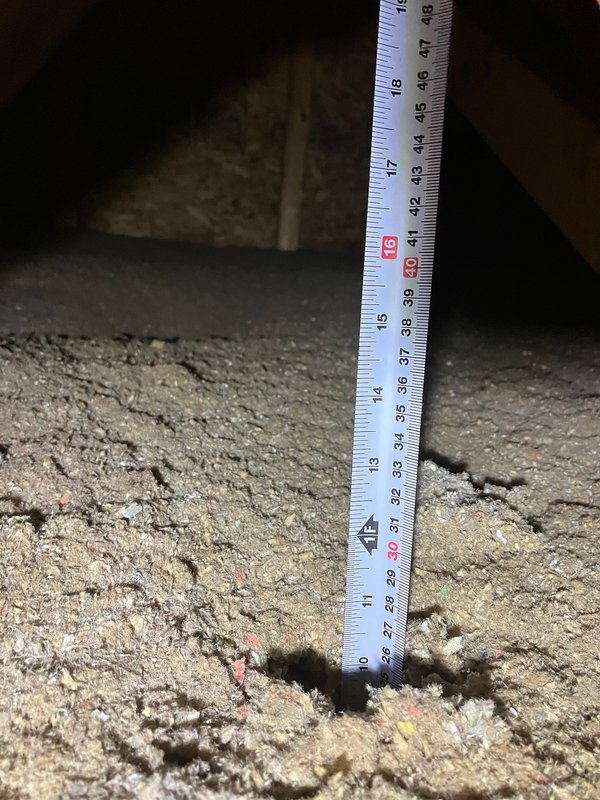


Options:
(A) R20
(B) R28
(C) R40
(D) R36
------------------------------
Multimodal RAG (can be text, table, or image. All must be rendered for easy comprehension):
Source 1:


b'NOTE: Windows 8, Surface Pro and tablets are not supported.\n\n2.4.2 Optional equipment\n\nThe energy advisor may choose to use the following optional items and equipment:\n\naluminum foil (to help prevent pilot lights from being extinguished during the airtightness test);\n\nnon-metallic knitting needle (to measure insulation thickness);\n\nmasking tape (paint grade);\n\nmirror with extendable handle;\n\nnon-marking, clean, indoor footwear or over-booties;\n\nstud finder;\n\ntarps (to protect flooring when opening attic hatch and to cover fireplace openings);\n\nborescope (to view inside walls);\n\nhygrometer (to measure humidity);\n\nthermal imaging camera;\n\n6\n\nEnerGuide Rating System\xe2\x80\x94Technical Procedures\xe2\x80\x94Version 15.12\n\nnormalized leakage rate (NLR50) of the building. If the enabled fields are not used, then the NLR50 will not be calculated.\n\n2.7.10


Source 2:


b'3.5.4.3 Buffering effect\n\nAssess and record wall sections that are buffered from outside temperatures by an enclosed space as separate wall sections. When HOT2000\xe2\x80\x99s Adjacent to Enclosed Unconditioned Space box is check marked, RSI 0.16 (R-0.9) will be added to the wall\xe2\x80\x99s thermal resistance. Note that walls adjacent to attics are not considered to be buffered as attics are vented to the exterior.\n\n3.5.4.4 Geometry data collection requirements\n\nCollect the following information for each distinct wall section:\n\nHeight: Measure the wall height from the floor to the ceiling to the nearest 2.5 cm (1 in.). If the height or composition of the wall varies,


Source 3:


b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHjA1QDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD14eBPCHfwpof/AILov/iaX/hBPB//AEKmh/8Aguh/+JroKKAOf/4QTwf/ANCpof8A4Lof/iaP+EE8H/8AQqaH/wCC6H/4mugooA5//hBPB/8A0Kmh/wDguh/+Jo/4QTwf/wBCpof/AILof/ia6CigDn/+EE8H/wDQqaH/AOC6H/4mj/hBPB//AEKmh/8Aguh/+JroKKAOf/4QTwf/ANCpof8A4Lof/iaP+EE8H/8AQqaH/wCC6H/4mugooA5//hBPB/8A0Kmh/wDguh/+Jo/4QTwf/wBCpof/AILof/ia6CigDn/+EE8H/wDQqaH/AOC6H/4mj/hBPB//AEKmh/8Aguh/+JroKKAOf/4QTwf/ANCpof8A4Lof/iaP+EE8H/8AQqaH/wCC6H/4mugooA5//hBPB/8A0Kmh/wDguh/+Jo/4QTwf/wBCpof/AILof/ia6CigDn/+EE8H/wDQqaH/AOC6H/4mj/hBPB//AEKmh/8Aguh/+JroKKAOf/4QTwf/ANCpof8A4Lof/iaP+EE8H/8AQqaH/wCC6H/4mugooA5//hBPB/8A0Kmh/wDguh/+Jo/4QTwf/wBCpof/AILof/ia6CigDn/+EE8H/wDQqaH/AOC6H/4mj/hBPB//AEKmh/8Aguh/+JroKKAOf/4QTwf/ANCpof8A4Lof/iaP+EE8H/8AQqaH/wCC6H/4mugooA5//hBPB/8A0Kmh/wDguh/+Jo/4QTwf/wBCpof/AILof/ia6CigDn/+EE8H/wDQqaH/AOC6H/4mj/hBPB//AEKmh/8Aguh/+JroKKAOf/4QTwf/ANCpof8A4Lof/iaP+EE8H/8AQqaH/wCC6H/4mugooA5//hBPB/8A0Kmh/wDguh/+Jo/4QTwf/wBCpof/AILof/ia6CigDn/+EE8H/wDQqaH/AOC6H/4mj/hBPB//AEKmh/8Aguh/+JroKKAOf/4QTwf/ANCpof8A4Lof/iaP+EE8H/8AQqaH/wCC6H/4mugooA5//hBPB/8A0Kmh/wDguh/+Jo/4QTwf/wBCpof/AILof/ia6CigDn/+EE8H/wDQqaH/AOC6H/4mj/hBPB//AEKmh/8Aguh/+JroKKAOf/4QTwf/ANCpof8A4Lof/iaP+EE8H/8AQqaH/wCC6H/4mugooA5//hBPB/8A0Kmh/wDguh/+Jo/4QTwf/wBCpof/AILof/ia6CigDn/+EE8H/wDQqaH/AOC6H/4mj/hBPB//AEKmh/8Aguh/+JroKKAOf/4QTwf/ANCpof8A4Lof/iaP+EE8H/8AQqaH/wCC6H/4mugooA5//hBPB/8A0Kmh/wDguh/+Jo/4QTwf/wBCpof/AILof/ia6CigDn/+EE8H/wDQqaH/AOC6H/4mj/hBPB//AEKmh/8Aguh/+JroKKAOf/4QTwf/ANCpof8A4Lof/iaP+EE8H/8AQqaH/wCC6H/4mugooA5//hBPB/8A0Kmh/wDguh/+Jo/4QTwf/wBCpof/AILof/ia6CigDn/+EE8H/wDQqaH/AOC6H/4mj/hBPB//AEKmh/8Aguh/+JroKKAOf/4QTwf/ANCpof8A4Lof/iaP+EE8H/8AQqaH/wCC6H/4mugooA5//hBPB/8A0Kmh/wDguh/+Jo/4QTwf/wBCpof/AILof/ia6CigDn/+EE8H/wDQqaH/AOC6H/4mj/hBPB//AEKmh/8Aguh/+JroKKAOf/4QTwf/ANCpof8A4Lof/iaP+EE8H/8AQqaH/wCC6H/4mugooA5//hBPB/8A0Kmh/wDguh/+Jo/4QTwf/wBCpof/AILof/ia6CigDn/+EE8H/wDQqaH/AOC6H/4mj/hBPB//AEKmh/8Aguh/+JroKKAOf/4QTwf/ANCpof8A4Lof/iaP+EE8H/8AQqaH/wCC6H/4mugooA5//hBPB/8A0Kmh/wDguh/+Jo/4QTwf/wBCpof/AILof/ia6CigDn/+EE8H/wDQqaH/AOC6H/4mj/hBPB//AEKmh/8Aguh/+JroKKAOf/4QTwf/ANCpof8A4Lof/iaP+EE8H/8AQqaH/wCC6H/4mugooA5//hBPB/8A0Kmh/wDguh/+Jo/4QTwf/wBCpof/AILof/ia6CigDn/+EE8H/wDQqaH/AOC6H/4mj/hBPB//AEKmh/8Aguh/+JroKKAOf/4QTwf/ANCpof8A4Lof/iaP+EE8H/8AQqaH/wCC6H/4mugooA5//hBPB/8A0Kmh/wDguh/+Jo/4QTwf/wBCpof/AILof/ia6CigDn/+EE8H/wDQqaH/AOC6H/4mj/hBPB//AEKmh/8Aguh/+JroKKAOf/4QTwf/ANCpof8A4Lof/iaP+EE8H/8AQqaH/wCC6H/4mugooA5//hBPB/8A0Kmh/wDguh/+Jo/4QTwf/wBCpof/AILof/ia6CigDn/+EE8H/wDQqaH/AOC6H/4mj/hBPB//AEKmh/8Aguh/+JroKKAOf/4QTwf/ANCpof8A4Lof/iaP+EE8H/8AQqaH/wCC6H/4mugooA5//hBPB/8A0Kmh/wDguh/+Jo/4QTwf/wBCpof/AILof/ia6CigDn/+EE8H/wDQqaH/AOC6H/4mj/hBPB//AEKmh/8Aguh/+JroKKAOf/4QTwf/ANCpof8A4Lof/iaP+EE8H/8AQqaH/wCC6H/4mugooA858ReHdD07UI4bLRtPtojEGKQWqICckZwB14H5UVpeLv8AkLRf9cB/6E1FAHaUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRVdb23a8a0E0ZnRQzR7huAPQ4/Cp80ALRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAcX4u/wCQtF/1wH/oTUUeLv8AkLRf9cB/6E1FAHaUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFc/4t8Rf8I5pHnRx+bdzN5VtF/ec+vsOta99fW+nWUt3dSrFDEu5mY4ArxvUtbvtZ1B9TeGR5Jm8nTrPByAe+PU9T7CqirsmTKcm0azHd3GpSxa5IPM+0xttPPYDpt9Afeu28OfEBo7pdJ8SPHFdOf3F2q7Yph6H0atnw14St9N0E22oxR3dzcnzLppFDAsewz2HauW8SeE59Jd3tbRr7SH5aHHmPD68Hkr+oqrxlpsKzWp6kDkZ7UteNaH4m1XwvIg82TU9CZhlCd0tsP8AZ7lR6e1es6fqdlqtqtxY3UVxE3Ro2BqHFrcpO5copKWkMKKKKACiiigAooooAKK5f4g6xfaF4J1G/wBNOy5QIqy7N4hDOqtIR3Cgk9+lc7o+k6zpupaXqWgeLbzxPp884i1OK6u4pUVGB/exnI27Tj5RknNAHpVFc5feO/Denam+n3eqLFOjbZGMTmOM+jyBdin/AHiMVNrHjHQNBmjg1HUkjmkUOsSI0rhf7xVASF/2jge9AG7RWLqvizQ9FtLe5vdRjEVyMweSrTNKMZ3KqAkrjHIGOfeo5PGnhyLT7O/bV7b7JeSGKGZWLKXClipIHynCng45468UAb1JmsTTPF2haxZXd5aagggsz/pDTo0PlDGcsJApAx36cda5BvGFrrvxR8Lw6Lq0stk8F59ohUvGjkICrMjY3DrhsEdcGgD0rNGa4X4pzTx6Jo8MOp3emrdaza201zaTmGRYnJDYYdOOeeOKqWXhm00qK+1Cx8deItUmgs5mFvc6sJ4xlCNxUAHIPIPY4oA9FBpa5O18W6VofhTQpta1IJcXNlCwDBpZZTsBZtqgsfc4471oXHi/w/a6LFrEmrWxsJjtiljbf5jf3VVclm4PygZ4PpQBuUVzqeOfDkmhXmtLqQ+w2RAuWaGQPFkgDdGV3jOR2rU0zV7HWYJJ9PuBPFHK0TOFIG4YzgkcjkcjIPY0AXqKKKACiiigDi/F3/IWi/64D/0JqKPF3/IWi/64D/0JqKAO0ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApCQASTgDqaWuM8c+Io7e2fQrORv7Ru0wxT/AJYxn7zE9jjpTSvohN2Oe8ZeJrfWbxbSF1bSbJ/MnnP3ZJRwFHqAefqK1PAWi3T3M2u38JiEieXZxOPmVOpY+hPH4VgeFdDj13UYYY4M6PYNmVz0kkHRR688mvXQMDAGAO1XJ2XKiY66i0EUtFZlnFeI/BKXMsmpaORb3xy0kXSOf6jsfeuBVbvRdaF9pySWGrL80tnKNi3C9wR0P+8M17mayNe8P2mvWRhnGyZeYZ1HzRN2I/w71UZW0exLj2M/w7420/XWS0k32WplctaTDDe5U9GHuK6evGNe8Pahp0MY1X92EkHkajbNjY3bPdSfy963PD/j2fS4ktPFUi7CQkOoRjKv/wBdAPun36U3HrHYE+56XRUcM0VxCssMivG4yrKcgipKgoKKKKACiiigDI8R6rd6NpX2210uXUtkqCWGFvnWMnDOoAJYgc7e/rXmOpp4W1HxHp2reAi6+I1vYlnSxieNGhLDzPPXAVRtzknBzjrXstFAHh+oWGhpeaza6t4v8YWWoy3t2w0WxuWAmR5XZBDHsIYOrKeuMsc45re0u/0/wR4w8QPrYuLS2v4LFbGa4iLecscAQx7lBG8MDle+civUqKAPKbW/i8P+MNM8R63pK+HtLn8PraRxhcxWs3nl/KO1QFJUg9BnBHas2wtjceLbLUxaSQadqPip7mzWWMxmQC0cGUA8gMwyMivaKKAPMfiHYXmqp4ts7K2e5mOlaXJ5EYy0irdXDOAO5KqeO/SmS+INI8Q/FfwdPpLNKsVvfRyS+SyAHy1/d8gfMvOR23D1r1GigDhPijBDdaf4bt7iKOaCXxFYpJHIoZXUuQQQeCCOMVsXnhzQ9G0PVptL0bTrGV7KVWe1tUiZl2k4JUDIro6KAPJdJvrbwz4i0vW9aV7fTrnw1aW0F80ZZEkU7mjJAO0kEEZwDj1qro8i6Rq58T39jc2mhT63e3EUj27fukkiRVmZcbkVyrckDG4Z617JRQB45481Sy1/wj4y1fSpDPp5020t/tKoQksizyMQpIGdodeR/e9q9hjjSKJY41CogCqB2Ap1FABRRRQAUUUUAcX4u/5C0X/XAf8AoTUUeLv+QtF/1wH/AKE1FAHaUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUmap32qW1hGWlcFh/CDzSbsBdorl7Xxna3FwUMZVAcFgc10Fte292m6CVXHf2pKSY2mixRSZpaoQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRTJZEhiaSRgqICWY8AD1oAzPEOu2/h/SZLyc7m+5FGDzI54Cj8a8ktrS71PV/sJnMmramxae4A4iQdT7ADoPWptZ1m41y7bVbvmGNyunWw6HJwpI7s36CvRfCfhWPQbZrm4PnancAG4mP8A6CvoBWq9xXM92a2kaVbaLpkFhaIFiiXHuT3J960KSlrI0CiiigAooooAgurWC8tpLe4iSWGQYZHGQRXnWt+B5tMhml01GvbAj5rJ+XQf7JPUe1emUmKabTuhNXPGPDOvXfheOX+zo3v9LLZayZyJYG7hM/8AoJxXqPh7xFYeJdNW9sXO3O143GHjYdQwrO17wdbanK95ZyfY78rguoykmOm9e/1HNecm31DRtclKTtpmtKvOw7op17Eg8MP1FXZT23J1W57dRXFeFfHkGpyjS9X22usJwVxhJv8AaQn+Xau1zWbVirhRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA4vxd/wAhaL/rgP8A0JqKPF3/ACFov+uA/wDQmooA7SiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAopryLGu52Cj1JxWNqPiWysVwsiSPj+9x+dJtIaTZt5rKvtfsrJGzIHdewP9a4LWPF9xeSFYWIT2OBXNyTSzMTJIzE+pqOZvYrltudXqnjW5n3R2zlQRjK8CuZnvrm6JM0zNntmq9HalbuF+xpWAxBn3q/FczwNmKVl+hqlZD/AEcfWrFJoLm9ZeKry3wszGRR/e5/WunsfEVndhQzeW57HpXnVHToSPpTu0GjPW1dXUMjBge4NOry611S6tWBjmcD0DV0lh4uy+26A2nuOCKpT7icTraKp2up2l4MxTKT6E4NW6pO5ItFFFMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAENeZeNNdm1XVpdEtpGj0+14vXU481uvl59PWuh8ceJJdIsUsbDB1O8ysf/AEyXu59hXCaHoM3iDUo9NUyf2dbENe3B6yt1257knk1cF1ZEn0Rv+B/Df9oSrruoxAwI3/EvgPRQP+WmPU9q9IFMjjSKNY41CooCqoGAAOlSAVLd3cpKyCiiikMKKKKACiiigAooooATFZ2qaJp2sRKl/bJLt+6/Rk+jDkfhWlRQB454l8OSaNPjULc3WmhswXg+/D6BiOQR/eFXdB8balod1Faa7N9r0qRgsV//ABRZ6CT1H+1XqborqVYBlPBBGc15/wCJPBTWvm6hoyF4jlptPxuVh3KA9D7dDV8yekiWrbHfxTRzRLJE6ujDKspyCKkrw/S9Su/Dd4b7RjLLAOLnS2YgY9VU/dYenevVvD/ijTPEdr5llN+9UfvLd/lkjPoy9qUotDTNqiiipGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBxfi7/kLRf8AXAf+hNRR4u/5C0X/AFwH/oTUUAdpRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFVrq9t7NN08gX27muZ1PxvBbhkgTL9iTk/lUuSQ0mzqprmG3TdNKiD1Y1gan4vsrNcQsHfsT0/LvXA6h4hu74nJIz/ETk/wD1qyGJY5Ykn1NQ5NlJI3tW8UXV+2Fc4z1PH5CsN5HlbdIxY+pptFKw7hRRRVCCiiigDVs+LZanqK1/490+lS0gCiiigAooopAOSV42yrEVs6f4kurT5Wbcuejc1iUUW7Dueg2XiexuU/ev5TZxzyK14riKdQ0UqOP9k5ryccHI61atdRubRgY5Dx6HFNTa3FypnqdFcdZ+MWG1bmIMBwWBwa37TXLG7IVJdrEdG4q1JEuLRpUUgIIyDkUtUIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArN1vWrTQdNe8vJNqj5UQctIx6KB3Jq/LKkMTyysEjQFmYngAV4/4k8UR69dpfmJhp1oxW0Q8tPIeNwH6D6k1UY3Ym7FN59X1jUZHWIyavqDfu4h0t4hwMn0Gc/U163oGkx6Jolrp6HcYk+d+7seWP4nNYvgnw/caZbzahqIX7dd7fkH/LGMdEz+OT711tOUr6IUV1AUtFFQUFFFFABRRRQAUUUUAFFFFABRRRQAUhFLRQBznibwtDrkImgK2+ox8xXAXP8AwFvUGvM9T0zUtPvIZLjfpeqxNi3ukOUl9s9wfQ8+1e3VS1PSrPV7J7S9gWWFux6g+oPY1Sk0S1c5Pwz4+SZUsfEZisdQ3bY3JxFce6noD7Gu5VgwBBBB6Ed68m8ReD59JspFkjfU9LJ67cywj3HcD1HNR+HvGF54Y09YpUl1XRwcxyo2ZoV9CD94Cm431iCfRnr1FUtL1S01nTob+xmEtvMu5WH8j71dqCgooooAKKKKACiiigAooooAKKKKACiiigAooooA4vxd/wAhaL/rgP8A0JqKPF3/ACFov+uA/wDQmooA7SiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACis3UNatrFG+cPIOig/zrjtT8b3G0pAyhs9I/8AGoc0ilFs7a+1K3sEzK2WPRR1rk9T8ctGWjgRQfY5P59BXF3Wq3d4T5shAPYVS71N5MqyRp3ut3t45ZpNue46/nWbz35oooSsJtsKKKKYBRRRQAUUUUAFBoqWCB7hsIOO57CplJJXY0m9EaduMQJ9KkoERijVTzgY4opRlGWzCUXHRhRRRVCCiiigAooooAKKKKACnRyPE2UYim0UmkwuzZsfEt7ZYGQ6f3TzXQWXi2CbiePZ7qc1w1H86NVsGj3PV4LmG5TfFIrj2NTV5Xb6hdWxzFKwrctPF10gVZtjY7sOfzqlPuLl7HcUVlWOvWl2o3OI3PY1qAg9DVpp7E2sLRRRTAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiuc8Ya+dE0nZbOo1C6byrYHnBPVsegHP4UWuI57x1r8d9M/hu2chQoe9mVvur1CZ9Tjn2Bqn4H0WPW7xdVmgC6dZtts1xxIw4349B2+tY2jaMmta1/YwkldHzcahcZ+Zh6E9ixxx2Few2lpBY2sVtbRiOGJQqIOgArST5Vyolau5OKWiisywooooAKKKKACiijNABRRmigAooooAKKKKACijNGaACiiigBCMjBGRXFa14HL3E17o0qwyv8AM1q4/dO3qCOVJ/EV21Jimm07oLXPEtLn1LQtSuZNLm+y3Qb/AErTZ+Yi3rjtnruFej+FvGmn+JEMP/HtqMQxNaSH5lPt/eHvVvW/Cuma46zXEbR3SDCXEJ2uv9CPYg15drOjXGlarF/aUbQXEb/6JqMHyhvTJ7H2PFXpLyZOqPbaK868N+PbtNQTS/EqxRtJxb30Y2xyH0Ydmr0QEEZBzUNNbjTuLRRRSGFFFFABRRRQAUUUUAFFFFABRRRQBxfi7/kLRf8AXAf+hNRR4u/5C0X/AFwH/oTUUAdpRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRmo5Z4oE3yyKi+rHFAElISAMmsDVPFVlZLiORXY9ycD/wCvXE6p4puLmRhHIzg+5Cj8KhzXQpR7noF9r9pZ71VvMdeoHQfjXFaj40uZN6QyE54wvAH49TXKyzyzsWkkZiexPAqOod3uUrLYsTXtzOCJZWIPYcCq9FFNJITdwooopgFFFFABRRRQAUUUqqzttVST6AUm7asBKVEaRgqKWJ7Cr9rpjMN8+VH90da0YgsfyxoF9cCuSri4x0jqdFPDSlqyjBpwUgz8n+7V/wDdqmyNRj0ApSuR8547KKUHBxGnPtXnVKs5u7Z3QpRgtA2pGvztubrik8vzBvA2j1pUXaSM/Mep9KCpdhkhh6k1MZyi7plShGW5CybScHI9abVt9qJhEGfU1FtMg4X8cV208b0mclTC/wApDRT3jKtgc0yu6FSM1ozklCUd0FFFFWSFFFFABRRRQAUUUUAFFFFIByuyfdYr9K0bXXr+1wFmbaO2cj8jWZRRYdzttO8VxyLtuRyP4l/wrftry3u03QyB/X1FeVVLDczQNlHbrnGaak0KyZ6xRXD6f4g1CKEFgZE/2+f1rrNM1CPUrFLmMfK2Rx0yDg1UZqQnBouUUUVZIUUUUAFFFFABRRRQAUUUUAFFFIWCgk8AUAVtRvodN0+4vbhgsUEZdifYV4zcT6jrF6l3dNu1a9fyrSI8iAN2A9hyTWl4p18+INTaTey6LZMfLGeLiQcbsdwD09TXS+B/DE1oX1nVosahNxHG3P2dPQehPetF7quyHq7G/wCHPD1r4e08QQgNO+GnnPLSt6k1s0ClrPcuwUUUUAFFFFABRRRQAHpXK6nq19b/ABG0LSorjbY3VndSzRbF+ZkKbTkjIxuPQ11Vec+MNHsdd+KHhiy1BJXgNjeOVineI5Bjx8yEH9aANzW9Xv7P4geFNMguNlnfx3rXMexT5hjRCnJGRgk9CPetpdd0htUOlrqlkdQHJtBcJ5o78pnP6V5xqvhfTvDnxF8L/wBiw3MctxaalnfdSzEssSbceYzY5J6VyXhTTobnTNDVviLpkNx5sBOmLo0H2tJgykoWB83cGGC5HqTxmgD3a/1nS9KeJNR1Kzs2mO2MXE6xlz6DJGfwrKvfE1paeNtM0WTUbKMXVnPIYnlUO0gkhEQAJz8waXA77TjpXmHi/VIbzxR4msrRPD+mzKFgubnVCbi8uT5Y2rbwnIA5AAHBPPWtbwjLaCx8B3F41qlzLoN1BbPMVVnmD23lqpbq2A2B9fegD1AavprakdNXULU34XcbUTL5oHrsznH4VU1rXbHT4J7Y6lawak9vJJbwPKokchScqh5bp6V4FoukpqHh6ytrz4hWljqLXIRtP/sSOW+iuRJ/eB84tuH3vzOM16VqV14Shu/Flt4kl01b6af5I7oKZ5IzBGE8sH5jyDjb/FnvmgDqvB2qXGpeBdH1TUZ1aeeyjmnmYBASVyScYArg/D3izXNS1bSLw+KrO9tNS1aS3bTbaGI/ZYlScqrOMsd2xGycHjqQa7P4dhW+Gvh1WAKnToQQeQRsFcTp9rHBpHgdrSCOOZ9Xu+Y0ALEJcgZ9ce9AHqP9saYNT/sv+0bT+0CN32Xzl83GM52Zz09qW+1jTNMkhj1DUbS0ec7YVuJ1jMh9FBPP4V4eJ/Do+Do06N7ceMtyr5K4GofbvNHOD8+d3U+ma6iG68PWPjbxafGslhHNN9nNuNR27XtxEARFv6jfvyF5z15oA9IvdY0zTSRf6jaWpEZlInmVMICFLcnpllGemSPWraOsiK6MGVhkMDkEeteNeAdLS+1PwxFqlsZoYtHv5LWO7Tc3lfaoxESG/wCmbDHtivZUjSKNY41VEUAKqjAAHQAUAOqtd2Vtf2z291Ck0LjDI4yDVmigDyzxV4PbSoXuI1e+0gkeZbuC7w+jA9SP1FZ2j+Kb7wwyTpNPqWhsMNEW3vbj+8pPJX2NexkA1yHibwcLz/TdGWK2v1yWXGEnHocd/erUr6SJa7HQ6TrFhrmnpe6fcJPA/dT0PoR2PtV+vD3j1XRtSE1iX0rVFGXtZOI7ge4HDfUV6J4a8cWWrpHaX5Sw1b+K1kb73uh6MPpSlG2qGmdZRSZpakYUUUUAFFFFABRRRQAUUUUAcX4u/wCQtF/1wH/oTUUeLv8AkLRf9cB/6E1FAHaUUUUAFFFFABRRRQAUUUUAFFFVLzUbaxQtNIM9lHJNJu24FuoZ7qC2QtNKqAdcmuV1LxvFbqUiTa/+1y35dq4y+1+5unZhkE/xOcn8PSoc/wCUtR7nd6n4xtbWM+V97sXH9OtcXqXia5vWJVmJ/vP2+grDJLMSSSfUmkPNS03uO6Ww55HlcvI5dvUmm0UU0kthBRRRQAUUUUwCiiigAooopPQAoALHABJ9KsQWkkxzjavcmtW2sorddw+Zz0J/pXPVxMKenU2p0JTM+DTZpTmT92vv1rRjt4bYYTOfXHJqVUZ2JByPU0uRGTjlj3rzquInPc7qdCMBo8xsDGF96eG2fu4wCx6k0BXYZzgerUgAQHaQB3Y96wNhAMEl23H0Apw3vwibR3xSEowHUD0Pen7wI8Kdv060CG7Mna5wB2HemPgHC5PbaKVELsSDwOppSRHwpyx9KBiBZC2H+UfnS7mY+WmAqjBNGxyPvFR/eNHCrwwCjue9IAUIiknLuemeMUnlyTfMVGOwpWZWwSCB6U4yZTGcD0FVGTjsKSUtyExEdCD9KjqdE3MdpAUCh9gAUcmuynjJLSRyzwqesSCipDbtgngexNR13QqwnszjnTlHdBRRRWpAUUUUAFFFFABRRR1OAM0AHSrlvaDaZrg7Il554zTo4I7OI3V4yqijOD2rk/EHiM6mfJtg0duOvYv/APWrJyctImiilqy5rPiB76dNN0tjsdghYD73sK9e0KwOl6HZ2TYLRRBWI9e9eSfDvRW1LxCtyygwWvztkcE9hXtfatqcFFGc5XFooorQgKKKKACiiigAooooAKKKKAA1wHjjxNJI0vh7SpCt0QBdzjpCh7A92IroPFPieHw5Yo2wz3k7bLeBTyzep9AO5rzGxsb/AF3U5dNtpB9tnJmvrsDiLcece+OAPTFXCPVkyfQ1PCnh2TX9QtrySPZo1kw8pT/y3dehx/dH616xiq9jZw2FjBaQKFihQIoHoBirAqZO7GlYWiiikMKKKKACiiigAooooAKgextJLuK7e2ha5iUrHM0YLoDjIDdQDgZx6VPRQBBJZWs13Bdy20MlzbhhDMyAvGGwG2t1GcDOOuKrLoWkLqh1RdLshqB63Yt080/8Dxn9a0KKAKcmkabLqKajJp9q98i7EuWhUyqvoGxkDnpmoxoOjiKziGlWIism32ifZ0xbt1ygx8p9xitCigCmNJ00amdTGn2ovyu03QhXzSPTfjOKbc6Lpd5fRXtzptpPdwjbFPLArSIPQMRkVaE0ZmMIkUyqoYpkbgCSAcenB/KpKAIra2gs7aO2tYY4IIlCRxRIFVFHQADgCoV0rT0W3VbG2VbZzJABEoETnOWXj5Sdzcjnk+tW6KAKP9jaWdUGqf2bZ/2gBtF35C+bjpjfjOMe9LfaPpmpvC+oadaXbwHdE1xAshjPquRwfpV2igCH7Jbfa1u/s8X2lIzEs2wbwhIJUHrgkA49hU1FVbPULO/877HeW9z5Ehil8mQP5bjqrYPBGRweaALVFFFABSEUtFAGRrvh+w8QWohvI/mTmOVTh4z6g15f4j8Mz6ZD5ero89sjfudQiGCnoTjlT79K9nxUckSSxtHIiujDDKwyCKqMmhNXPNNA8ey6JZx2viESTWqYWLUohvyvbzAOQcd+a9KgniuYI54ZFkikUMjKcgg15/q/ge6snnn0jy57Nsn7C/ylfUIehHsa5rw7rGpeG2d9MlN3pwJ8zTpjh4j3CHsR/dNNxUvhFdrc9qorF8PeKNM8TWf2jT58kcSQuMPGfQitoVBQUUUUAFFFFABRRRQBxfi7/kLRf9cB/wChNRR4u/5C0X/XAf8AoTUUAdpRRRQAUUUUAFFFZt7rdnaBh5gkkH8Cc/nSbS3Gk2aVUL7VrWwwJH3OeiLya4vU/GkzI8cci5PAWIdPq3+FcrcapdXO7dJtDddvU/U1m5t/CUo23Oz1bxs8YMcSqjeiHcfxPauRutau7kkltuerZyx/Gs6ila+4722A8kknJPU0UUUxBRRRTAKKKKACiiigAooooAKKKnhUAKzgEscAH0pN2VwSuxILWa5bEa8d27CqE11Nb6vbwKqNHN90NXQTTAolrCdgZSXI7L6fjWDrkRh1bTJOxYAfTNcbqSk9djqjCMVpubsOoJMwjaMRS5xg9KuiLBy7bsjoKz5YkmAVl6dD3FMLT2oBJMsOeR/EK5auHa1R0U66ejNQHzDtU4QdSKBtjJYLk+rc1BDdwzpuRiB0CjqamLA43qPpXK009TdWY9Ynm+YvlfTFJhA+Sd+OOegpfMBTBP4UxIxIS2cKtAwZtzbVUE/kBR5RDfM+T/dFKzKvyp36UvlYHz/KvegBCQ7eWgwP4sU5QsbZRQSO57U3MYGFJVB39aQNuQjadg/M0CuKqNcNln4pSI45MZ3MPyoWQAc/Ko9KYcOQozgntQA55CSAFBz27U0w85d+ewFPYxxZweRx1pERnG7gA96BiP8AMBEg5PUD+tPCrGRhQSByT2pv7tCVj5b+Js0AnJWPJB+8xFACbTPL8zE+voBTpUijIGdzYxSBypKhcYpGkBJA/wD10KTT0E0nuRlRj5c5zjFNIKnBHNWQscSKT949jTFzPIQozjqa66eLlHSRzTw0ZaxIKKlkjRQAGyx7VERg4PWu+FeE9jjnSlDcKKKVEaRgqDLHtWt0tzNaiAEnAGTV51g0q1a8upB8o6e9LNJaaPaNcXBywH5n0FcFqmtXequPObbGDlY16D/Gsm3N2WxokobljW/EE2rkR7fLgU5Cg9fc1jetLVnTbR7/AFG3tIwS0rhePTvWsYpaEN31Z698NNOFp4YFz1e5kLn6DgD9K7Sq2n2UWnafBaQKFjiQKAKs1qjMKKKKYBRRRQAUUUUAFFFFABVa/vbfTrGa8upBHBCpZ2PoKs15Z408QQa3fS6asn/EssDuuXB+WSQfw59Bzke4ppXdhN2MTVdZl1nU11h7dmubjEFha55C54PsT1J/CvT/AAroCaFpYWTDXk58y5kA6uew9h0H0rn/AAHoUV0i+I7yFhO+VtEbjy4+m7HqeT9MV3wFVN9ETFdWApaKKgsKKKKACiiigAooooAKKKKAA9K4rxF4k8Taa+pXVjpmlLpen4DTajdvA1wdgc+X8m3HO3JPJBrtT0ryLxJ4G1bW/GGpSTeGbLUBcH/RdYvb9vLtoygGwWw6spBIPAJwSaAN4+ONavvFEGj6PpNpIsmmQak8tzcFBGjk7l4ByegHTuScCseH4v8AnquqCTw9Fo/nBfIl1UC/MW7b5nlYwDj5thOcVt+FvDuqWHiZbu8tDFbnw/Z2RbzFP71N29cAk8Z69D61yukeA9X0oweHpfA/hu9tUmCr4gljhZ/I3Z+eJl3NJtyM9M4+tAHba/4j8Q2ur3FppGkWn2W0t1mn1DVJ2t4GLZ/dxsFIYgDJOcDODWp4Q8Qr4r8KafraweR9rjLGLdu2kEqRnvyDXC+LPBuvaz47nupdGs9a02aOMWMl7eMkOnMq4cvCP9bk5P44yO3UfDPQr7w18P8ATtH1GHyrq2acMu5WyDM7KcqSOQwPWgClpPiG5ksPFfiQWU968F5LaWlpbIWeSOD5FUAAnLOXPTgN7UaZ4y1yPxhp3h/xBpmm20upQSTQi0vDK8JQBtsilR2zgjg4OM4OMqz0nWZfCHjXw7pM5tdVTVZ2t5C+3dHKUmHzDpuRmXI6H6VkeGPAOrWXjXw5ra+FbbRLa1kuRdRJffaZiXhZRJJIW+YFiAFGcZJ70Ab8XxE1a18JT+JtV0qyi091C2ax3ZEkkpk8sB9wCopOTuycAc07RPiXJcaxLpd+uk3cxs5LuB9Cv/tnmGMZaIqAGD45HHODjpTrrwVqGq/Ce10GRIIdTtykyR3GJIjIkm4K4GQVI4OM9e/SqOkeGNfuf7Ru4/Cvh/wncCwlgsvskcTzm4ZSBJ5qL8iew5556UAatl4u8TR3ujPrmj6ZYWeqyrFHbi8c3cJZSV3IUA7YIByM+2K2/F/iWXw3pts9pYNfahe3SWdnbb9geRsn5mwdoAVjn2rzHQvAGsxanpN5J4LttOurS/glu7+TVTdT3IVvmdQThF6kjOeAADXo/jbRNS1bT7G50Zof7T0u8S9to5+I5SqspRj2yrHn1xQBQHiHxOJNQ0a/sdLg1n7CbyyaG5kaCRA21wzbAysuV6A53D0qH4N2bWnwz0sta2kBnBmzb5zLn+OTIHznGD14A5p+kWXiPXNbm13xBo0ekSW9jJZ2dol2s5cyEF3Zl4H3FAH1rX8BaXe6L4E0bTdQh8m7trcJLHuDbWz0yCQfwNAHSUUUUAFFFFABRRRQAhFcvrvguz1S5a+tXNnfkcyRj5ZPZx3+vWupoNC02Dc8OltLzR/EKTbDpmtRk7GHMVyPQ/3h+orvPC3jv+1b1tL1a2Sw1EDMeHzHOPVCe/tXSato1lrVmba9i3rnKsDhkPYqexry/wAV+GH0gob5nudN35iulBWSBu24jp/vcVpdS33J1R7CKK8p0jx1eeHpY4NalkvdLfAjvQoLw+z46j3r0+1u7e+tY7m1mSaGQbkdDkEVDTTsxp3J6KKKQwooooA4vxd/yFov+uA/9Caijxd/yFov+uA/9CaigDtKKKKACiiigCjq8Us2l3CQsVk2Erg9xXnkItdWs2TzD5pHIJwVP0r1DGa8Y120m0bxFcBRsxIZEI7gnIrCtC+qNISs9Spc2k1pIUmQjB4OODUNdRb31prVobeUhJSMbT1z6isK+06awf5xmMn5XHQ1MJ30e5U4W1RUooorUgKKKKACiiigAooooAKKKKACiiigB0ab3xnA6k+1W18oq0jkoF5HoR6VEiFV2/xE5Ye3apJB50qgYUJyy9i1YVJX91GtOP2mEZdDuIwWOSDRNaxX8sLNIVkiO4AdaUyiJSJTweoNVFfym3RZHPeiMLjlNrUv7pIflkA2no69KmUAru3Aj2qKC9STAbCt79DTng2fvIOGJ5TsfpUSjKHmilKMvJjZbdHO6M+W45DL3/xqpp2um5SSOX5XRtpcjgVdR88OCjEcBhisXw8P32oJjI8wcGsp04z2NIVJQ3OmiWMhXVxJ3605j5jgAfL3PYVlPbSwMXtiAveMn+VXIr6GTakh8lwOQRXFUouJ1RqKRdJ2nKKBx1pkcfnPkk+5PSlEhZcBcRjoO5pRID1OFHpWRoK4jjIAOW9u1NeXODgsfQU1v3nyjgH0qTEcIxkFgPXpQKxH5W47pXAJ7elOLhI9o4B6AdTQu6TLKPl9aVREnUBpD6Uhgg2R8gbz2psmWID5PsKAQp3LlpOwHIFOLMuMg5PU0xD1ijjjy/4ioxL2UEA9qDIAOfvH9KI0V3Z26AdTQMaVaUkZIjH609QkZGzGfUjikeZduF5HYAUvltgbyFHvQAxT5ku7HyDqT3p7sWDYOEoZ0YbVACDq1ICzYVEIiHJ460CFgjRmJIwB39aWUorbUUHHU00s2eRgd/apYoftRwgxGOM043voDtbUhSBrhgIlzzyewqW91G00K1y5DS44UH5mP+FQ6trdpokBgiIafHEfoT3NcBc3Mt3cyTzMWkc5NepRhNx95nn1ZRT91D72+uNQuGmncsSeATwPYVWpe1FdSSWxz6vViHivQvhXpfn6jc6i6grAAik/3jXn2MnHevc/AOkyaV4ZiEybZZ2MrD69P0qoolnUUUCitCQooooAKKKKACiiigAozRWR4i1qLQtHmu2w0xG2CLvI56KKAMLx7rZhsV0axufLvrv77Ifmii/ib2z0H1rj9C0e31e/EKJ/xL7DDNxlJZeyn1xyT71nR29xeXRgmugNT1CQPdTk/wCrU+/Ydh6k16BBpI0WCJdKjCrGgVomOBIPX2PvVy91WIs5M6OwvkdBDKFilXjb0BHtWiDxXKTX1ubdDPHKhdiuwoSykVoWGpmOJBITJbEZSZeePeos0O9jcoqNJkdQykMrdGHSn5yKChaKKKACiiigAooooAKKKTNAC0UmaM0ALRRkUmRQAtFJmsjxTrn/AAjfhjUNZ+z/AGn7HEZfJ37N+O2cHH5UAaK2sKXkl2qYmkRY3bJ5VSSOOnG4/nU+arWNz9ssLe62bPOiWTbnO3IzjPfrXFeGfiPJ4j1jT7ZdDe2sdSW5ls7p7kM0kcRUbigX5cliME5G3vmgDvqKTNGaAFopM0Z4oAWikzRmgBaKx/FOu/8ACN+F9Q1n7P8AafscJl8rfs347ZwcflWnbyedBHLjbvQNj0yKAJaKKKACiiigAooooAKY8ayKVdQynqCMg0+igDgfEvgySN2vtChj5H76y6LJ7p2B9u9cbY32q6DeNd6KWjwf9J0qcbVY98D+Fvp1r281y3jLRdIu7FtQvpvsdxAuI7tfvD0XH8QPpVxl0ZLXVF7w74nsPEVkkkMix3IH761cgSRN3BHX8a3K+fb6Oa6Sz+zRyf8ACQSD/Rfs/wAsmfU+i+uele82KTpZwLcvvnEaiRgOC2Bk/nmlKPKxp3LNFFFSM4vxd/yFov8ArgP/AEJqKPF3/IWi/wCuA/8AQmooA7SiiigAooooAK4z4g6V9o05L+Nf3kBwx/2TXZ1XvrYXljPbtjEsbLyPUUmtAPCYpXikWSNsODkGuq0/VLfVYPst0oEhH4H3FctcQNb3EkLjDIxUimq5Vgykgjpiuecbm0ZWNfUtKlsW3KC0JPDen1rOrodK1qO7j+y3gG48Anowqrqmivalp4Bug6kd1pQn9mQ5RvrEyKKKK2MwooooAKKKKACiiigAqSIYYuRkDp9aYo3MFHU1ajQEiMMAo5yehNRKXKiox5nYUtJbAsBl5OF7gn1/CkjiCoAhJxyQT3pI5N77tp8sAqgP6mlk3JHlMH3JxisIps3k7aEUsxYbCn3T949ahpSzMcscnuaACSAK6UrKxzN6iVbtZpQcEFkPFJBZvI3TIHftWlbwJAd55bscfyrCriIQ9TalRlMbJEsu0Sqc9sdRWTp9nLpsl3I8bFZHyGBzx9K3tiynrtUc5qN1G7CZbNcsK0Z+TOiVOUV3RXQiZC6tuFJPBFMMOMsO/ccUsluDJvibymPBGODUfnASeW42Pnv3rW/RmaXWIkU11Z8OfOh9R1xVqGZLwlvNXH930oA2/N14zXLaeZ5deukil2hVLAdutc9SinqjeFV9TsgyxRccE9+5ojUBSzg89Ae9ZyXrQTAXilePlYHIq+siHEhfIPRR1NcsoOL1N1JPYdLISoBOxe4FLFb/AC7iwFIWRn3Ooye3YU8tuTk8E9B3qR2GrIi/6s/KKRnYkheWPfsKaUMkqqML7CpNqxA880DIhAE5dgT1p8zbgqbT04Uf1pq/NkquT6mn+WsIJYneaAYo/dqowN9RS/O+XJJPQCnbxCwZsljyF/xpwkAbcQN55J9KBD/KSOPLtwO1MEuVwCQD60u8EBic+gqaCyLSCWbhRyF9acYuTsJtLcZDatc4DZWEHknq1Udc8RQ6WhtbLDTgY45Cf/Xqv4g8TpErWmnt+8+60g6D2FcWWZmLM2WPU+telQw9tWcVWvfRCyyvNK0srF3Y5JPem+1FJXYcgpozSUYpgjc8J6S2s+IrW2K5jU75P90da9+RQiBVGFAwAOwrzH4U6WS93qj/AHceUn8yf0FeoVcUS2FFFFUIKKKKACiiigAoopDQBHcXEdrby3EzBIolLux7ADJNeOaxq9x4h1ddTkifyVIj061JwzFuNxHYn9BW14y8SnWZ7jRrJ/LsbZ/9NuM8SEcmNf61U0DSrua4g8QXEP7iJSba1xhwD/y09M+grRe6uZkN3djS8MaRb2dvPDfpv1O4+a5Djt2C+oHHSthVm0vcQXnswMgdXi/xH8qc/wBn1S3V4Zdrocq68NGfeqNzdu86afeSKsYI82dAdrein0JqEru7LtZWEksRrF9Dfx3SvZbRtAXuOx71fS7FoscF3GID91ZF/wBWfTnt+NK1k8U3nWLrHkDdCR8j/l0PvXOeLfGlvo1iLMWT3Or3T+TBY+rHoc/3e+abk3owSbdkZniTxTqdxq0vh3we6PdQkSX0sjERQjP3MjnJ6ce9bfh34lRNqCaLr8M1jqRXKrKM7x6qw4ce4546day/DWgx+H9KEGRJdSsZrqbHMkjck/TsPaptc0S116wNtc5SRTuhnQ4khfsynselPk0PTWXfu9H7x6kkiSIrowZWGQQcgin143pfinWfAhhj8QMl7pbMIzfQ/KEY9PMTnbk9xkeuOteqaVq9prFsJ7WQMpAJGckfl1HuKix586coO0kaFFFFBAUUUUAFeYeOtCi17xW/2+yutXsbWxTyrfTbxUuLCYsx84xF13bgFAPP3D8ten1zHiTwNYeJL+K+e/1TTrpI/Jkl026MDTxZz5cnB3Lkn8zQB5vcibxjb+G9NWKXxRZJpbzPFcXr6cZ5Fl8ovIAGLMpXGM9STzmrM9rqFn4b03wvNK+lWl94hWyeK31L7TJb25iEnk+bgEFmzgHkKw6557XUPhpoF5pul2dq19pTaWjJZ3OnXJimjVvvDdznceSSCevqasD4faEfCjeHpkubi2aU3DTyzlpzNnPm+Z1357/h0oA4vUrK08G6br+gaFrdwkEz2UZsmDsdNSeURuySkn7wJIHUEZ71W8Q+HrDwDqkFl4dkmt7HWNO1CK709p3kQ+Xbs6yqGJwQRgn34713umeANE03Q9R0thc3o1If6bdXkxlnnOMAs/qB0xjHXrVTTPhlo+nm8lmv9W1K8urV7T7XqF150sUTDBVCRgflQBx/h/wzY6HongTxMsl3Jq901nbyzvcMQYZYiBFtztCqNuMD+Hqaydd0SHxH4O8a+K7/AFK6XVLW7uraICdgkMMbbRAUzghhjORnJB+vrw8K2I0XRdK8248jR3t3t23LuYwjC7+MHPfAH4Via78K/D2v6hfXdxJqEIvlP2iC3udsMkmMCUoQQXA6HpnnBNAG5BpdnrXg2203UIfOtLiyjSWPcV3LtHGQQR+BryD4a2dvpsvgee1gxJcabqNxKAxO+Tci55zjhVGBXulrbpaWkFtGWKQxrGpbqQBgZrnNF8BaXoT6K9rcXjnSLea2t/NdTuWVgzFsKMnI4xj8aAPNLrRray+G8HxLtr2eHxQ6x38t0Lh9k7O4zCyZ27cHYAB2FXH0C18U6b4u8WapqNymr6bd3cdjMty6LpwgzswqnGflBOeua7JfhboP9srfy3OpzW0dwbqHTJLsmzhlJ3bljxxzk4zjnpTtX+GGhaxrE+oyT6lbC7Kte2lrdGOC8I/56oOv4EUAchBYReOfHfhmfWUlVpfCsd9IsUhjPm+ahB+U9Nx3Aewrs/iNMi+G4LJ769tPt97DagWMW+afJJMSHcoQsFI3E4Az1rZTw5ZR+JotejaVLiKwOnpEpAiERcP0xnOVA64x2pvibwxYeK9LWw1AzoscqzwzW8mySGRc4dG7EZP50AeX2enW3h3VPEWk6dod7otndeG7m6a3ubwTGR0YKHIDuFOHI+9z6VW0fQ4PDcPw28QW9zeHUdUe3tbt2nYrLE8HyIVPACAKBj07nmvQLD4a6VYzXFw2o6vd3VzYzWE9zeXXnSSRyFSckjgjaMYwOTwc1fl8FabNp/hyyae78rQJIZLUh1y5iTYu/wCXnjrjH4UAebeLPCGm6h4E8SeLZbm6i1p3u90/2lgvlpMyCApnbtwoXGM559q9ksP+PC3/AOuS/wAq43WPhToet3l/Lc32rrb3xaSSyju8W6ysOZRGQRvzzk5GecV28UYhhSNSSqKFGevFAD6KKKACiiigAooooAKKKQmgBCwUEngDvXk3jLX7fVb83DT/APEnsenpLL3OO4HQV0fjjXJgP7EsX2SypuuJgf8AVoew9zz+Fcz4T8MR+Jb+G+kK/wBi6fKVih/5+JV6k/7IP5mrirLmZDd3Y6PwD4ZNsJPEN/GRf3oBiRusEP8ACvsT1P1ru6QAAYHT0pahu5SVgooooGcX4u/5C0X/AFwH/oTUUeLv+QtF/wBcB/6E1FAHaUUUUAFFFFABRRRQB5d4/wBKNrqi3saYinHzH/arkK9j8XWIvvDd0oUF418xPYj/AOtmvHKyktS0AJzkHHvXQ6RruALa7IK9Fdv5GudpRWcoplRk0dNqmigqbm05B5ZB/SsDpWnpOuSWxEFwxaLoD3WtPUtGiuITcWoVXxuwOjVMZuLtIpxT1RzNFBBBwRgjqKK2MwooopgFBopyJvcL+JoAkiQBd56nhRUropjWJch3BLDP8I/x4oDbcyMnyqM4PpSIh2mUnLn7w/ujsPpXNOXPKx0wXLEeGG0KchQOP9mqkuC5IcsM8VLNIkmIz8zH0Pb3qW3smcZCjA79hVxaiuZszknJ8qKyRM5HXFacFiiAbycnsP6mrMEcUAB28+vc1Iq+a5BOFHJNcNbGOWkTppYZR1kLuO0JGoA9McUhiTOWfc3p2FKzoCFj5J44pSgRcykAdx61xXvqzrSSGk+aQgxsXrjpTi+wHZhRjrTSyYHyYHZR1NGXCjcMDsMdKAFSFXUu5IzVWRFcFXUMDwM1aMuBhuT70KibTJL+Ge9bwruOktUYzop6x0ZnPFJAm5XMkY6qfvAVg6FubW7yVV4K45+tdSV3PhFOKpR6dBEztCWiZzkkHIz9K7ItNXjqjB6O0kTtEJlZZFDAjHNVzby2vNq24A/cc9ee1SCeSI+VNhc9HHQ1MDk4B6nOalpT3BOURsF9FMrCVdki8belTqsj4PQdeKrNaRT4aRfn6bgcHH1qAXNzYjErF7cdGz0+tc06NtjohVvuax2RIfLPIHLGmCJGj3uSV+tRwyi6bdkFAM7RU6N5jhOAo6+grCzRqDSEKI4Nqgd6bHFIx3nJPrSlQ7khsIO4qXeQuyMEelK4DFRI2O75ie5psjKMs68dgOppkmd2Fy7McGtGG3it4/NnCllGSWPC1cIOT0JlJRRHbWojUT3JA2/MF6BR71zHiDxO9yWtLI7YujSDq309BVbXvEk2oSPBbsUtckcfxj1+lc+a9OjQUdWcFWtzOyDvz3/WkxzS4pK6jAWk70UtAhKfFGZZUjQZZyABTcda6XwDp66h4ttVkXckQaVhjjjp+tCA9g8N6Smi6Hb2i/eC7nPqx61rUUVqQFFFFABRRRQAUUUUAFcj418UyaNDHYacUbVLriPdyIl7ufpW7rms2ug6TPqF22I4hwB1Y9gPc145dXN9fXZuBE0ms6ichcbjEnYewUY+pqoxvqyZO2hY0bTF1nUm0yN9tjb5a7cHDStnJXPqe9d47XOm4JbzrJcAnHzxDp+IqLTtK05NLhjtFChBxKnDb+7E9c565pzahJp4aPUVyMHZKo4f2+ppN8zHFWQl7GD5c+nOiXc5wjjlSOpJHTil08RrG9hcw4mOWcOdwlz1YGobfTJ4B9uhULdsSfIz8gU/wj0PvVyOW21RCksbJLF95H4aM+oI/nTbtohlPVL1fDGmyag7odOhG6SORuV/3Sev0rjfDtkdZvT4x1FX+3Xak2kTH5ba3P3QB6kYJPvUFzFL408TXEdxeNdeG9Lk8pYjjbczjk7v7yrwPqPrXXqoVQqgADgADGKcI9WepgcN/wAvJfIWiiitD1iOeCK5geGeNJYnBV0cZDA9iDXL/wBl6n4Nxe+ERJLArFptNklyCvfyic4P+ycg9hnr1lJ24pNJmNahCqrSRpeC/Htj4qtD84iukbY8TrsZW7qwPRv09K7EV5BrPhqPUHe7sbiTTtUIAF1B/FjoJF6OPryPWrXhX4i3Frfjw/4mxHqMfyhsECYdnjJ+8D6dRz6Vm4tHiYjCzovyPVaKZFIksSyIwZGGQw6EU+pOYKKKKACiiigAorH8SeJLHwvpi3t8J5PMlWGGC3j8yWeRuiIvdjg/lXH+IfiHb3nw/utV0eDVluIruK2mgS3K3Fs+9Swdc/LkcZB6sB3oA9IorjdT+I+naXHYq+la3Pf3VsLptOt7IvcW8R43SrnC4PHXrV+w8U6RrEel6hZSXEsV5bTzQMpKrtjKhwy5ALAnAyDjDcjuAdHRXD2HxU8O3+hXWtYvrewt442aWa3IDs5IEaEE73BGCBnGfY40NE8daVrNhqF3JFe6YdPTzbqDUoDDJHGQSJNuT8pAOD7UAdRRXG6F8SdI17WINMSz1WylukaSzkvrQxJdoo3FoznkY57cUmk/EnSdX1qDTVsdXtRdMy2d3dWZS3u8An92+TngEjIGaAOzori5fiboUWtNYeVqLWyT/ZpNUW1Y2ccxONjS9juOM4xnvWuWltfGqx/aZWt7+yZxC7kqkkTICVB6FhKMgf3M+poA3aKKKACiiigAooooAKKKKACiig0AIawfFmvnQNKEkKCS8nby7eM/3vU+wrWvbuGws5ru4fbDChdz7CvGtc1/UNVuRemNpLi5k8nTrTH3Ae/5DJNVGN2TJ2FttN1HxFrw0yOdi848/UrvuingAehPIHtXsGlaXaaNpkGn2MXl28K7UXOfxJ7msnwd4aXw5pO2V/O1C4Ikupz1d8dPYDsK6MUSlcIqwUUUVJQUUUUAcX4u/wCQtF/1wH/oTUUeLv8AkLRf9cB/6E1FAHaUUUUAFFFFABRRRQA11V0ZGAKsMEHuK8W8R6Y2la3PAV2oW3Jj0Ne11wvxHst9paXipzGxRyB2PSpkroa3POaCKSisixa1NK1eWxkWN2LQHjBPT3rLo4NKSTVmNNrY7LUNPg1K2M9uUMoGQy4w3sa5aSJ4ZCkiMrDsal0zUpLC4U7iYjwy/wBa6a5httbs90Mis46OOx9DWak4Oz2LaU9VuclRUtxazWkvlzIVPb3qKt1qZPTQKsIhUBBgM3J/wqOJATvb7q+vc+lT8JFuz87cBfVqzqT5Vp1NKcOZ3YF/3qxdUTl8929B9KWQ+Um4ZYY6qKRABGE/hHIPoTTVSSa58vgL1JB61jHRXexrJtvQsWEQmZppkHsAOK0y7EgIvb8BTUjUgc4RKeXUZROSe1edWqupK520oKCGiJBnc25qGJkYKBlR3HSl2Y/1hCrQ2w8cqo6DuayNBzNtGVGBjrTY4ldt7ZAx1NBdsDeMAdB6UvmAj5jz2FAAXRG+QdO/rSEu5IU4HdjSBVdi7nCr3PApS4PyR8k9AKAEVI04BBYdz0pATJJvONo7nvT9oX/WkADsaRmRjyMAfdUdTQArk7T2UnpSLAhQs/yelLukADODnsPSk8wAcn5u2aqMnF6EyipLUrsoI2sAV9GHBqsY3twZITlc8xnr+FaKKrEu/QDgnvUbqGf90Cc9gK7I1oz+LRnNKm4fDqiqtwsmAOGA6Hgjiq+tEQ6PKScEqRVueBZcK4Kuv8Q61h68ZU0/yHGSzYD9jWjTW5Gj2JdLs2/su2kiYxyhMnJODzV+K/chYLkGP3I4b8antESOzjXIOFx19BT5BFMpV13JgAg1nKmpFxm0WPvBTGwYdgOlC72PlR5ZiecdvrWfbWN1HOBZktEw+bJ+6K2pbyy0S0zPKFLc4zy59BWCoPmsbOqrXJg9vptuZLh0TH3mY4/KuB1zXJtUumCOy2wPyJ2I96g1jVZdWvDK+RGDhE7Af41nk8V6NKioI4KtRzYUdKMUV0GIH2pKWigBO1H1o7GlGMUAJ0r134X6OLbS5dSkUiS4O1c/3RXk1tA91dRQRqS0jhFHqSa+jtOtEsNOt7VB8sUYX8qqKEy13oooqyQooooAKKKKACmyOkaM7sFRRksxwAKceleceP8AV21GddCtJwLZPn1CRW6DtHn1PJPtTSu7CbsYfiTWoda1mXUnlZ9OtP3dpH1DsOrgdyTwPpWx4atX0iE3Wo2hSa8xI04yxjXtG3cY9azfD2hnVpF1aObyoLb5LEBcoWHV8enYfSuzhv8ABWG8xBck4w3CufVT0I9qcn9lExV9WJcWSyf6RauIpsbg6H5X+vqKz7W7XWLsC5j8uKPhYZOkrf3h6j0pl5DcQ3D2+mbmjc5uYeMKO+0noSD0rUzZ6jC0CEbVGNgG1o/w6ijZFkLRTaa5kiMk1qfvRdWT3Fcd48v5NZex8PaJchbu6YvdXMTfNbQD72e4JzgA1seI/EN54W0pv3RvLyY+VYKn3pJD0BHt1z7VieEtAl0e0mutQcS6vfv515L157IPZaIq7OrC0HVnrsa+m6ba6Rp0NjZRCO3hXaqj+Z9SepNW6KK1PfSSVkFFFFAwooooAKqahptlqtube+tYriI/wyLnHuD1B9xVuigTSaszkLDWPEPgC9SO6ebUdBzhLpQWeBfSUdwB/GPx9K9e0nW7DWbVJ7O4SQMM4DAn9Ov4Vx5GeK5C78OXfh/UTrXhXdG+8SXGmqQI5vUpnhH/AEOMfXNw7Hk4nAW96n9x7lmiuJ8LfEPTdakNjdyfZdRRcvBOvluOnVT06jkce9dqCCARzmoPMtbRi0UUUAcb8SFtW0WzF/pV5eWX2tPNubF2E9hwcToFBY4PBx2PfpXEac2pP4P8WBptT1HSoZ7SSyvr2zZLm4VWVpMjAdwoAwxGevpXtJpMUAeO+INRTV/GU8l7P4jh0h7OCTTYtHtZY21AkEssjqu4EHHysVx7d3/DqxvLTw/oUFzazwyQQ6sjRuCTGTKmFz37/WvX8ZoxQB49Hp95b/B/wReRabcTnSL22vrm0iiJlZFLhsL1JBcNj2rV1rxNqut6P4lv/DelebawackdtPNYOs085YlwFcDcqKQcFfvHv0r0zFGKAPC9MtI38e+EL3TJvEupJHPMLnUNWEqIGaFsRorABRwQcDA4GTVzQjBH4l0X+wrrxHFK1yovdDvYJJbWzXawba7oFQL0BUnPA717RijFAHz5o+h6JY+HR4e1bwprN/4miuDbfZftF3Fb3QMnEodSY1Tack47H617FfwlvGfh9I+kNtdSNznC/ul/HlhXQ4rMt9IMXiK91eW4MrTwx28UW3AhjXJI68lmYknjgKO2SAalFFFABRRRQAUUUUAFFFFABTT0zSmuR8aeJFsrV9KsXDahcLtbb/yxQ9WPpx0oSvsDdjnPGXiVNSu3tIZgNKs/nuJQflmcfwj1A/nV34c6JczSzeI9ShMbTrssoXXmKP8AvYPQtxXPeGNIk8R65apbxf8AEi09w80uPlmkXog9cHkmvZVGBjGBVyaS5UQlfVi0UUVBYUUUUAFFFFAHF+Lv+QtF/wBcB/6E1FHi7/kLRf8AXAf+hNRQB2lFFFABRRRQAUUUUAFU9VsV1HTJ7VgP3ikDPY9quUUAeB3NvJa3MkEqkPGxUg1F0rrvH+mi01pLlAdlym4/7w6/0rkaxasy0LSUdKKQxat6ffyafciRPmXuhPBqp1pAfak0nowTsdorWmv2eejL0OOVNc7fafNY3Hlv8wP3XHQ1Ws72axmEkJ7cg9D9a6yzu4NZtCJEUMOGHofUVlrTfka6TVupzajAVQMhf1NL5ZMm/cW4wF/u1t3empDEFCkxjoR/WsmaJ7YkucDqG9qw9rzyubqHLEimcbcbtrHgY71fsLJYEDv8xPJGazreM3FyHWPHIzmtwR7kyzbV9PWpxM+VcqHQjzPmYhImb/YH5U7eI1OxQD/eNIxAXJ4T0A60NtY5II/2c9K4DrCO2aT94zA+5pVZEclee2TTmbKDPT0FRpEWOcgL24oHYXe0jFVwT69hTUgCuCzb2B9aexVV2jrnFII9+Rkqvc0gBj50gH8K+nQU7dsUhAB703ChdqvtRepNJuV1A2kAHgZ60xBFD5rFy34mnbkRyFOSOp9acHBTGQq+gqIJ5j7V4A5OKLhYcXZmwOSe57U1YVRhltz9cCpGxEpHJJ70xULjAGM9TSGK582QKADt9DwKeW2jCjjHJNN8tF/doTzySabvXBQEFR1b1piCOESsSSfc1WubWKQ+XKqyBTnmriSZwo+VcVHJhsKpwCevet6deUNHqjKdFS23KTW21y0DbR18s9D9KsWcUt7IwZXjCn5iR/Kr0enBiGdiFHUetV9d1yDR7cRQqrzt91D0A9TXVG0vgOe7j8RNqerWug2qDZukbhEU9T6n2rz/AFLUZ9TuzPO3sqjoo9qju7ue+uGnncs7foKgrqp01HXqc85uTDNFHWjrWhAUntRS4piE6UtH1pO1AC8UUldB4X8LXfiO92oDHaoR5spHA9h70WA1vh94bub/AFeHUZI9tpbtuDN/Ew6AV7NVeztIbG0itbdAkUahVAqxWiViW7hRRRTEFFFFABRRVHWNUh0bSLrUJ8+XBGWwOrHsB7k0AZXi/wAQPoumrFabW1C6by4FJ+7xy59gK8w0/S1vroabJckQlvMvrlusjHnZ9T/LFU/EviC8QnXb2JptRuStvaWcYz5YY8Ko7n1/Kur+H9/omq+Hnis2MkvmE3SzjEnmHqSOx9q0fuq3Uizlr0OkSwaxZTp2xYQoH2c/dPuD2qO6v7a5tjbyQb52bb9nb7wb1z2x1zSymfSbZmiU3FsgJ2sfmX2B7iqWm2Lamv8Aac8jJOQBDIhG5B3BFTFdSy1bRz6NabZlFzFnLzRj5xnqWHce4o1qazstMm1p5liFpEZvtCc5Udj/AHgemKnW9eCcQX0Yj3cJKPuP/hXnF5djxj4kutH03K+G7OVWvSTlLiUHIjUdhkc/THHGVuy6cHUkoom0RdS8Ta4ni3VV+zxeSU0+y/55qw5kb3Yfoa62kACgADAHAA7UtapWPoaNJUocqCiiimbBRRRQAUUUUAFFFFABSfl+NLRQBieIPDsetRxzQztZ6lAc294igsnqD/eU9wal0bxzfeF7uDSvFESeVMNtveRPmJ37rz91sfwnj0Pataquo6bZ6tZSWd/bpPbv95HHH19j71Ljc48RhI1VdaM9Ds72C/gE1u4dDwfUH0NWa8Rtp9c+HSCXTftOraQD+9hc7poF9v76j8CPpXpvhbxdp3inTY7qzmQlwTtB6/TP8uorNqx4tSlKm7SOhopAaWkZhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUhpaimmSCJ5ZWCRoCzMTgADrQBm6/r1toGmtd3ALknbFEv3pG7AV5GFvNW1ptMtiZNU1EtJcTZ4gQnkn6DgCrXiXxANRvG1ebc8CMYrC3Xq2TgHH95v0GK9A8F+FI/D9k9zOTLqd5iS5kI+6cfcX2HStF7iv1I+Jm3pGlWui6XBp9lGI4IVCqB396vUUVmWFFFFABRRRQAUUUUAcX4u/5C0X/XAf8AoTUUeLv+QtF/1wH/AKE1FAHaUUUUAFFFFABRRRQAUUUUAc1410r+0dEaRIy80HzLg9u9eSYwSK9+dVdCrDKkYI9RXi/iXTxpmu3Nuq7U3bkA9DzWc0VEyaTpS0VBQlL9aTvSg0AH1qSCeW2lEsTEMvPH+FR8UmcH0pDOz0vVo9RiEcm3zgPnHY069sGkDHdmM9Rj7tcakjwuJI2KOOhB5rrNJ1pLuMQ3BAl6f71ctWj9qJ0U6vRkX7uBNkMeccFjS/vJOSQT6Y4FX5bJUJlQ/KOqVTmmbGQNqevc150rp6nbG1tBNibdzlmb0qOVgpwoLMe3YUqlpMYJGeh9KfwnyooLdyaksbEjNkyNhfalDO37tflUHgDrTWZ2baF57t/hTkwDsQHcepPWkFxcJGN2TI54HPFMDSyna3Az0FOaMlyq8KP4ql37F2x4ye5pgMEQyBLyByAOlNcxgcqQB0A6mmFiZNpYs3U08IMF3GW7A0ARKsj8/dFSsRGP3fGeCx70M7Ac9OyimhSBvkGW7DsKAH+UikGQknrims8shwMKp7DrT8boi56npmliURncxy3p6UXsIZ5OE5yB3HrTztC4RAB3NNnZiNztgDoopiK0oGV+UnnNADDl2Iizs9fWtGzsUCh5clj0Bqe2tQibmX6D0rmvEXiYwO9nZN+8GQ8g/h9hXRRoubMatVRLXiHxIliGt7UhrnGM9k/+vXCSyvPK0srlnY5JPJprFmYsxLMTkkmk6fzr1IU4xWh58puTDvR+tGMdqK0JCkoooEL0pOaWkHJoAXPFJ9eKU4ArU8P6Bd+IdRW2tlIQcySHogoBkvhjw/N4h1RLZQywg5lkA+6K910rS7XR9PisrRNsUY/En1PvUOiaHZ6Dp6WlogHd37ufU1p1okTcKKKKYgooooAKKKKAEJCgknAHU15B4p8Wf2zNczGXy9B08lwQP9e6/wAR9genvXSeOfEsiSroGmyYuZhm6lX/AJZRdxn1PSvLLVT4t8RrpVog/wCEf04g3eBhJnHSP3GQM+wNaQXVhCEqk1CJf8G6fea9fJ4q1UbI1yNOtscIhyDIfcjp+fpW9qfhgTXzarpN2+m6rtx50YBSXHTzF/i+vX+VbyoqKqIoVVACqBgAU6qtfc+hhhacafs2jH8NeOpGvToXihYrXWEGQVPyTqejL6j268GuuezKs09lL5cjckfeRvwrmNV0PTNaiWPULSObaco54dD6qw5H4Gubl8S6/wCAGdL+KbVdEG77Pc53SReiScevG7vx+GbjY8vEYOVL3o6o2vGXiybbb+G9OhJ1m/Plvlci3j6NJ+Azj6Vc0jSLPQ9MisLCPZDF6nLMT1LHuSazPDGiPaRvq2pZm1q+HmXMz8lAeRGvoq8D8PpXRVcVY78HhvZR5nuwoooqjuCiiigAooooAKKKKACiiigAooooAKKKKAExiubv/DdxbTz6l4cuhYX8hDvEwzbzMO5UDKsf7y49810tFDVzOpSjUVpIb4P+JUGrTPp2qp9k1OE7JoXGGRunI7r6MOOR0r0MHNeVat4f07WCktxDtu4wRDdRnbLEfVWHP4dKz9D8Z694S1O20rxOftFlIRHBqEY/dyegb+436H9aycbHiYjCSparVHs1FVrS9gvoBLbyB1PX1B9CKsVJyC0UUUAFFFFABRRRQAUUUUAFFFFABRRSZoAQmvOPG2tS31/No8UoTT4FBu3U4Lt12Z9AME1u+NfEM2k2sVlYHGoXeQjf88lHVq4LRdAm8Ta4dPLSf2VakPfS7jmeQ87M+/U/lVwX2mRJ9EbngTwzFqssXiO/XdAjEabB/CqDjeR3JxxXplR29vDa28dvbxrHDEoREUYCgdAKlqW7u5SVgooopDCiiigAooooAKKKKAOL8Xf8haL/AK4D/wBCaijxd/yFov8ArgP/AEJqKAO0ooooAKKKKACiiigAooooAK8/+I2mu32e/jiyqjZIw7ema9AqnqliupadPaOcCVSAfQ0nqCPC6Sr2qaXc6Reva3KYZejDow9RVLjFYlifyoopaBiUvakpR0oAT+VKCQQVJBHORRSc0AdPo+uh9tvdHDdBIeh9j71rXFokxDpjPcDvXB57/lW/o+uGJhBduSvRXrlrULq6N6VVp2L0kgHyqDkdsUnl4GZG257GtWaFZgHj2l8dfWsiSF2m2vneDgjsBXmyg4nfGaew4yjG2M7UHBY0hEj4CIVT17mntGkQG8g+gpGk+QjJAAqSxhLAnIwOnsKTztx2Lz7DvQVeYdAsY65705QIjuXBIHU9qAFUiJSXHzk8AdaT55nwoO3uelImJHL4bHdj3p7OSrBcAdqAELRREgtubsBTfMJOT8znovpSwwLI24HA7mnO0SNsBy3tQIZ5TgF3I3etN3NGRuGDjgdzT3kzhuS3YdqWG0eeTcSCxFC1HsNiWS5cBFLHua1FSO2j3uVAA5JPApoeDT7Z5JHUKOWY/wBK4nxF4iOpuILUutsPvdi5/oK66NC7uzlq1ktiz4h8TNMxtNPlIix80iHlvYVyvJ5OSe5/z/Oj+vWg5r04xUVZHDKTk7h7UAY9aKKoQf5NJRS9RQAnSj3oozQIWk96Wrml6Zd6xqCWdnHvmftnAA9SaAJdG0S9129FtZRF26s38KD1Jr3Hw34et/DmmC1h+aRvmlkx95v8Ki8K+HIfDulrCArXL8zSL/Ef8K3qtIlsKKKKoQUUUUAFFFFABWF4n8SW/h7Ty5PmXkoItrdeWkb6enqa07++ttNspry7lWOCJdzsewrxHxJ4kgW+m8Q3nmO9w3lafagZcL/CoHqep+tVGN2S30MvVbu4ll/sLTGM+tXx3XcynJhVvvyMe2M4H4Y7V32l6XZ6Np0NjYwiKCIYAHU+59Se5rH8IeHDodlLc3eH1W9bzbqTrgnkID6DpXSVqe7gsN7GPNLdhRRRQd4UUUUAJS0UUAFFFFABRRXJ41Dw5baxrOom1lWO2LRLEzFtwZ2xyMAEsv457AUMiUuU6yiuLi+H1hPZreTzXTa4yeZ9v+0PuSUjPABxtBPAx0qbT/G0cmlaG9xZ3M1/qayKsduq/wCsiOH+8wAGckdsdaV+5Cq2+PQ66isGLxXZSWs0gtrwXMM62z2ZiHnCQ8gYzjBHOc4wM5qRvEUUEd415p99aPa2z3RjlWMl0XrtKsVJ9sjqKLor2sO5tZornrLxfZ31xp8f2O/gj1EE2s00YCSYXcRwxI49Rg9siqPxIup7bwlJ5KTZeaJWeJgNo3jg5IPPTjPvxRcTrRUXJdDr6KwJPFUP2m5gt9N1C6e0UG6MKJiEkA7SS4DMB2XNa9leQahZQXltIJIJ0Do+OoIp3GqiexYorzrwF4jg0/wPpqXNpeLbpK0L3eweUjtK20ZzuxyOQCAT1rq7nxHFFeXVtbWF9etZ7ftDWyKViJGQPmYFjjnCgnmkmiY1ouNzaorl4dTs7rxJBqkUw+xvo7zCQjACeYpyfTFSweMrGY2Uj2d/b2t9II7W6miAjkY/dHBLDPbcBnrRdDVWPU6Oori3huoHguIkmhkGHjkUMrD3B61i3Pi/TLTSbXUZRP5Vzc/ZUQIN6uGZTkZ6Da2T6VFq3keI5bzR4rdZZbB43laZmSPcyMQoKnJODg8cBs9RTuDqRei1Ksdhq3gnURf6DJdXemM377T8+Y8I9Y8nlf8AZ/yPSPC/jjSPEsTLBdRrdRnbJCSQyn0IOCDweCM1zWl2Y03SLKx3b/s0CQhv721QM/pWLr/hue6uF1XRZorLV4xguy/u7hf7kgHX2PUfyhx6o4MRgbrnp79j2eivNvDXxC+zXKaL4liez1AqDFuYOso77GH3h7feHcd69EgnjuIVmhdXjYZDKeDWZ5TTi7MlooooEFFFFABRRRQAUUUE0AIazdb1m00PT2u7pv8AZjQfekbso96vTTR28LzTOqRopZmY8ADrXkfinxTHqt5HeeW5sYT5dnGF+eaRuMge+MCnFXYpOyM66m1rWtRaGBGl1m/OcdVtYs9T6AfzzXrfhzQoPDmiQadbktsGXkPWRz1Y+pNYngHw5eaRZ3N/qoUajfMGZVORDGPup/Mn3NdlTlK+iFFdQoooqSgooooAKKKKACiiigAooooA4vxd/wAhaL/rgP8A0JqKPF3/ACFov+uA/wDQmooA7SiiigAooooAKKKKACiiigAooooAytc0G21yzMMw2yAfJKByprx2/sptOvpbWdcPGxHTr7ivd6wvEXhm112DLfu7lB8kgH6GpkrjTPHO1JVi8s59PupLa4QpIhwQar1kULR9KOlAoGJR2ooyO1AB05o/AYpc9qOlAGxpGstZHybgloieGJ+7/wDWrqNsd3EJY2Bz0cd68/75HrWppWtSWGIiN8Gc47j3Fc9WipK6NadXlZsTxmOVgwJf17fhQsJCgsQO5960lMF/bxyAZU8qR2qhcLMkhQxjGflPrXmzpuJ6EKikiORgTtzx6CkEZl4ztUc4PenlEhjzIwLH0qPzmkH3dqfqazsaDyGc4VhtHU9qQlJANpIUcZ/vUJG067T+7jHOO5pXi5AU5x39KBIepyu1AFUetQOOMIAD6mmGU/dX5hnk1etbJpWWVzhRyOKaTb0BtLcbBas7g54HtVq4ubXS7N7iVtqr1Pcn0pmpX8GlWTTPxtHCZ5Y157q2tXOrSgy4SNeVjXoP8TXbQw99WclatbRE+ua9Jq7qip5duvIQnqfU1j9Bz+tHSjvXoKKWiOJu4daKO1FMA60nU0ue1GcUwCkozS9aBAOTzRwSaTFSwQSXU6QwozyOcKqjkmhAS6fYTapqEFlAB5kzBVz0r2/wr4StvDdsSCJrtxh5sY/Ae1VfCPgq28PxpdTHzr5l5YjiP2FdbVpEtgKKKKoQUUUUAFFFFABSGlrivHHiK5tHi0XTiFubmMtLP/zwj6Z+p5xTSvoJuxzvjfXE1m9kgM6Jo2nsWnYniZ1GTn/ZH865nwzo7a7qsXiy+JMG0jTbV1/1a9PMb/aPJHpke1UU0Z/E9++ixu0OhWDAXUqN81xL94x59s5J9a9Ghhjt4UhhRY4o1CoijAUAYAH4Vra2h6OAwvM/az+Q+iiime0FFFFABRRRQAUUUUAFFFFABVHWNOXV9GvNOd9i3MLR7sZ2kjg/geavUUCaurHIp4o1O326c/hnVpL9QI/NSMG3ZsY3eZnhSeemaxbq1k8I3vg2BbebUHtYrwyJbLueQsFLFAevLHj0r0is670hLvWtN1NpWV7EShUA4bzAAc/TFTYwlSk+upxF/od1rNvqes3uiTvb3d1by/2Yz7JmijRkycEYb5s4znCgUado+nf2Nr8ujeE9R0xpNNmgVrtn8yVip+RYyzdwOfoK9Ioo5RfV43vc4q5sbzZ4IEdrN/orJ5wEZ/dARYO7j5fTmr/j6xub/wAIXUVpBJPMrxSCKMZZwrqSAO5wCfwrpulFOxfslZrucLZ6hf8AhyfUd2galeR6pcm9t2t4QShkVf3coJ+Qgjk+9dH4X0ubRfDOn6dcOHmhiw5ByMk5IHsM4/CtaihII0uXdnlunW+rXngS08IyaFfW084GbqSLbDGnm7yzE8qwA4BHJwafrHhmzh8S6lPqfha91k30oktJrR2CrwAUkwwC4I6nPWvT+vFLilymbwya1ZxY8PSc6bbWf2KGTQ5rZQHaWOF3YfLvPXkk/QGqWdV1jTdN8NtoV5aSWckH2m7lAEKrERzGwPzE7eMeteg0lOxXsF0Z53J4d1CbX9UsmhkOnwrdXdrKQdrS3CBdo7ZUmQ/8CFdJ4QtbqPSri+voHgvNRuZLqSJwQ0YJwqnPPCqK6HFFFhwoqMuYKKKKZsZutaFp+v2f2a/h3BTujkU4eJv7yt2P+TWXYeJdZ+HcaxaqJtU0gMc3yDLRjt5ijkEf3hnPcZrpqRlDoUYBlIwVIyCPSk4pnNXw0Kq13Ox0bXLHXbGO7spldHUNhTnAPQ+4960gc14kNE1XwzNNe+FrgMhbzBpsx2op7iJv4M/3SCvPau78H/ECw8TxCP8A1N2p2SRN95HHVWHUHIPse1ZNNHi1qE6TtJHZUUmaWkYhRRRQAU2lNc/4q8RJoVgBEA97cHZBH7/3j7DrQF7HPeOPEMV4ZdBgchIyHvJgeFA52fXpms7wHo/9vahHr1xbhdNtAVsUYf6xuhkx6AcD61h6RoyeJNaOgLJI1uo8/UbkHJbnITPqx6+2a9ptbWGztYra3jWOGJQqKvQAVpL3VyoiOruTDpRRRWZYUUUUAFFFFABRRRQAUUUUAFFFFAHF+Lv+QtF/1wH/AKE1FHi7/kLRf9cB/wChNRQB2lFFFABRRRQAUUUUAFFFFABRRRQAUUUUAc/4p8Ow61YO6Rj7Yi5jcd/Y15FNDLbyvFKhR0OGUjkV77XM+MPD6arpjzQQg3kfzKVHLDuKiUbjTPJP5UU+SJ4nZJFKMDgqRgim9qzLEzS9KTFL2oASjvR3zRQAGl6+9FB60CL2n6rcWDjYS0Z/gP8ASuzhnivbVHUghlz9K8+/L+lWLO8msphJE31HY+xrGrSU0awqOJ091amKX5vnVvusKcYooo97Ht61csr23voQUkUkjlc81Xu7cx5kxuXoB6V5lSm4s9CFRSKolydw4ye1NAMjFF+VT196SON3ck8DtntWlbWyoMyAkA8D1rNRcnoaNpIitrGPZuOcD9aTVdYg0q03u2XxhIx3NQ65r1vpMWxCHuWHyxr2+tedXE8tzO8szs7tyWJ6+w9q9Chh9Ls4qtboia/1G61Kcy3Mm4joBwB7Cqo+UAelH5UV3JWWhyasOaOMUUcfhTAKKKOgoAT0oo+tHegAo96WgKWIVQSx7CgQqq0jBVUkk4AHc17F4I8FQaXbwaleqzX7LkKTxGD2x61X+HvhP7Da/wBp38IFzJ/q0deUHrz0Jr0CriiWwoooqhBRRRQAUUUUAFFFB6UAYfirxDH4c0Zrop5lw58u3hHWRz0FeLazf6zc6nDp9rMJdd1Q+ZPcEfJbRL1YDsB0Hv74r0jx/oerXE1tq+mp9sNsrJJZk8lTjLJ/tcV5jJLqNnqsuu6Enmzsix3+m3IKuwUcbc8qR+R960gtNAhy+0Snsdvoei2vh/So9Ps9xjUlmdzlnY8lifU1pVlaHr9nr9mJrctFMvEttKNssR9GX+tatWfTU3FxXJsFFFFBoFFFFABRRRQAUUUUAFFFFABRUVzIYrWWRWjVlQsDK21AQP4j2Hqa8ut9YnsdZ0SaHX9V1Ca7vI7e83oxsjvzkRkqB16Y7Amk3YxqVVC1z1aivO7JtUtvDt94jl1e/meE3UcFru3RkCR1UlTyWDe/QAdKi0C91ODxDYpCni2S1mYrd/2xbfu1G0kMrD7nzY49D1pcxH1hXStuek1V1G9/s6wlu/s1zc+WAfJtk3yNzjgZGa8xvtansmXUz4lvrrUlul3wWYZrBIzJgrkqFPynGc5z+ddr47uZ7PwTqdxazSwzoilZImKMvzr0I5FO41XUotrodHSV5/4oubpNfvBca1qGkGONDpzxhvssh25JlIUj72RzjAwea7WO6ZNGW8maKV1txK5gbKOduTtPcHsaEyoVVJtdi3RXlOnarrH2qwvrdPF0tzNLGblLq1zZsjEbtgB+QAEkHnoK2Li91Cw8Wf8ACLm8mkg1G4S5huGuD5kMQy0kec7hkphfZjzS5iFiE1ex39U11GFtYk0wK/nx263BbA27WZlA9c5U9q5KeHWPEer61Ja65NpyabJ5FrFEQqNIEDFpeDuXnp/k0PFN5eWyatdJciO8GiWpM1rIQAxnfJRhg46/hQ2DrPex6P3rP1nWbfQ7NLm6SV0eZIQIgCdzHA6kcVl63ez23jLw9Ek0iwSRXjSxK5CvtRSMjocc4zXF6hbarqPhSw8Q3WrTyfbLyGSWzYgwohlwgQY4I4z65NNsKleyajv/AMN/mes0V5Tf61qepapqUy/8JUr21zJBaLpVuGthsOBv5+ckjJHvit+ebVfEuu2tgt7daPHFp0d7MsI2yGZzwpyOi45B68g+y5gWITvZHTaNrNvrdm91bJKiJM8JEoAOVOD0J4rRrkfhzHLD4bmjnZXmS+nWRl6Fg+CRXXVSNacnKCbCiiig0CsDVvC1re3n9qWTfYtXRSEuoxw3tIvRx09+mDW/RQ1cicIzVpIy/C/xD1Oz1aPQfFVuIbnafKnTmOcDujd/dTyP0HqMM8VxEssLq8bDIZTkV5xqGnWeq2jWt9bpPC3VWHQ9iD2PuK5qyv8AWPh1fBzc3Oo6DKxAZlaSS274fHJT0bqMYrJxseNicFKn70dUe4ZozWRoXiLT/ENktzY3EUgI5CuG/IjqK1iQASSBUnCV729g0+zlurlwkUSlmJrxrVtTu7++juX/AHmp3ziGzhxxGCeOPYck1r+LtcGpanM0swXSbI4UbvllcdWPrg8Ct34f+F2tYW13U492o3g3Rq4/494j91R6HHWrXuq5m/eZ0Hhnw1ZeGdM+zWoZpJDvnmc5aV+5JrbooqDQKKKKACiiigAooooAKKKKACiiigAooooA4vxd/wAhaL/rgP8A0JqKPF3/ACFov+uA/wDQmooA7SiiigAooooAKKKKACiiigAooooAKKKKACiiigDkPGHhZtVVbyzUfakGGX/noP8AGvMZoZLeVopUZHU4ZSMEGvfa4jxl4Un1CdtRsQGl2gSR9CcdxUSRSZ5rS0rq0bsjgqQcEEdKbmsyhaTFKKSgApRSfSloAPfv/KgYNFJimBNbXMlpOs0RIZf1Hoa7LT9Wgv0C7h5uPmQ8Vw/OOakhnktpVkibay8j/PcVlUpqRcZuLPQEghiIZVx7EdDXP694jTT1eC1ZZLk9T2T61n6n4pmXTUhhBSdh88h6Ae1cixYsSxJY85bv7msqVBJ3ZpOs2rIdLLJPI0kkhdmOWJ7/AP1qb0/r7/8A1qMnvn/6/wDntQK6loYBRn/9VGaD19KYBQfbNHWk7UAHSl7daT8KO/SgQuc0hpc0negBQOelep/Dvwl5EZ1bUrZlmJ/cJIOg/vYqp4B8FtK6avqUQMOMwRk9T6kV6kOBjGKqMSWxaKKKsQUUUUAFFFFABRRRQAUUUUAJiuW8W+C7fxGI7qCVrPU4RiK5j7/7LDuK6qihNrYGrnzxr+gzxXkX9rM2ka9CcW2oQ5CSjtg9CPVTz+dbGk+L1hWOw8RlbHUAfLWZhiC5/wBpG6DPocda9g1XSLHWrGSz1C2SeBxgqw6e49DXk+v+C77SLW5trqy/tXQB9xl+aWFfRl6nHYjmtVJP1NaGInQfu7HS9qK8+0bWdT8PWuLpjqugouYbqHmeBPR1/iA9Rzx+A7qzvbbUbSO6s50ngkGUdDkGqPdoYmFZXjuT0UUUHQFFFFABRRRQAUUUUAV760jv9PubObPlXETRPt67WBBx+dcmngW5Yab9s8QXN0dNuIpbVXhCoiRkfKQCMsQANxJ+ldpRSsZzpRm7sx7XQIofDs2jTymaKbz97hdpxI7Nx1wRu6+2az7DwperqEF3rOvXGqi1DC2jaFYlTcNpLY+82D1NdRRRZCdKOnkcI/w+vX0ltJPiW4bTo2Vra3a2U+WQwb5mBBfuMcevaun8RaP/AG/oF1pfn+R9oUL5uzdtwwPTIz0rUpM0WQKlFKyOZ1XwteXt/dT6frk2nQXygXkMcCv5hA25Vjyh24Bx6VvWVlBY6dBYQqTbwRLEobnKgYGfWrNFOyHGnGLujkLbwXcxzWkN34gurrSrORZLayMSrt2n5Az5y4HofSrMfhLbbXryXok1S6u0uvthh+4yEbAF3fdUAjGeQxrputFLlRKowXQ5XVfBjX9/dXFrq91Yw36ql/BEoInAGOCfuEjgkZyPxqzd+ErO8NzEzlLSbTo7BYVXmNUZirAk9tw4x2966GiiyH7GHY5LTfB97baxp+o3+vy6g1ikkcaSW4X5GUADIPUdSTnPHpVWf4etJGLWPW549NhuBcWtl5QKwtv3EZBBYckDPTPeu3ooshewha1jkrvwZcG+vZNM1640+zv3L3lqsSuHY8MVJ5QkdSM/yFWtV8Ki7u7W70zUJdKuoIfs3mQoG3w/3CD6dj2/KujoosHsYWsY/hrQV8OaW1ilw06ec8qsy4IDHODycn3rYoopmkYqKsgooooKCiiigAooooEclq2gahpuoNrXhbyorliGubI/Ilzj+JT/AAv1579/fSl8fXeuaU2jCC4s9QUAXvmrtaJD298jOCOCKk8Qa/a+H7JZZleW4mfy7a3j5eaQ9AB6ep7Vy+haJrWt3E2nbl/tO8kE+p3an5YEPCop7kKMAdv5y4q9zxMxhTi/c3Z0fhPwy/iPWIr65ixodg3+jqelxION3uAf1Feujjiqumafb6Tpltp9qm2C3jEaD2FW6zbucCVkFFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBxfi7/kLRf9cB/6E1FHi7/kLRf9cB/6E1FAHaUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHDeK/BjXksuoWGBKRueH+8fUe9ecEFWKsMEHGK+gK8+8XeDQol1LTwx5LyxfqSKiUexSZwFJ0NLR6VmUFFFFABSZo+lFAAR6UvOP8KTvS4/OmBRvxhkYen4A1S6dvz55q9qH/LM//rqgPQfpQAvSijP+RRjjmmAUYzSUtAgHWik9aO9ABQTngUvWigBOnSu48BeDjq10NRvkxZRHhCP9Yf8ACovBPgx9cuFvLtSLCNvoZD6D2r2WCCK2gSGFFSNBhVUcAVUUS2ORFjQIihVUYAHQU6iirEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFIQCMEZB60tFAHnWt/DqSG8m1Hw7OsBkJeaxl/1Up77T/CT+Vea6fbzaRrFxPoQeznVibzRLj5FkPqhP3T6EcfQV9HYrn/ABF4Q03xCFmmQw3sQ/c3UXDof6j2NWpdwjKUHzRdmcD4f8V6f4gaWCMSW1/BnzrO4G2RMd8dx7j9K3a4XXNAv9L1mH+182t2pIstZtQFDcfdYHjnnKng1Z0jxVcWV+NI8TvBFdSf8et2g2x3A6Y5+63t05/O+h7GFxyn7tTRnY0UUUz0gooooAKKKKAOU8d+KF8OaVCkV2tteXcgSKRojJsUEb3xjB2gjg9fepdH8W6NJDYWUmtpeXs+I1kNu0RlfaGztxhchl9u3Wk8c/8AIJsP+wnbf+jBTNFsw9x4qlijT7W9+yI5AzlYUK8+xYmpd7nLKU1Vdi7aeMfD19qjaZbapC94GK7MMASOwYjBP0NB8Z+HlvxYtqcS3Rna28sqwPmA4IPHAzxnoexrlrvVNCuvCeh6dZyW8mpCa1W3gjx5sEoZdxYdVwA2c9aiSzt28I+NJDEvmTarcrI+OSBIMDPtk/nRdk+2n0sdnpninRNZ1Cax0/UIri5hBLooYcA4yCRhh9CaZrOtw6LqFnJeXS29i0MzSlxnJBTb2zn5jwOvvVS9gitfGvh2OCKONBa3cYCKAAoEWB9Bk1b1K2huPFOimaNX8qO4kTcM4b92M/kTTuy3KTi+6a/QlsvEujahpUuqW2oRNZREiSVsqEI9QQCOo/On6P4h0nX4pJdLvo7gRnDgAqy/UEAgdea4PxVCkFzqkg3Q2Uer2U940KA7YzHy20gg/NtOCDk9q1LG50p9b1O90/Ub7V7q30w+bKvkiFlzlYy0SKS/y8egyM9qXMyVWlzWZtW3jfw1eai1hBqsT3Kkrs2MASOuGIwfwNZnhXx1ZatZ6tPe30QFpO7g+WyKtvkBDkjnPp19q5e6vY5bfwxCmuWd40d/aulpZQKEtlyB8zZZhgkDkgnPIq3aTwR+H9Zt5L1YDb+IGkuthVnji81Rv2sDkBsHkEcGlzMy9vNu53Wj+KNF19JX03UI5/K5kBBRlHqQwBx71iyeNbDUfEGlWGi6nHNuumjukVOq+WxGCw5GR1U1i6uLHU31RdL1e81fU10qUGSMQGIRkrlC0aLljjheeh6VaXU9Bv8AUfBsWlTW7vFI2I4iN0KeS2Qw/hOccH0NO5Tqzas7Gx478TDw3oYaK4SC9uGCQM8ZcLyNzYAxwpzg/rR4W1d5dMvbi/1pL+3gZWW9eAW4KFFbJXjGM9/SnePePDQ7f6Xb/wDo1ayPFkbNp+vlkd7aO/tZLmNRktCEjLcemOfwob1KqSlGo2dRo/iXRtfEp0y/juDF99cFSo9cMAce/Sq9h4y8PanqZ06z1SGa6ycIAwDY/usRhvwJrmdWu7DWvFNufD0kVxPDpl0LqW25Gwx4iQkdTuwcdsflaXWPDd7pPh+z0yW1e5FzbG2gjx5kO1lLkgcr8gcHPXNFx+3ltp/n6HSW3ibRrzVDplvfI96HkjMO1gQyfe6jt69Dg4zitWuU8E28Kt4hnEa+a+tXWXI5OG45/E/ma6zpTWxtSk5RuwooopmoUUUUAFRXNzDZ20tzcSLFDEpd3Y4CgDk1LmuD8T6ja67qVxozzMul6col1FlOBI+fliz6DBJ9wBQYYivGjByZR/tM+INWttbFi7PJm20e1b7zZJ3Sn0zx9AO+c17V4O8OP4d0YxXUiTX08hmuZVHBY9h7AYH4Vzvw60Fpox4i1C1EUzjZYxFceTD649T/ACAr0Ss5voj52UpTk5y3YUUUVAgooooAKKKKACiiigAooooAKKKKACiiigAooooA4vxd/wAhaL/rgP8A0JqKPF3/ACFov+uA/wDQmooA7SiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKQqGBB5BGCKWigDzbxn4VWzzqFhCFt/+Wka/wn1+lcQa9+dEkRkdQysMFSMgivMvGfhZNMJv7NSLZ2wyAfcP+FRKPUpM46kpaBWZQlBoooABRmjFH86YFXUB8iEZ6ms/t14xWhf/AOpU+9Z/+evSgA7f40UUUxB2pM0e9LwaACk70vHaigArpfCPhO48Q3qu6lbGNgZH9fYVV8OeGrzxFerFChWAH95MR8qj/GvdtPsYdNsIbO3ULHEgUYGM+9UkJsfaWlvY2yW1rEsUKDCoo4FT0UVZIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABQelFFAFPUdMstWsntL+2juLd/vRyLkGvKPGXgptHQvDZPqmgtzLbv88lsR/EueSMfiK9jpCAeDTTaE0fPFrr194cVLqDzdU8Nvjoxeez9ueWQeh5HqO/fWN9balZQ3lnMs1vMu5HXuP89q0PFfgL7fO2p6FMtlqIHzR4xFP/ALw6Z968smsr+y1J59Kl/srW4iftOmzEiG4Pc7enPZh/9etU77HdhsdKl7s9Uel9qKw9B8UWOtx+XuNtfoMTWc3yyI3fAPUe4rcpntQnGavF3CiiigsintoLpFS4hjlVWDqJFDAMDkEZ7j1pYoIYWkaKJIzI++QooG9sAZPqcADPtUlJ3zQIqw6Xp1vdveQ2FrHcv9+ZIVDt9WAyacNPsxDND9kg8mdzJKnljbIxOSWGOSfU1ZpKBWQxreGSeOd4o2mjDBJCoLKDjIB7ZwM/SlMUbSpKyK0iAhWI5UHGcHtnA/Kn0UDsRfZrcNM3kR5mwJTsGZMDA3evHHNMtLK0sIfJs7aG3jzu2QxhFz64FWOlJRYXKinFo+mQxtHFp1pGjSCUqkCgFwchsY6g85pw0zTxPPOLG2EtwNsz+Uu6QejHGT+NTfabf7UbXzo/tGzzPK3jfszjdjrjPGaloFyxK1np9lp0RjsbO3to2OSkESoCfXAFRxaPpkNybiLTrSOcv5hkSBQxbBGc4znBIz7mrtRRXME7yrDNFI0TbJAjglGxnB9Dz0oHaIT20F1H5dxDHNHkNtkUMMg5BwfQ0qwxI0jLEimQ5chQN3GOfXgAU53WNGkkZVRQSzMcAAdSTUMV7aTyrFFdQSSPEJlRJASYz0cDP3T69KAduolnp9lp8bJZWkFsjncywxhAT6kAUyHSdOtrt7uCwtYrl875khVXbPqwGTVuiiwcqI4baC2Egt4Y4hI5kfy0C7mPVjjqT61LRRQMKKKKBhRRVDWdUi0bSbi/lUuIlysa/ekboqj3JwKCZNJXZleL9Ture0g0zS51i1S/fy4mPJijHLyY9hx9SMVF4F8L6fq2qPZrCZNJ04h52Yki6uT3Y/xYxk/hWDoeh6hrGorFczN/buqnfcuD/wAeduOdi/3Rjj6nvive9J0q00bTYbGyiWKGJcAKMZ9z7mok7HzuJruvUv0RcRFjRUQBVUYAA4Ap1FFZmIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHF+Lv+QtF/1wH/oTUUeLv+QtF/1wH/oTUUAdpRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTJYo54milQOjDDKehFPooA8o8WeFZdJm+02qs9m57f8sz6H2rlhXvs0Mc8LxSorxuMMrDg15L4r8NyaNfNJChNnIco390+hrOUexSZznbFJRS1BQe9FFFAFa9GbfrjBrN71p3gzbNxWZTAM0nUUUH6UxBS4pOc0v480AHetnw34duvEWoCCBSIl5llxwopvh7w9deI9Q+y2zKgUbpJG6Kte3eH9AtfD2mraW3JPzSORy7etUoibLGk6XbaNp0VlariOPv3Y9yavUUVZIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWN4h8NaZ4lsjbahAGI+5KvDxn1BrZooA8E8SeFr20Q2+v2shjt2zaazbjJjwflZiOVOcZzwf1qbR/Ft3ZhbXxRGkJJCxanF/x7zDsWP8BPvgfSvcZoIriF4ZkV43UqysMgg15Zr3w5m0y2u5NKP23SnUmTTJQSwHfy2/p+taKV9zSjWnQd47GoCGAZSCp5BHcUteaaJqF14ct5pLCW41LSIshtOcf6Taeu3P3gP7p/xz3Wj63p+v2K3mnXCyxnhh0ZD6MOoNWe7h8VCstNzRrh/EHivV9O1G6jt20K1t7bAC6jcFZrjgElFU8DnAzXb965FvDN2uoajcR2OkSTXUzSRX8+WmhBGANpXnHbDilK5Vfnt7gyXxPrV5rVnYaRZWbrc6ZFfl7gsBHuYgjIPPAAAx1OegrIufibIL6ae3bTBptvKUaGaRhdTKDgsgHyj2B5P410mj+H7vT9Ys7yWSBo4NGhsGCMSTIjZJGR9336+1V9P0XxDo2mzaTp9xY/ZTK7W907N5kCsxYjyypVyMnGWFTqYtVbbjvEviS/097ddO/syGKSLzjeanMY4m9EUDkt39AK0fCuunxH4fg1Bo0jkZmR1Rty7lOOD6HrWdqHhu7m8UPqywadfBrdIohfFs27KSdygKQc5/2frV3wjol1oGjPZ3c0U0puJJfMiBAYMcjjHB9v1p63Li6ntNdjMj8S6/e3Ml7pukwXGixXBtz85+0S4ba0iDptBzweTioPEHizV9O1G5jt20O1t7fG0ajcFZbjgElFU8DnAzU6+HNetdOu9Hsb+3gs57l5Uu0dlnhRm3FQoGCevzbh16U4+GLpNQ1GaOx0iSW6lZ47+4LPNECMAbSvOO3zCjUiXtbWVyqmrIPF0mstGdn/CMpdFAe3mM2M1dg1XxbbOZNW0qxFvJFI6tauxaBlUsBJk85xjK+tRxeE7zzMSzwBG8PrpTFCSRIM5YAj7vP/1quy6f4g1Oa1jv57O1tYg3ni0ldzcEoVGQVXao3Zx83QelGo0pruNj8QXb+GNF1Py4fPv5rWORdp2gSMA2Oc9+OtY9vqd1pLeJp7O3jmmbVggM0gjjjBRcu7Hoo/wqzb+HvECaRpGlTPpxg0+6glM6SvuljjcEDbtwpwPU5x2pl94OvLqe5kYWNzFJqv237NO7hJE8vZtYhTg556EUaik6js0tjPufEerat4a8SWLXGhXFzBZGTzbGV3iMTBg49d4A47ZIqz4V8QX1jZ2dlqq2q2ltoEd/5kCsWCAkAHJ67AMgDr0rRTwxdyPqQaDTrKC605rKO3s87Yyd3JO1c/e64H0qDT/CV9u2ag9ssJ0JdJb7PIzsSCfnGVHBB/OlqSo1VJSHQeIfEdnLY3Os6dYrpl9IkatbSMZLcv8Ac8zPB6gHH/1qpw+LvEcmnSas2n6eumWlw8dw7MwkkRX2kxjOBgdcnkg8CtObRte1GHTLG9ksIbSzmilmkhkd3uPLOQNpUBQSATyaYPC17/wgl/ofm2/2m4aZlfc2wB5CwzxnofSnqVap0bOuoooqjsQUUUUDEJABJOMck15veXt14j15NSSJm0+0cx6VbjreTn5fMx6en5+taPinV59Xu7nw1psjQJGgOo3vaJCM+Wv+0R+QzXV+APCb3Fza+Ir1RHbwxBNNtf7iYwHPuR09KTdjxsfieZ+yg/U6PwN4VPh3TXmuyJNUuz5l1J79lHsK6wdKQClrHc81KwUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA4vxd/yFov+uA/9Caijxd/yFov+uA/9CaigDtKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACoLu0hvbZ7e4jDxuMEGp6KAPH/E/hqbQ7stGC9o5/dv6exrn693v7C31Gze1uU3ROMEZxXkGv6BPod60TgmBjmOT+8P8AGs5RKTMajvRiipKIrlc27/SsodjWvMMwuD0xWPQApoGaM0dqYhOn1rQ0TR7nXdTjsrYfO/JY9FA6k1Dp9hPqV9DaW6bppW2qK9x8LeFbbw3ZbVxJdOP3kp7+w9qaVxNknhrwvaeGrVo4CZJpMeZKw5Pt9K3aKK0JCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApDS0UAch4j8C2urXP9pWDix1RR/rlXKSj0de/1615VPpmp6L4lldIotJ1hx8ykFra/X+efcfMM96+hD0rJ17w5pviSyFrqVv5qqdyMrFWQ+oI6VSlbRgm4vmjozzLw94oTVZZLG+iWy1eHPmWhfO5ezof4lP6d/foa4vxn4QfRr2KW/juLnT4yDbapC224tj6MV7e/SoLHxjcaNcR2viBhLYSEC11ZF+RgeglA4VvfpWlz1sNj1L3am53dJQGDAEEEEZBB60tM9MKKKKBhRRRQIKKKKACiiigYUUUUCsFFFFAwooooAK5/xT4k/sG1hitoludTu38u1tifvHux/wBkd617++ttMsJ727kEdvAheRj2A/r2rz2xkvvEOsW+oRWpGs6kDHZxyDItLUHhiPU5JJ96DixuJ9jC0d2a/hXwpceIru402SQizjl83U7xBg3MzHJQeg7ew4r3OGJIYUijUKiKFVR2A4ArO8P6LBoGjw6fASwQZeRusjnlmP1NalYyd2eCr7sKKKKQwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDi/F3/IWi/64D/0JqKPF3/IWi/64D/0JqKAO0ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACqmoafb6laPbXMSyIwOMjofWrdFAHh+r6Tc6Retb3Ckc/K3Zh61n9q9w1fSrfV7CS2nVcsPlfHKnsRXkGsaNd6NdeRcxkA8o/ZhWclYpMzH5jYe1Yx6VtdQfpWK33iPepGJUkMUk8yQxqWkdgqqOpJoggluJkihQvI5wqr1Jr2vwd4Nt9CtEnuY1kv3ALMRny/YVSVxNk/hTwlaaDZxyNCrX7LmSU8kH0FdNRRWhIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUARywxzxNFKivGwwysMgj3FebeKvh5LHFLceH0jeBgfO0qUZikHfZn7p9ulem0mKabWwmrnznaX+p6Ni60iaS80yE7brSpzmW2A6+WTzxg/KeOOPbvtL1Wx1mwjvdPuFmt36MvY+hHY/Wuo8S+C9O1+JpkX7LqKjMV3CNrA/7WPvD2NeP6romp6NdrdS2v9kazG2IrqP/AI9bs/3XI4598GtIu524bGype7LVHotFc5oviuK+kisdTtn03VW6QS/dlI6mN+jfTrXR1R7VOpGorxYUUUUGgUUUUAFFFFABRRRQAUUUUAFFFch4z1K4nWPQtNuhDcT/AD3k6tg21v3PsW6D8frQZVaqpQcpGV4h1K01zVZ/Ol87RtKIR4VPy3Nyf4Tj7wXgY9TXqfw/8PPYaWNU1G3VdVvBuckcxR/wxj0wP1Jrmfhx4Xs7ydNTNnt02yURaerrxI38UuO/YAn3r1gCs5PofOVKkqs3OQYpaKKgkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOL8Xf8haL/AK4D/wBCaijxd/yFov8ArgP/AEJqKAO0ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArJ8QaJFrmnNbthZVO6NyOh/wrWooA8N1TSLvR7swXce1uoI6MPUGuaELy3JijUs7NhVHUmvf/EOgw69Y+S52Sp80b+h/wrmfCPgNtNv21HUtpmV/3ManIH+0az5dR3JPA3goaTEL/UolN63KJ18sf413VFFWlYQUUUUwCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKp6lplpq+nzWN7CJbeZdrqauUUAeJ+KPh/d6ZYyxStLqOhqQ6PGf9JtSOjD1A9f061k6N4ruNFs/+J5d/btM3bYdSiQsye0yjkf73519AlQRggH61wHiP4eiW6k1HQBBBPKCLm1lH7q4H9D+FWpdy6VWdF80CC2uYby2juLaVJYZF3I6NlWHsalrzjTRqPhfUbyDTrFkRfnn0aeTawb+/C3IwfQ8cdq7TQ9ds9esftFqxV1O2aCTiSF+6svY1oe5h8XCsrdTTooooOsKKKKACiiigAooqC8vIbCznu7lwkECGSRj2UDJoE3bVlDxDrQ0TTfPSEz3UriG2gH/LSQ5wPpwST6A1y3hPwjca9qU9lc3Pm3MkouNauVJwR/DCp9Pb0H0qvbyat4q1201KKMxSXCtDpVnJ/wAslI+ad/fA/LHNe1+FPDNv4W0dbOJvNmc755yOZXPU1MnZHz+MxHtp2Xwo2be2htbeO3gQRxRqFVV4AAqXFFFZHMFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBxfi7/kLRf8AXAf+hNRR4u/5C0X/AFwH/oTUUAdpRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUHpRRQBzvifwfp/idInnaS3u4f9TcwnDp/iPavHfEPh278OeJFuZ5pdPuiQseqwLmG5HpKnTNfQlVr6wtdStJLW8gSeCQYZHGQRVKTQK6d0eOaL4yS5vxpOsW/9n6of9WCcxXA/vRt7+h5+tdVXPeMvh1NZWW+0jbUdKiO827n9/bY/ijcc8fnWDY+Kb/SZIn1C4TUdCkwo1BVAltz0HmgcEe+B6mtE+x6uGx9/dq7nf0UyKSOaJJYnV43G5XU5DD1B70+meoncKKKKBhXnviTXhrl5d6VAgfSLAq1/KBkzyA5EC/iBn8vrueLvEEmmpb6Zp/zarfnZF38lP4pT7AdPf6UfDrwrDqVxHPFE0eg6fLuhDcm6mHJdj3AP60mzyswxNv3UN+p1ngPwnNZONf1QY1G4h2RwAfLbRnnaPf1Nd3QOBS1k3fVnkrQKKKKQwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOL8Xf8haL/rgP/Qmoo8Xf8haL/rgP/QmooA7SiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAEIzXE+LPAVtqccl9pMcdrqajOFG2Of/ZdRwc+tdvSYoTsB84omo+G9TaewsZ7W6Un7VozsVinXu0PYN34/wD19vofiGw1+38y1kKTKP3ttKNssR9GX+vSvQvEHh6x8SaY9jfIdpO5HU4aNh0IPrXjHijwhq2iypNd3UsZts/YtZgXJT/YmA/hPvxWqlc6sNi50dHqju6o6vq1pommy317IFijHA7ueygdyfSue0PxiPKjtvETW9ndk4iuA/7i5H95G6A+oPPNYl9er4h8Rx6nBvvIICYdJtVGfPm/ilA9AeAf9nNUelWxkI0ueLu2SeHtFvda1ZbbBk1LUHE+p3PJ+zQk58oHtxxj/CvoK1tobO2jt7eJIoY1CoiDAArH8JeHovDmhxWwANzJ+8uZO7yHlj+db1ZSdzw9W7sKKKKkAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDi/F3/IWi/64D/0JqKPF3/IWi/64D/0JqKAO0ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKjlhjniaOVFdGGGVhkEVJRQB5R4o+GjRtKdHsIbzTJ/muNOdsFW/vRE9Pp7VqfD3wkLKRtYvLE2swQQWds+MwQrx+BJz+GK9CxQBinzO1hcqFFFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAcX4u/5C0X/AFwH/oTUUeLv+QtF/wBcB/6E1FAHJ/8ACbeIv+gh/wCQY/8A4mj/AITfxF/0EP8AyDH/APE0UUAH/Cb+Iv8AoIf+QY//AImj/hN/EX/QQ/8AIMf/AMTRRQAf8Jv4i/6CH/kGP/4mj/hN/EX/AEEP/IMf/wATRRQAf8Jv4i/6CH/kGP8A+Jo/4TfxF/0EP/IMf/xNFFAB/wAJv4i/6CH/AJBj/wDiaP8AhN/EX/QQ/wDIMf8A8TRRQAf8Jv4i/wCgh/5Bj/8AiaP+E38Rf9BD/wAgx/8AxNFFAB/wm/iL/oIf+QY//iaP+E38Rf8AQQ/8gx//ABNFFAB/wm/iL/oIf+QY/wD4mj/hN/EX/QQ/8gx//E0UUAH/AAm/iL/oIf8AkGP/AOJo/wCE38Rf9BD/AMgx/wDxNFFAB/wm/iL/AKCH/kGP/wCJo/4TfxF/0EP/ACDH/wDE0UUAH/Cb+Iv+gh/5Bj/+Jo/4TfxF/wBBD/yDH/8AE0UUAH/Cb+Iv+gh/5Bj/APiaP+E38Rf9BD/yDH/8TRRQAf8ACb+Iv+gh/wCQY/8A4mj/AITfxF/0EP8AyDH/APE0UUAH/Cb+Iv8AoIf+QY//AImj/hN/EX/QQ/8AIMf/AMTRRQAf8Jv4i/6CH/kGP/4mj/hN/EX/AEEP/IMf/wATRRQAf8Jv4i/6CH/kGP8A+Jo/4TfxF/0EP/IMf/xNFFAB/wAJv4i/6CH/AJBj/wDiaP8AhN/EX/QQ/wDIMf8A8TRRQAf8Jv4i/wCgh/5Bj/8AiaP+E38Rf9BD/wAgx/8AxNFFAB/wm/iL/oIf+QY//iaP+E38Rf8AQQ/8gx//ABNFFAB/wm/iL/oIf+QY/wD4mj/hN/EX/QQ/8gx//E0UUAH/AAm/iL/oIf8AkGP/AOJo/wCE38Rf9BD/AMgx/wDxNFFAB/wm/iL/AKCH/kGP/wCJo/4TfxF/0EP/ACDH/wDE0UUAH/Cb+Iv+gh/5Bj/+Jo/4TfxF/wBBD/yDH/8AE0UUAH/Cb+Iv+gh/5Bj/APiaP+E38Rf9BD/yDH/8TRRQAf8ACb+Iv+gh/wCQY/8A4mj/AITfxF/0EP8AyDH/APE0UUAH/Cb+Iv8AoIf+QY//AImj/hN/EX/QQ/8AIMf/AMTRRQAf8Jv4i/6CH/kGP/4mj/hN/EX/AEEP/IMf/wATRRQAf8Jv4i/6CH/kGP8A+Jo/4TfxF/0EP/IMf/xNFFAB/wAJv4i/6CH/AJBj/wDiaP8AhN/EX/QQ/wDIMf8A8TRRQAf8Jv4i/wCgh/5Bj/8AiaP+E38Rf9BD/wAgx/8AxNFFAB/wm/iL/oIf+QY//iaP+E38Rf8AQQ/8gx//ABNFFAB/wm/iL/oIf+QY/wD4mj/hN/EX/QQ/8gx//E0UUAH/AAm/iL/oIf8AkGP/AOJo/wCE38Rf9BD/AMgx/wDxNFFAB/wm/iL/AKCH/kGP/wCJo/4TfxF/0EP/ACDH/wDE0UUAH/Cb+Iv+gh/5Bj/+Jo/4TfxF/wBBD/yDH/8AE0UUAH/Cb+Iv+gh/5Bj/APiaP+E38Rf9BD/yDH/8TRRQAf8ACb+Iv+gh/wCQY/8A4mj/AITfxF/0EP8AyDH/APE0UUAH/Cb+Iv8AoIf+QY//AImj/hN/EX/QQ/8AIMf/AMTRRQAf8Jv4i/6CH/kGP/4mj/hN/EX/AEEP/IMf/wATRRQAf8Jv4i/6CH/kGP8A+Jo/4TfxF/0EP/IMf/xNFFAB/wAJv4i/6CH/AJBj/wDiaP8AhN/EX/QQ/wDIMf8A8TRRQAf8Jv4i/wCgh/5Bj/8AiaP+E38Rf9BD/wAgx/8AxNFFAB/wm/iL/oIf+QY//iaP+E38Rf8AQQ/8gx//ABNFFAB/wm/iL/oIf+QY/wD4mj/hN/EX/QQ/8gx//E0UUAH/AAm/iL/oIf8AkGP/AOJo/wCE38Rf9BD/AMgx/wDxNFFAB/wm/iL/AKCH/kGP/wCJo/4TfxF/0EP/ACDH/wDE0UUAH/Cb+Iv+gh/5Bj/+Jo/4TfxF/wBBD/yDH/8AE0UUAH/Cb+Iv+gh/5Bj/APiaP+E38Rf9BD/yDH/8TRRQAf8ACb+Iv+gh/wCQY/8A4mj/AITfxF/0EP8AyDH/APE0UUAH/Cb+Iv8AoIf+QY//AImj/hN/EX/QQ/8AIMf/AMTRRQAf8Jv4i/6CH/kGP/4mj/hN/EX/AEEP/IMf/wATRRQAf8Jv4i/6CH/kGP8A+Jo/4TfxF/0EP/IMf/xNFFAB/wAJv4i/6CH/AJBj/wDiaP8AhN/EX/QQ/wDIMf8A8TRRQBTuvEGqX8olurrzHC7QfLUcfgPeiiigD//Z'


Source 4:


b'| | | | | | | |\n| :--- | :--- | :--- | :--- | :--- | :--- | :--- |\n| Component | &lt;9.5 mm (&lt;3/8 in.) | 9.5-13mm (3/8 - 1/2 in.) | &#124; &gt;13-20mm &#124; &#124; (&gt;1/2-3/4in.) | &gt;20-40mm &#124; (&gt;3/4-1.5in.) &#124; | &gt;40 - 90 mm (&gt;1.5-3.5in.) &#124; | &gt;90 mm (&gt;3.5 in.) |\n| Walls | 0 | 0.15 | 0.16 | 0.18 | 0.18 | 0 |\n| Floors | 0 | 0.15 | 0.16 | 0.18 | 0.20 | 0 |\n| Ceilings | 0 | 0.15 | 0.15 | 0.15 | 0.16 | 0 |\n|


------------------------------
Single-modal RAG (can only be text):
Source 1:


NOTE: Windows 8, Surface Pro and tablets are not supported. 2.4.2 Optional equipment The energy advisor may choose to use the following optional items and equipment: aluminum foil (to help prevent pilot lights from being extinguished during the airtightness test); non-metallic knitting needle (to measure insulation thickness); masking tape (paint grade); mirror with extendable handle; non-marking, clean, indoor footwear or over-booties; stud finder; tarps (to protect flooring when opening attic hatch and to cover fireplace openings); borescope (to view inside walls); hygrometer (to measure humidity); thermal imaging camera; 6 EnerGuide Rating System—Technical Procedures—Version 15.12 normalized leakage rate (NLR50) of the


Source 2:


3.5.4.3 Buffering effect Assess and record wall sections that are buffered from outside temperatures by an enclosed space as separate wall sections. When HOT2000’s Adjacent to Enclosed Unconditioned Space box is check marked, RSI 0.16 (R-0.9) will be added to the wall’s thermal resistance. Note that walls adjacent to attics are not considered to be buffered as attics are vented to the exterior. 3.5.4.4 Geometry data collection requirements Collect the following information for each distinct wall section: Height: Measure the wall height from the floor to the ceiling to the nearest 2.5 cm (1 in.). If the height or composition


Source 3:


1 Proof of an appliance rating via documentation is required to use the actual consumption. NOTE: The absence of an electric clothes dryer or range is not accounted for under reduced operating conditions and their absence will not be considered as a reduction to electrical base loads. Gas appliances are not accounted for. 1. Average annual energy consumption of the appliance in kilowatt hours 2. Energy efficiency of the appliance relative to similar models 3. Annual energy consumption range for models of this type and size 4. Type and size of the model 5. Model number Figure 2 – EnerGuide


Source 4:


EnerGuide Rating System—Technical Procedures—Version 15.12 data collection material/equipment (e.g. tablet, clipboard, graph paper, pencil and eraser); compass; digital camera (minimum three megapixels, must be able to record date and time on photos or be searchable in each photo’s properties); disposable face mask (minimum P100, R100 or N100 rating or HEPA filter) or an equivalent half- mask respirator (mandatory for attic assessments); ladder(s); lights (e.g. trouble light, flashlight); hard hat (mandatory on construction sites); safety glasses or goggles (mandatory on construction sites); protective footwear (mandatory on construction sites); tape measure (preferably 10 m (33 ft.) or longer); thermometer; air movement indicator

RateLimitError: Error code: 429 - {'error': {'message': 'Request too large for gpt-4o in organization org-4hshWi3kRpBCyVF14jWHYmOT on tokens per min (TPM): Limit 30000, Requested 48445. The input or output tokens must be reduced in order to run successfully. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

In [117]:
for idx, row in questions_df.iterrows():
    question_number = row['#']
    question_text = row['Question']
    image_needed = row['Image']
    options_text = row['Option']
    true_answer = row['Answer']

    # Load image if needed
    image_base64 = None
    if str(image_needed).strip().upper() == 'TRUE':
        image_path = os.path.join('EA QAs', f"{question_number}.jpg")
        image_base64 = encode_image(image_path, max_size=(800, 800))  # Adjust size as needed

    # Multimodal RAG agent
    mm_answer, mm_sources = rag_multiple_choice_qa(
        question_text, options_text, retriever_multimodal, image_base64
    )

    # Single-modal RAG agent (no images in context)
    sm_answer, sm_sources = rag_multiple_choice_qa(
        question_text, options_text, retriever_single_modal, image_base64=None
    )

    # No-RAG agent
    nr_answer = no_rag_multiple_choice_qa(
        question_text, options_text, image_base64
    )

    # Compare answers to true answer
    mm_correct = 'CORRECT' if mm_answer == true_answer else 'WRONG'
    sm_correct = 'CORRECT' if sm_answer == true_answer else 'WRONG'
    nr_correct = 'CORRECT' if nr_answer == true_answer else 'WRONG'

    # Display the results
    print(f"[{question_number}]")
    print("-"*30)
    print(f"({true_answer}): True answer\n")
    print(f"({mm_answer}): Multimodal RAG - {mm_correct}")
    print(f"({sm_answer}): Single-modal RAG - {sm_correct}")
    print(f"({nr_answer}): No-RAG - {nr_correct}")
    print("-"*30)
    print("Question:")
    print(question_text)
    if image_base64:
        display_base64_image(image_base64)
    print("\nOptions:")
    print(options_text)
    print("-"*30)
    print("Multimodal RAG (can be text, table, or image. All must be rendered for easy comprehension):")
    for i, text in enumerate(mm_sources['texts']):
        print(f"Source {i+1}:")
        display(Markdown(text))
        print()
    for i, img_data in enumerate(mm_sources['images']):
        print(f"Image Source {i+1}:")
        # Extract Base64 data
        img_base64 = img_data.split(',', 1)[1] if ',' in img_data else img_data
        # Resize the image for display
        resized_img_base64 = resize_base64_image(img_base64)
        display_base64_image(resized_img_base64)
        print()
    # Display tables if any
    for i, table_text in enumerate(mm_sources['tables']):
        print(f"Table Source {i+1}:")
        # Decode table_text if it's bytes
        if isinstance(table_text, bytes):
            table_text = table_text.decode('utf-8', errors='ignore')
        display(Markdown(table_text))
        print()
    print("-"*30)
    print("Single-modal RAG (can only be text):")
    for i, text in enumerate(sm_sources['texts']):
        print(f"Source {i+1}:")
        display(Markdown(text))
        print()
    # No images or tables for single-modal RAG
    print("="*40)